In [1]:
import csv
import glob
import sep
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import astroalign as aa
from scipy import odr
import matplotlib.colors as mcolors
from astropy.io import fits
from astroquery.ipac.irsa import Irsa
from astroquery.sdss import SDSS
from astropy.wcs import WCS
from astropy.wcs.utils import pixel_to_skycoord
from astropy.coordinates import SkyCoord
from matplotlib.colors import LogNorm, TABLEAU_COLORS, CSS4_COLORS
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus, ApertureStats
from regions import CirclePixelRegion, PixCoord
from photutils import centroids


#imports
#FOR ASTROQUERRY: If you encounter an error related to "fields" in "SDSS.querry_crossid", try installing the newest development version of astroquerry rather than the default. There is a bug in the older official release version.

In [2]:
class Night: #Each observing night is initialized as a Night object
    def __init__(self, file_path, night_number):
        #each attribute is declared here first, even if value is assigned later
        self.path = file_path #file path of obs night
        self.obs_night = night_number #each night is assigned a number, the first night is night 0
        self.image_data = None #the image data for the night
        self.headers = None #the night's headers
        self.wcs = None #world coordinate system transformation matrix
        self.readout_noise = None #detector readout noise
        self.aligned = None #aligned image data
        self.template = None #template frame
        self.references = None #reference sources
        self.obs_filter = None #observation filter
        self.no_obs_images = None #number of images in night


    def initialize_frames(self):
        science_dir = sorted(glob.glob(self.path + '/*')) #pulls data files using glob
        hdus = [fits.open(image) for image in science_dir] #opens each fits image
        self.image_data = [image[1].data for image in hdus] #pulls image data from file
        self.headers = [image[1].header for image in hdus] #pulls header data from file.
        self.wcs = WCS(self.headers[0]) #gets wcs transformation, each night should only have one unique transformation
        self.readout_noise = self.headers[0]['RDNOISE'] #pulls readout noise from header. Readout noise is detector based and should be the same across nights taken with same equipment but do this just in case.
        self.mjd_times = []
        self.date_times = []
        self.date = []
        self.start_times = []
        for header in self.headers:
            self.mjd_times.append(header['MJD-OBS']) #Modified Julian Date (date+start time)
            self.date_times.append(header['DATE-OBS']) #Date/Start time (YYYY-MM-DD:HH:MM:SS in UTC)
            self.date.append(header['DAY-OBS']) #Date (YYYYMMDD)
            self.start_times.append(header['UTSTART']) #UTC start time HH:MM:SS
        try: #try to align images for best results but might be able to get away with not.
            self.aligned_images = [aa.register(image, self.image_data[0])[0] for image in self.image_data[0:]]
        except:
            print("DID NOT ALIGN")
            self.aligned_images = self.image_data

        self.template = np.median(self.aligned_images, axis = 0) #night template
        background = sep.Background(self.template) #sep background subtraction for source extraction
        self.references = sep.extract(self.template - background.back(),  background.globalrms*3, minarea =25, segmentation_map=False) #finds sources based on given parameters

        self.obs_filter = self.headers[0]['filter'][0] #observation filter.
        self.no_obs_images = len(self.aligned_images) #number of images in night.

    def get_info(self): #function to grab night info, useful for debugging.
        print(f"path: {self.path}, night {self.obs_night}, n_frames: {len(self.image_data)}, n_aligned: {len(self.aligned_images)}, wcs: {self.wcs}, n_ref: {len(self.references)}, filter: {self.obs_filter}")

In [3]:
class Source: #initialize source object
    def __init__(self, source, count, WCS):
        self.position = pixel_to_skycoord(source['x'], source['y'], wcs= WCS).transform_to('icrs') #since pixel locations are inconsistent, store position as RA/DEC
        self.radius = (source['xmax'] - source['xmin'])/2 #source radius (size) provided by SEP
        self.source_id = count #identifying number
        self.is_reference = None #if star is reference
        self.ref_mag = None #SDSS magnitude, if available
        self.ref_mag_err = None #reference mag error
        self.inst_mags = [] #instrumnetal (our) magnitudes
        self.inst_mag_errs = [] #instrumental mag errors
        self.calibrated_mags = [] #calibrated magnitudes
        self.flagged = False #bad source flag. Will be flipped true if a source is not present in all observing nights or has negative aperture sum
        self.weights = []
        self.errors = []
        self.chi2 = None


    def query_source(self): #querry a source through the sdss database
        #we want the search to return ra, dec, mags, and mag error. region = False, returns first result of search.
        search = SDSS.query_crossid(self.position, fields = ['ra', 'dec', f'psfMag_{Nights[0].obs_filter}', f'psfMagErr_{Nights[0].obs_filter}'], radius = 15 * u.arcsec, region = False)
        if search:
            if search['type'] == "STAR": #want to make sure reference objects are Stars
                self.is_reference = True #lets us know star is a reference star
                self.ref_mag = search[f'psfMag_{Nights[0].obs_filter}'] #fill in mag and error fields:
                self.ref_mag_err = search[f'psfMagErr_{Nights[0].obs_filter}']

    def boundary_check(self, night): #checks if a star is within frame for a given night.
        source_xy = SkyCoord.to_pixel(self.position, wcs= night.wcs)
        if (night.headers[0]['NAXIS1'] - source_xy[0]) < 0 or source_xy[0] < 0 or (night.headers[0]['NAXIS2'] - source_xy[1]) < 0 or source_xy[1] < 0:
            self.flagged = True #if star is out of bounds, flags star as bad


    def aperture_photometry(self, img, nght): #does aperture photometry

        coords = SkyCoord.to_pixel(self.position, wcs = nght.wcs) #gets pixel values of source from RA DEC
        pcoords = PixCoord(coords[0], coords[1]) #another coord object needed for Regions

        radius_i = self.radius #inner aperture radius
        radius_o_0 = radius_i + 5 #inner annulus radius
        radius_o_1 = radius_o_0 + 5 #outer annulus radius

        source_circle = CirclePixelRegion(pcoords, radius_i) #makes region of source shape
        source_circle_mask = source_circle.to_mask()
        source_aperture = source_circle_mask.cutout(img) #gets data of source
        source_sum_unsub = np.sum(source_aperture)

        background_annulus = CircularAnnulus(coords, radius_o_0, radius_o_1) #makes annulus for background subtraction
        #background_mean = ApertureStats(img, background_annulus).mean #takes mean of background annulus
        background_sum = aperture_photometry(img, background_annulus)['aperture_sum'][0]

        #source_flux_pix = source_aperture-((source_circle.area/background_annulus.area)*background_sum*source_circle_mask) #pixel wise background subtraction
        source_flux_total = np.sum(source_aperture) - (source_circle.area/background_annulus.area)*background_sum  #total flux



        readout_sum_source = source_circle.area*(nght.readout_noise**2)
        readout_sum_annulus = background_annulus.area*(nght.readout_noise**2)

        delta_n = (readout_sum_source + source_flux_total + ((source_circle.area/background_annulus.area)**2)*(readout_sum_annulus + background_sum))**(1/2)

        if source_flux_total < 0:
            print(self.source_id)
            self.flagged = True #flags source if aperture sum turns out to be negative

        else:
            instrumental_mag = -2.5*np.log10(source_flux_total) #magnitude
            instrumental_mag_error = 2.5*np.log10(np.e)*abs(delta_n/source_flux_total) #magntiude error
            self.inst_mags.append(instrumental_mag)
            self.inst_mag_errs.append(instrumental_mag_error)


    def add_calibrated_mag(self, mag):
        self.calibrated_mags.append(mag) #adds calibrated mag. For some reason, math comes out unexpectedly if calibration takes place in class function.

    def add_chi(self, chi):
        self.chi2 = chi

    def add_error(self, err):
        self.errors.append(err)
        self.weights.append(1/(err**2))

    def get_info(self): #prints out source info.
        print(f"ra_dec: {self.position}, Night_0_xy: {SkyCoord.to_pixel(self.position, wcs = Nights[0].wcs)} rad: {self.radius}, ref_status: {self.is_reference}, ref_mag: {self.ref_mag}, inst_mag_avg:{np.mean(self.inst_mags)}, cal_mag_avg: {np.mean(self.calibrated_mags)}, flagged: {self.flagged}, ID: {self.source_id}, Chi2: {self.chi2}")

    def __iter__(self): #for writing out csv files
        return iter([self.position, self.is_reference, self.ref_mag, self.chi2, self.flagged, self.source_id, self.calibrated_mags])

In [4]:
def lin_model(p, x): #define a standard linear model for ODR fitting. Part of calibration.
    return p[0] * x + p[1]

def ODR(x_data, y_data):
    x_bar = np.mean(x_data)
    y_bar = np.mean(y_data)

    s_xx = 1/len(x_data) * np.sum((x_data - x_bar)**2)
    s_yy = 1/len(y_data) * np.sum((y_data - y_bar)**2)
    s_xy = 1/len(x_data) * np.sum((x_data - x_bar) * (y_data - y_bar))

    b_0 = (s_yy - s_xx + np.sqrt((s_yy - s_xx)**2 + 4*s_xy**2))/(2 * s_xy)
    b_1 = y_bar - b_0 * x_bar

    return [b_0, b_1]

In [5]:
# primary_dir = sorted(glob.glob("/Users/lucaangeleri/Documents/LCO/SN2023ixf_all/SN2023ixf_r/*")) #main file directory; directory containing folders for each night.
primary_dir = sorted(glob.glob(r"C:\Users\Sam Whitebook\Documents\Visual Studio 2010\Projects\Lubin Lab\Data\sn2023ixf\sn2023ixf_r\*")) #main file directory; directory containing folders for each night.
Nights = [Night(directory, dir_number) for dir_number, directory in enumerate(primary_dir)] #initializes each night as a Night object
for night in Nights:
    night.initialize_frames() #see initialize_frames() in Night class definitions

Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    28.300308 from OBSGEO-[XYZ].
Set OBSGEO-H to     2386.995 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to    20.706958 from OBSGEO-[XYZ].
Set OBSGEO-H to     3033.997 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [16]:
Sources = [Source(source, count, Nights[0].wcs) for count, source in enumerate(Nights[0].references)] #initializes sources based off first night's list. This ensures proper source tracking
for source in Sources:
    source.query_source() #see query_source() in source class definitions

In [17]:
night_array = [] #this is to help organize plotting later.
mag_thresh = 15 #magnitude threshold for calibrating sources.
for night in Nights: #for each night, iterates through every source for each image.
    for image in night.aligned_images:
        for source in Sources:
            source.boundary_check(night) #see boundary_check() in source class definition
            if source.flagged == False:
                source.aperture_photometry(image, night)  #see aperture_photometry() in source class definition
        night_array.append(night.obs_night)


In [18]:
slopes = []
zeros = []
slope_errs = []
zero_errs = []

counter = 0

for night in Nights:
    for image in night.aligned_images:
        instrumental_magnitudes = [s.inst_mags[counter] for s in Sources if s.is_reference == True and s.ref_mag < mag_thresh and s.flagged != True]
        reference_magnitudes = [s.ref_mag[0] for s in Sources if s.is_reference == True and s.ref_mag < mag_thresh and s.flagged != True]
        jk_params = np.zeros((len(instrumental_magnitudes), 2))
        for i in range(len(instrumental_magnitudes)):
            x_sample = np.append(instrumental_magnitudes[:i], instrumental_magnitudes[i+1:])
            y_sample = np.append(reference_magnitudes[:i], reference_magnitudes[i+1:])
            jk_params[i] = ODR(x_sample, y_sample)

        mean_params = np.mean(jk_params, axis = 0)
        sig_params = np.std(jk_params, axis = 0)

        slopes.append(mean_params[0])
        zeros.append(mean_params[1])
        slope_errs.append(sig_params[0])
        zero_errs.append(sig_params[1])

        counter += 1



print(len(slopes))

250


In [19]:
print(f"Slopes: {slopes[5]}")
print(f"Zero: {zeros[5]}")
print(f"Slope ERRs: {slope_errs[5]}")
print(f"Zero errs: {zero_errs[5]}")

Slopes: 0.9913514722271263
Zero: 24.295104495819672
Slope ERRs: 0.007913757816989539
Zero errs: 0.10431356371853621


In [20]:
for source in Sources:
    if source.flagged != True:
        for i in range(0, len(slopes)):
            mag = (source.inst_mags[i]*slopes[i] + zeros[i])
            # final_err = np.sqrt((slopes[i]* source.inst_mags[i])**2 * ((slope_errs[i]/slopes[i])**2 + (source.inst_mag_errs[i]/source.inst_mags[i])**2) + zero_errs[i]**2)
            final_err = source.inst_mag_errs[i]
            source.add_calibrated_mag(mag)
            print(final_err)
            source.add_error(final_err)

0.04180580397752373
0.041945775739943694
0.042689300367384414
0.03988317567546322
0.04212766011888021
0.04194027701233105
0.041919199891721264
0.04596965467944323
0.04460266344646448
0.041881217956978155
0.04155702359544674
0.04154607009229911
0.04406562415355074
0.04275427874111492
0.04168645659362516
0.04387811233859182
0.03941052108343588
0.04456221094071698
0.04041762705438098
0.04593827794000623
0.039246466442568344
0.04253781977270062
0.04580615615711966
0.046359519405594865
0.04185842844512891
0.054771723313594714
0.05421908129795986
0.04993615493492113
0.05654258532357855
0.04687445215058076
0.05188547970574489
0.05196905159539083
0.051966224482101114
0.05490767957387411
0.050891714906000515
0.05505434874542462
0.05221456845640021
0.051930622040525266
0.0507762346460842
0.04930514108618851
0.049828740117207046
0.05056038606940327
0.04963278741710744
0.05000481595306288
0.04807019872950352
0.04969748970487835
0.05687477896413844
0.05157556243262369
0.057161224533483504
0.0457521

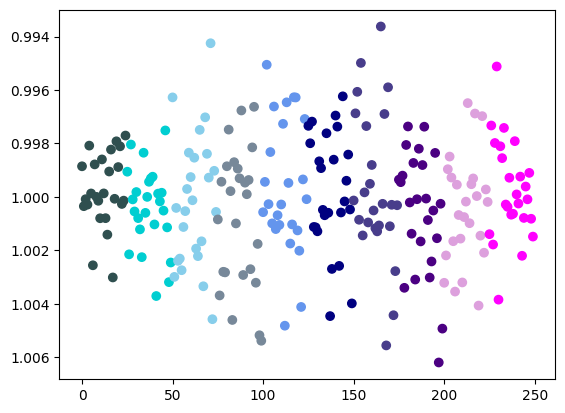

250


In [21]:
color_arr = np.array(sorted(CSS4_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c)))))
l = np.arange(0, len(slopes))

median_curves = []
for night in Nights:
    median_mags = []
    index_l = len(night.image_data)*night.obs_night
    index_h = len(night.image_data)*(1+night.obs_night)
    for source in Sources:
        if source.flagged != True:
            median_mags.append(source.calibrated_mags[index_l:index_h])
    median_curve = np.median(median_mags, axis = 0)/np.median(median_mags)
    median_curves.append(median_curve)
med_curve = np.concatenate(median_curves)
plt.scatter(l, med_curve, c = color_arr[93::5][np.array(night_array)])
plt.gca().invert_yaxis()
plt.show()

print(len(med_curve))

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.78272351, 54.45971846)>, Night_0_xy: (array(92.09772884), array(8.30491799)) rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.646775508358344, cal_mag_avg: 15.45544567074223, flagged: False, ID: 0, Chi2: None
None
[0.041945775739943694, 0.05157556243262369, 0.06649304605762431, 0.06513858169672775, 0.06151118399562399, 0.06871835235114614, 0.0688996742530629, 0.03940014126537216, 0.06735447659536405, 0.049380989482576]


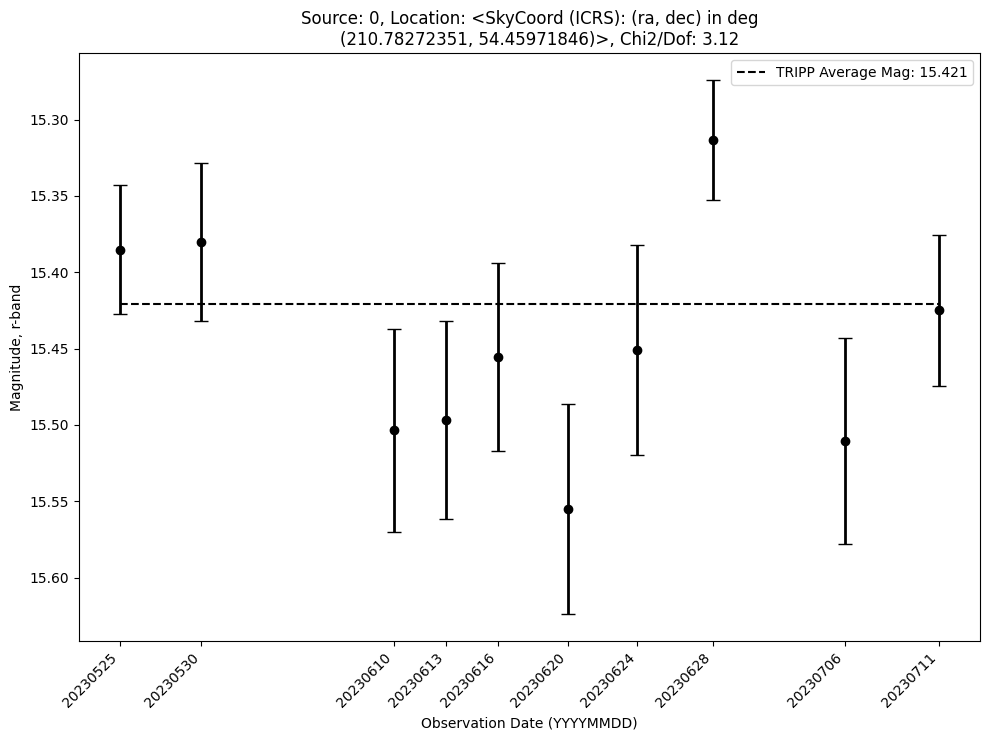

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.77550571, 54.14508597)>, Night_0_xy: (array(2076.52640841), array(18.34550922)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.724652917629591, cal_mag_avg: 16.34659221762247, flagged: False, ID: 1, Chi2: None
None
[0.05819533534946645, 0.06661033979937847, 0.0849489112309986, 0.08697160436548133, 0.08152240037037892, 0.08871814114272288, 0.09351672869452522, 0.054919943146580025, 0.08721574702795452, 0.0815812376221617]


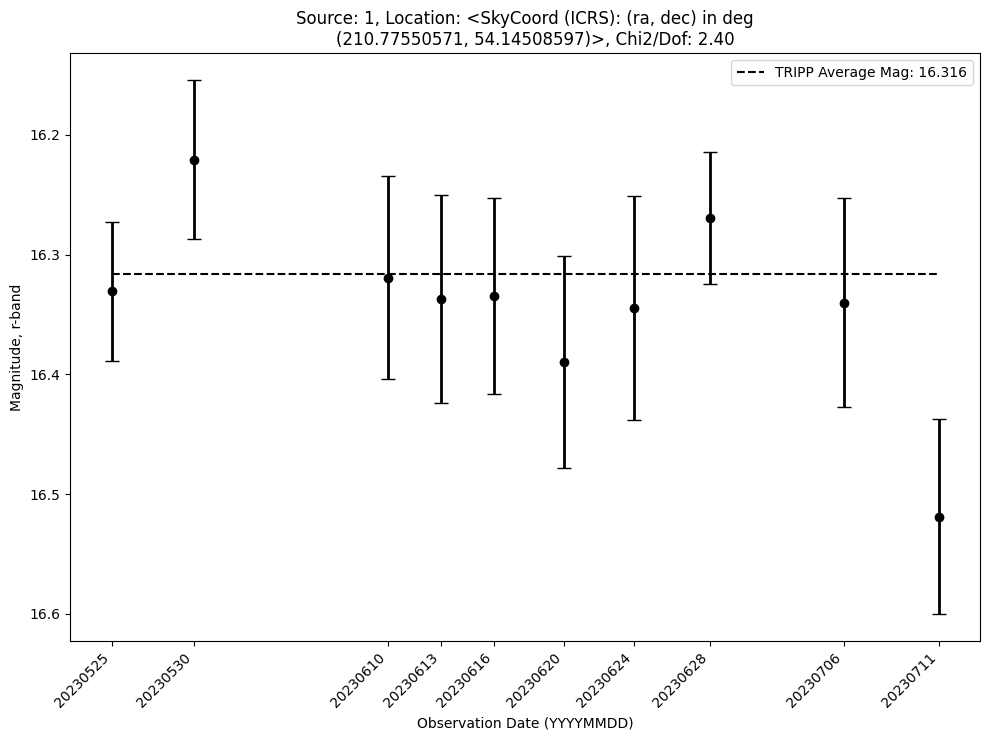

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79248564, 54.39747745)>, Night_0_xy: (array(483.90075687), array(51.40008259)) rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.708875952737646, cal_mag_avg: 15.395876388368746, flagged: False, ID: 2, Chi2: None
None
[0.04293204167754407, 0.047522225180815544, 0.06343440480798875, 0.059339480422511165, 0.05924312556453302, 0.06260886269411836, 0.06387170580037124, 0.039765632728362824, 0.062381115080478645, 0.046084670584303794]


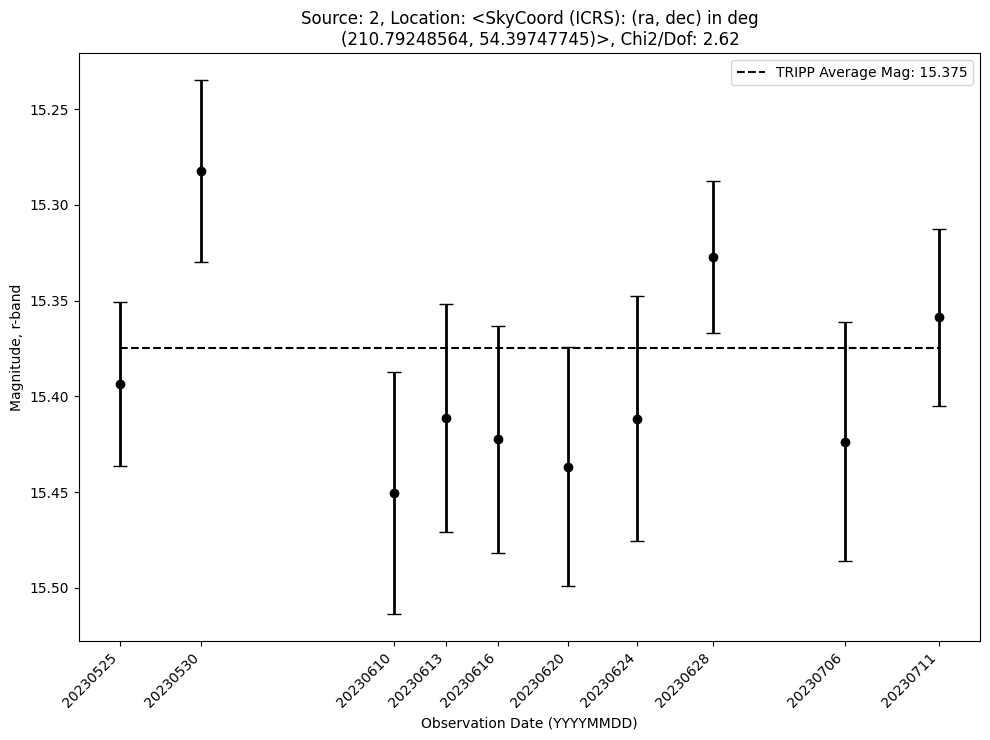

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80186801, 54.29859178)>, Night_0_xy: (array(1106.7841042), array(97.54437951)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.039091794405532, cal_mag_avg: 17.00901978605812, flagged: False, ID: 3, Chi2: None
None
[0.10737408076302127, 0.10268081176891776, 0.16196718254171727, 0.15542949907291503, 0.146980297315519, 0.16290385891670287, 0.16398672310871898, 0.09708170904581533, 0.17530984744541486, 0.14875030313747137]


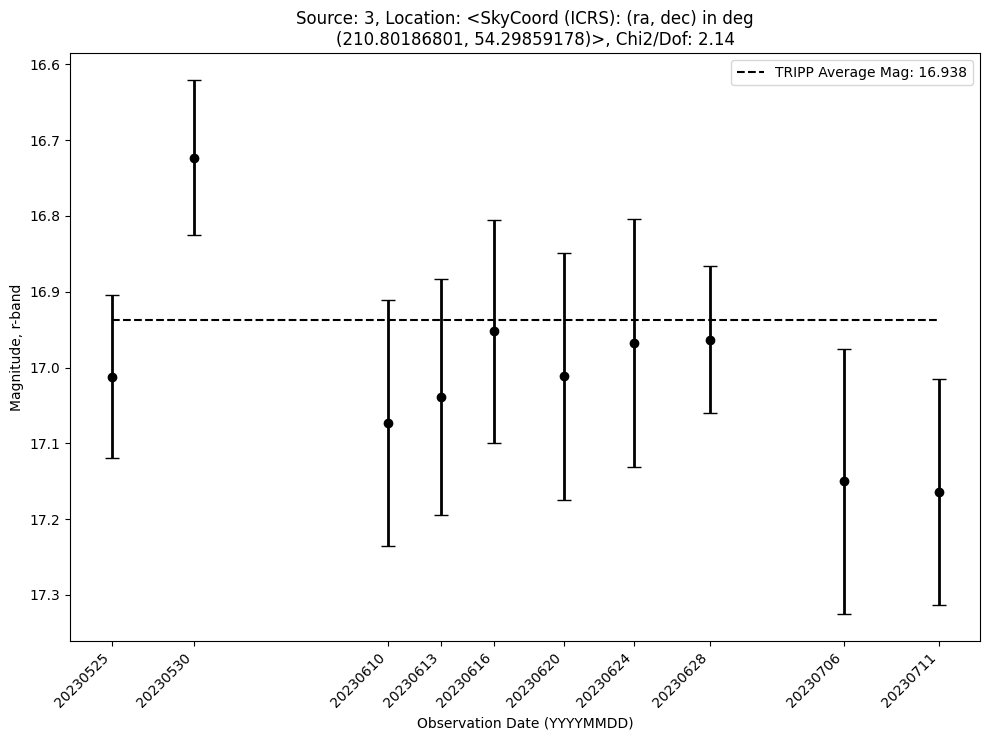

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.79447654, 54.0838712)>, Night_0_xy: (array(2461.22038125), array(95.61655266)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.388912964748059, cal_mag_avg: 14.739198095665783, flagged: False, ID: 4, Chi2: None
None
[0.02285937584432688, 0.026917665339641992, 0.03078557296765538, 0.029886891809284378, 0.029572783004288852, 0.030985158070197912, 0.03233750016100176, 0.022320926277727002, 0.030393074215927542, 0.02504137023010993]


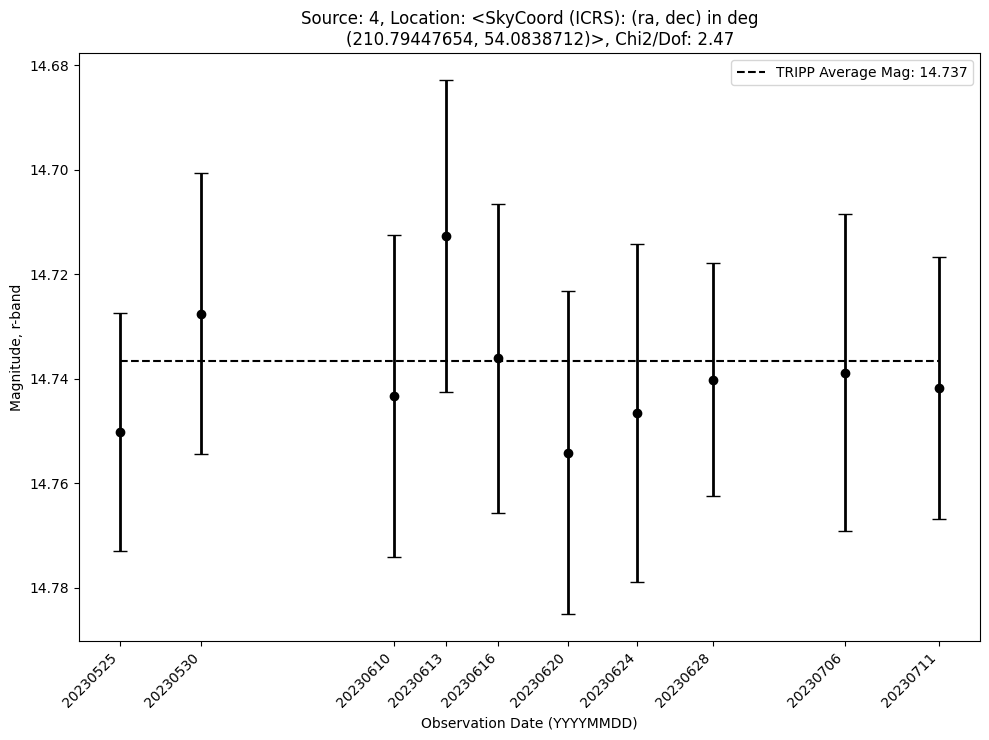

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80206959, 54.34873014)>, Night_0_xy: (array(790.62151576), array(92.3513505)) rad: 27.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.544951028988594, cal_mag_avg: 12.654100136112369, flagged: False, ID: 5, Chi2: None
None
[0.02577231378647562, 0.030435508148191764, 0.04234001247080906, 0.04064798338173145, 0.039649710383222285, 0.042835291925703935, 0.03942656044655686, 0.02266474169607728, 0.04286903509320702, 0.02686463885555925]


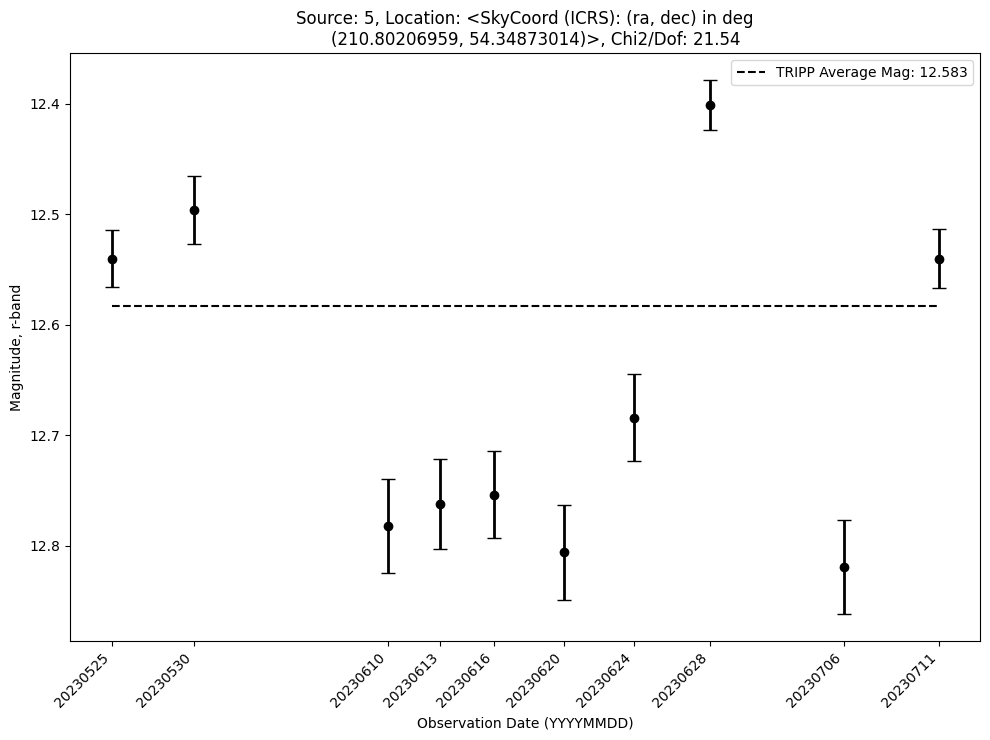

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80676757, 54.26196473)>, Night_0_xy: (array(1337.39715286), array(119.92389719)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.518726740308164, cal_mag_avg: 13.64776900328583, flagged: False, ID: 6, Chi2: None
None
[0.013160196214597698, 0.015491673218197713, 0.016346693514170146, 0.01640831928989952, 0.01626487202284311, 0.01692717550802678, 0.01722067115847595, 0.01310307046795507, 0.016656287692303987, 0.014085154437844772]


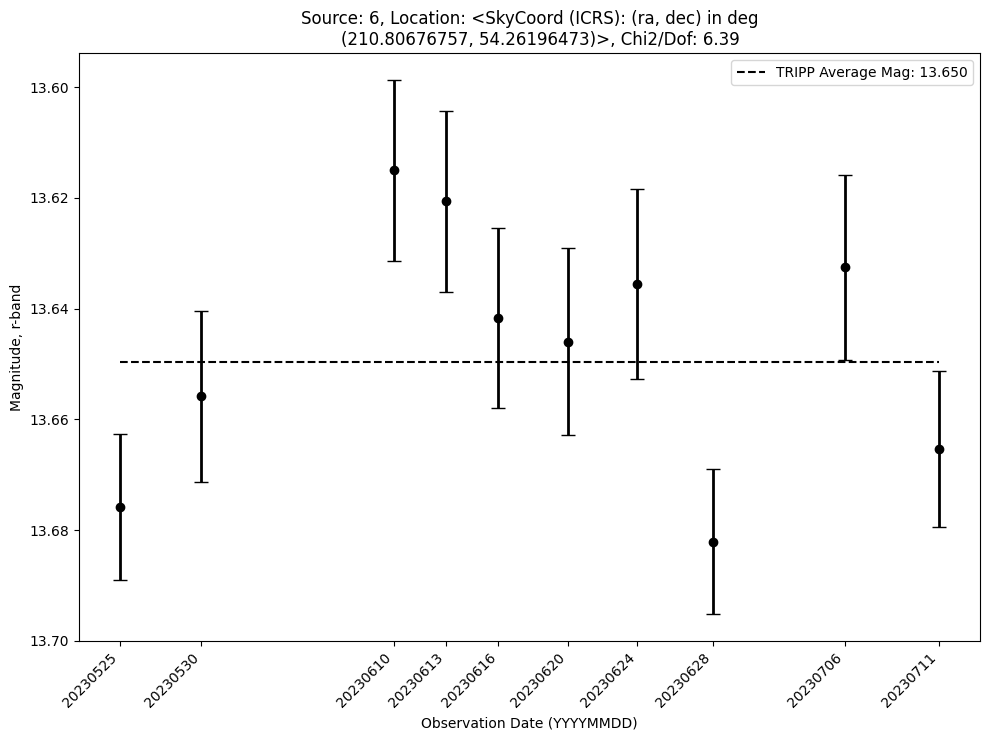

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.81073532, 54.37035913)>, Night_0_xy: (array(653.639728), array(121.62258588)) rad: 9.0, ref_status: None, ref_mag: None, inst_mag_avg:-11.336705552563647, cal_mag_avg: 12.857381152075806, flagged: False, ID: 7, Chi2: None
None
[0.009383960775369174, 0.011000738192610743, 0.01161233041020781, 0.011297557851887376, 0.011301781153457022, 0.011823064069442777, 0.011819721804193294, 0.009221977167208332, 0.011514144350302282, 0.009484315293262251]


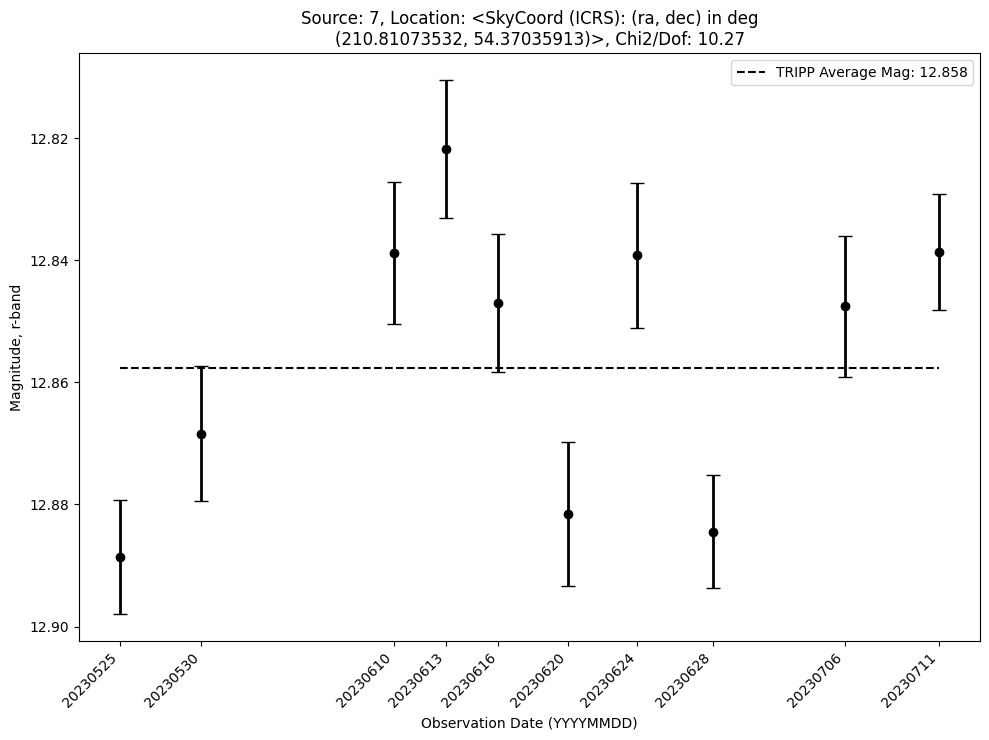

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8152421, 54.45781723)>, Night_0_xy: (array(101.85509232), array(127.72192476)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.329154026880904, cal_mag_avg: 14.796479962146869, flagged: False, ID: 8, Chi2: None
None
[0.03257262834436934, 0.03807399440790844, 0.04799681434351134, 0.04818093562533438, 0.046458587020468636, 0.046562781699663665, 0.04774889385952654, 0.030310276962775082, 0.047405332822021265, 0.03501060525368594]


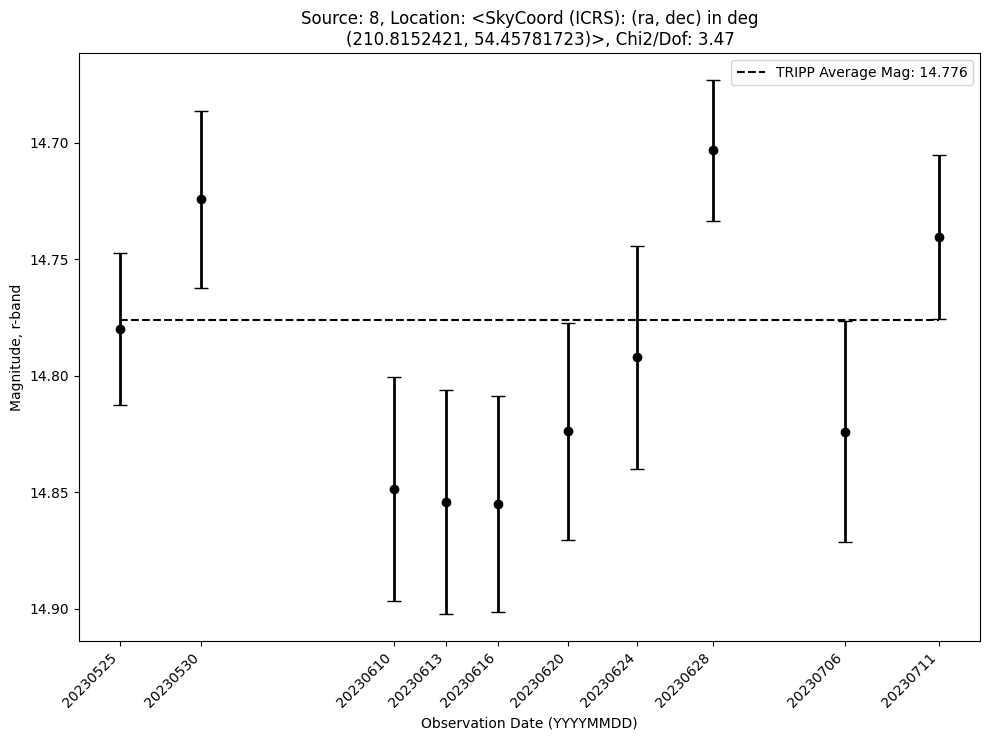

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.80834476, 54.11467639)>, Night_0_xy: (array(2266.01460358), array(143.24923778)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.2941548889650605, cal_mag_avg: 16.762161124530394, flagged: False, ID: 9, Chi2: None
None
[0.0675237783761341, 0.07845391916711378, 0.09761716099670191, 0.10335654987989168, 0.1044645021420145, 0.1095963727483836, 0.11535439347559344, 0.06510483362005577, 0.11592562900331857, 0.1036240321633055]


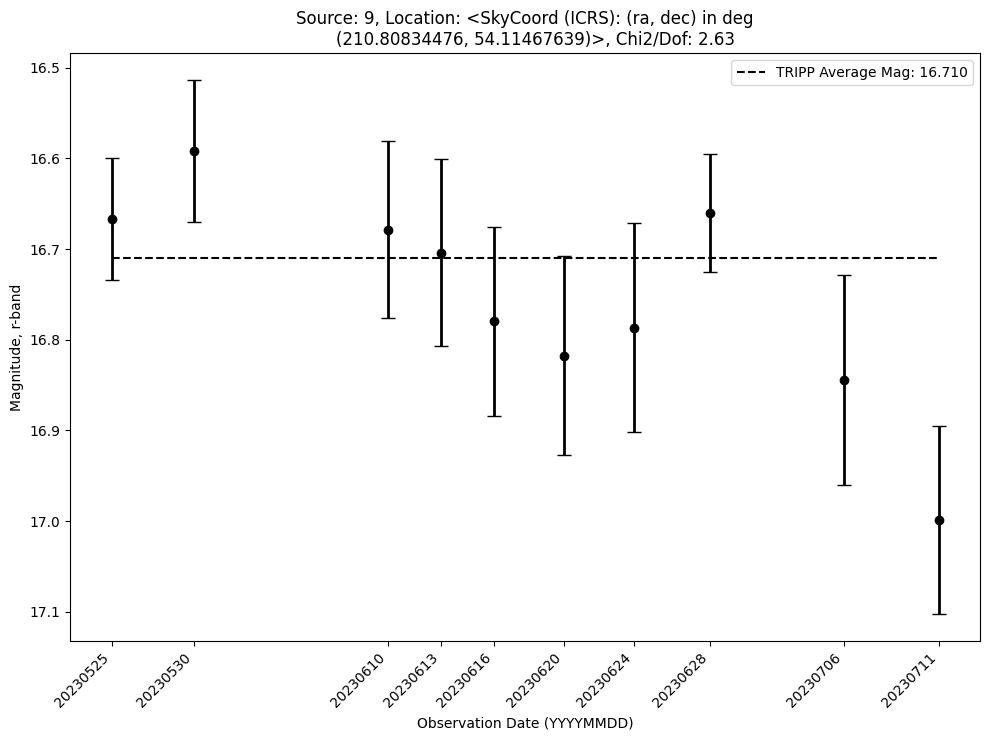

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.81572421, 54.26237173)>, Night_0_xy: (array(1334.20733157), array(152.86183977)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.575453018246393, cal_mag_avg: 16.49057094812627, flagged: False, ID: 10, Chi2: None
None
[0.06820207510596968, 0.06959207562481742, 0.09708290621327238, 0.09823065446312182, 0.09617272901982273, 0.106005347681782, 0.10556438193693601, 0.05872241205138191, 0.09914218592314822, 0.09439659038104255]


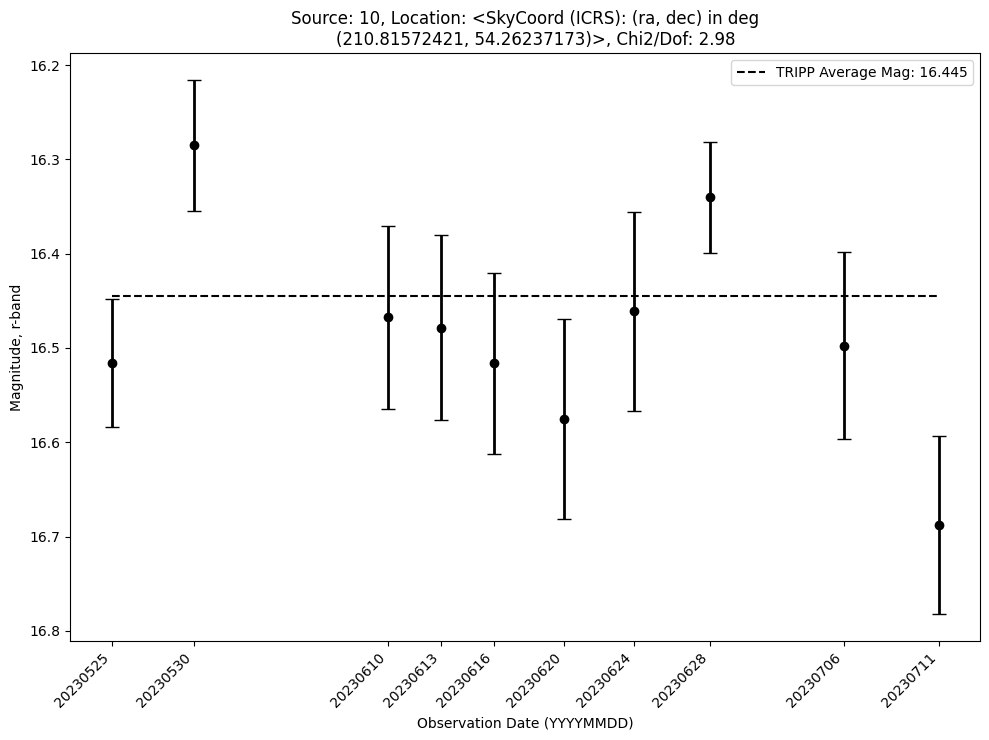

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.82637993, 54.34790299)>, Night_0_xy: (array(794.14497668), array(181.79575953)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.36529322926293, cal_mag_avg: 15.727768506988468, flagged: False, ID: 11, Chi2: None
None
[0.0466252182916953, 0.0520916470641509, 0.06589096419281547, 0.06521791897421414, 0.061615718630211744, 0.06887747209544416, 0.07073919188957016, 0.04211280385281253, 0.0679271597044938, 0.054070629370992544]


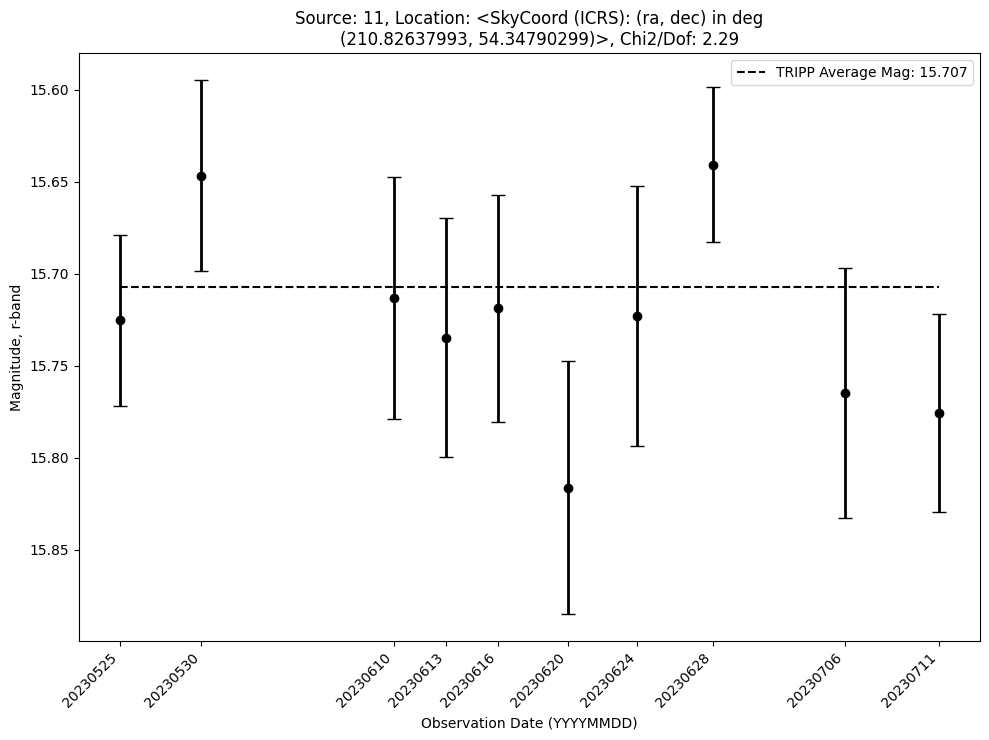

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.84294319, 54.26012276)>, Night_0_xy: (array(1346.46768237), array(253.38011403)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.725411600629691, cal_mag_avg: 14.414130844337313, flagged: False, ID: 12, Chi2: None
None
[0.020830752836037192, 0.02453231011074936, 0.02695182737655239, 0.02685932188801867, 0.027028626346280293, 0.027959569674015698, 0.02907340424017553, 0.020444004663009194, 0.028122339992978012, 0.022941864431544362]


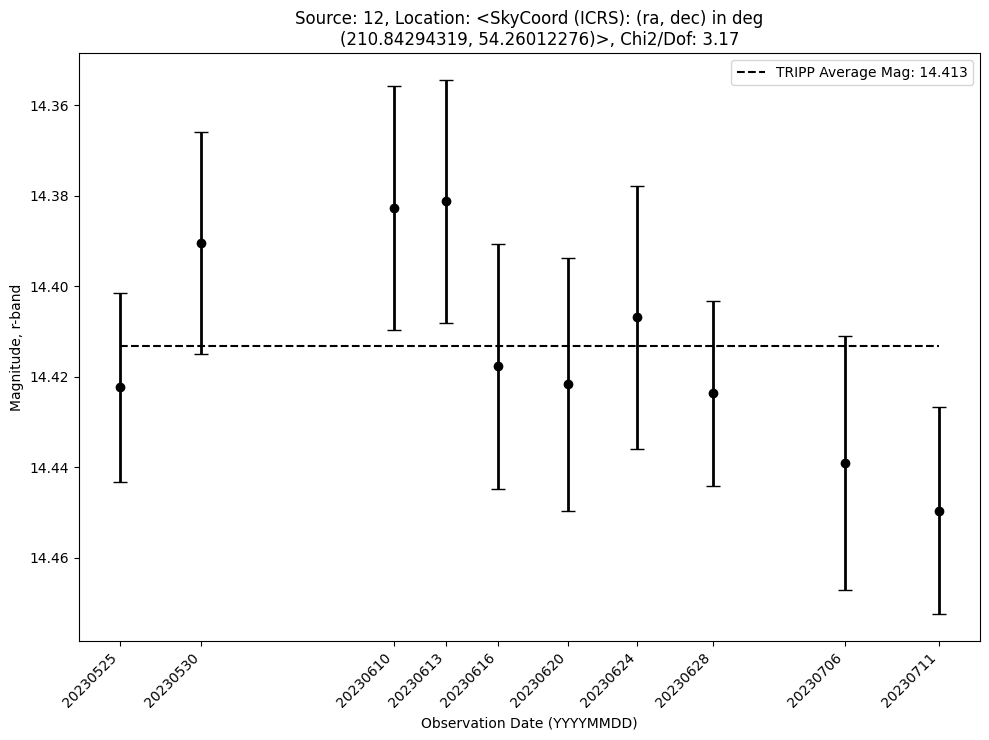

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.83908433, 54.0373817)>, Night_0_xy: (array(2751.22697907), array(266.26921639)) rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
14.14103, inst_mag_avg:-10.098529922209444, cal_mag_avg: 14.05345990774021, flagged: False, ID: 13, Chi2: None
None
[0.01917831964440529, 0.022757440393152195, 0.025869509728801098, 0.025258462934122466, 0.024817409757602195, 0.025907223740003645, 0.026321407263870243, 0.018249396256257783, 0.02541643335245212, 0.02006923828238659]


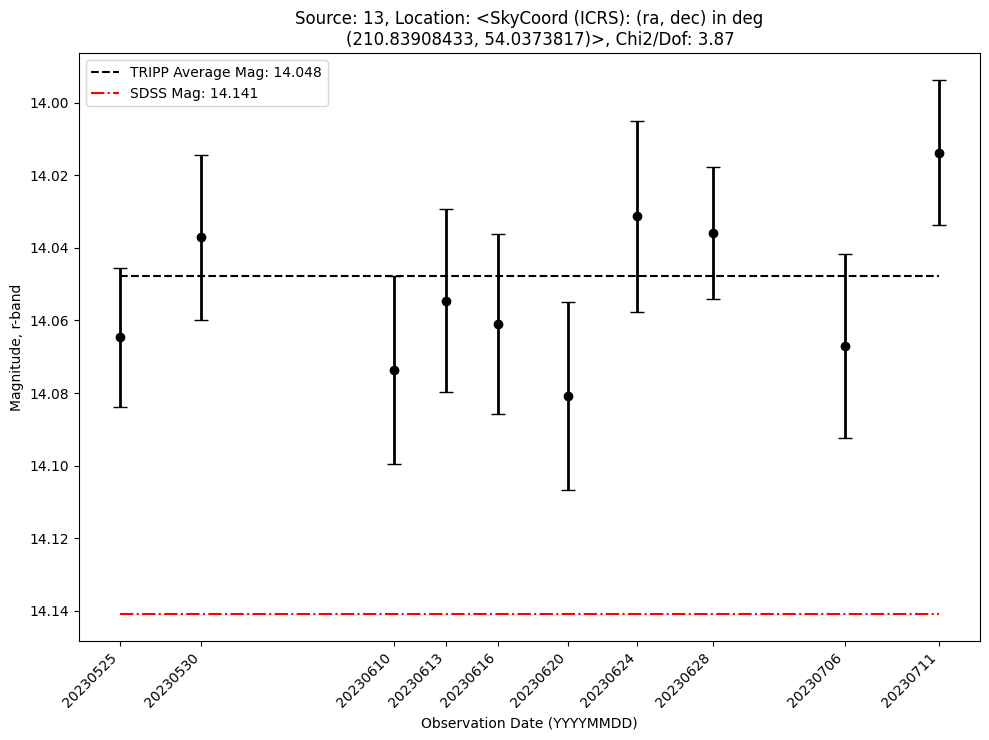

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8491348, 54.27057194)>, Night_0_xy: (array(1280.13895453), array(274.90334058)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.56992447815714, cal_mag_avg: 16.49631108582663, flagged: False, ID: 14, Chi2: None
None
[0.059164930903927104, 0.06219141490393712, 0.07748990848339736, 0.08032640465271587, 0.07990091467910443, 0.08325765166020864, 0.08955886299501918, 0.055485310821975234, 0.09442003669474193, 0.0847048648068818]


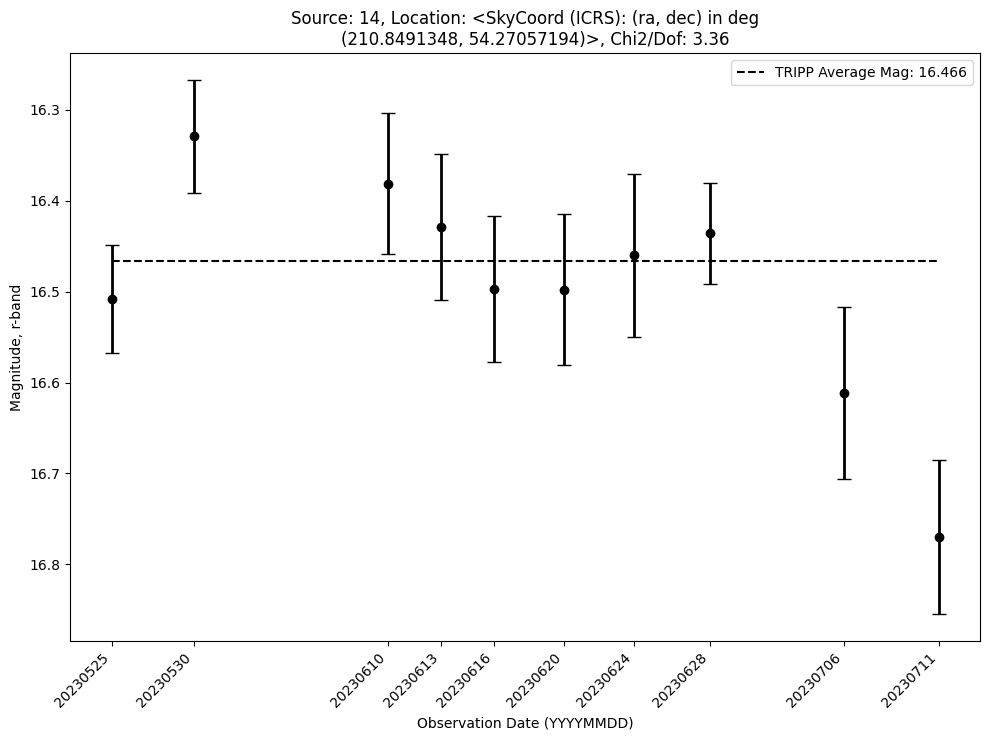

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.84889875, 54.24229868)>, Night_0_xy: (array(1458.4306658), array(277.49902744)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.62082456594309, cal_mag_avg: 15.481093106226334, flagged: False, ID: 15, Chi2: None
None
[0.03719381825147309, 0.04369034551972269, 0.04994766461631868, 0.05109656666886707, 0.051492475368406274, 0.05366245749743297, 0.056164601709990575, 0.03528150292077739, 0.05534911930838419, 0.0436961399127403]


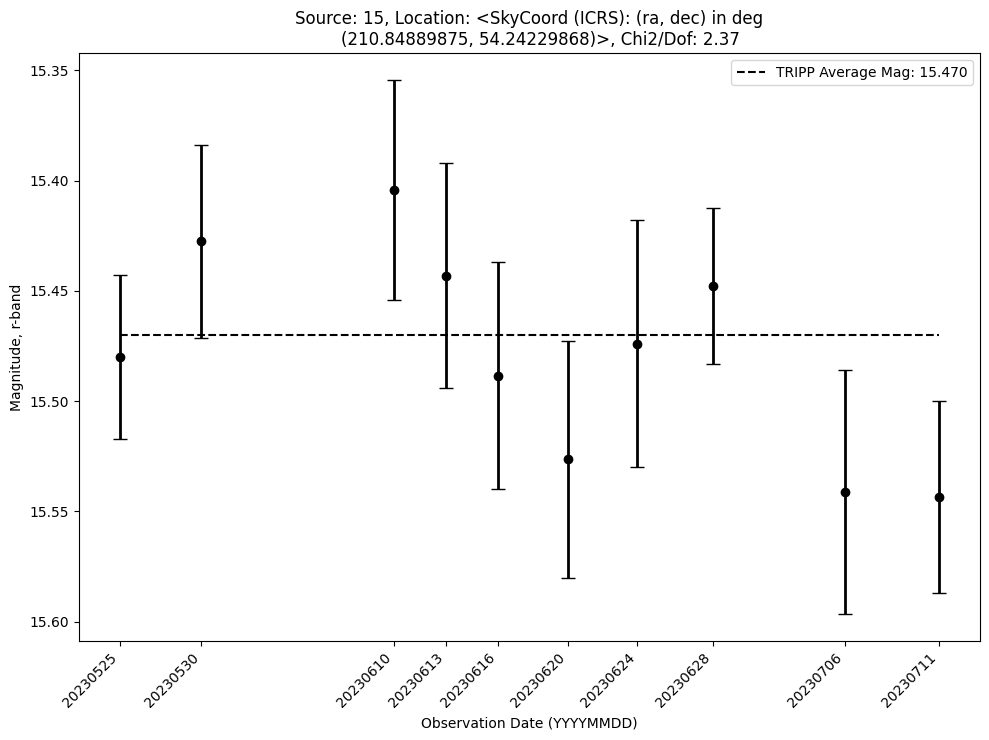

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85672758, 54.37867585)>, Night_0_xy: (array(597.95292063), array(289.53719638)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.237800038039929, cal_mag_avg: 15.851035453733788, flagged: False, ID: 16, Chi2: None
None
[0.045225952163664124, 0.05092788747143278, 0.06298417977250309, 0.06346740887312034, 0.0635106759511565, 0.06637000977216333, 0.07053027565646561, 0.043063991742624645, 0.06397492274687305, 0.054019079836126055]


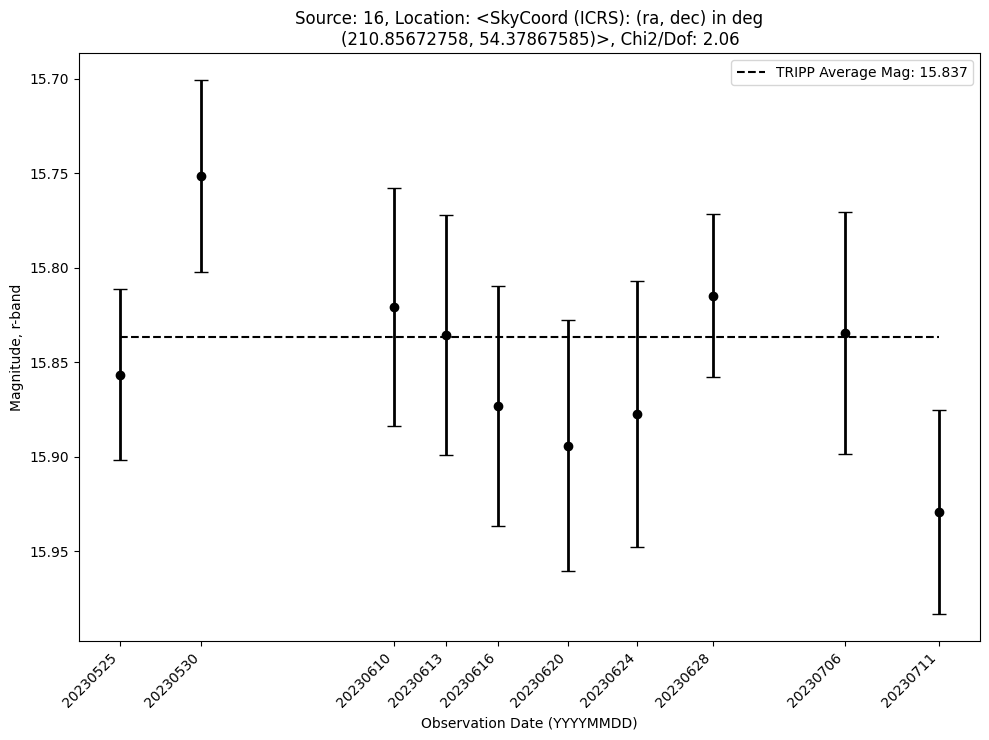

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85366314, 54.23249378)>, Night_0_xy: (array(1519.91279749), array(296.25980943)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.86087699688513, cal_mag_avg: 16.21488729911375, flagged: False, ID: 17, Chi2: None
None
[0.059039569516439024, 0.06773212720954072, 0.08679381647774415, 0.0864758793626284, 0.08468864393477012, 0.09370375796212636, 0.09217078124185309, 0.05588522021286546, 0.09834225661907696, 0.07961305919690799]


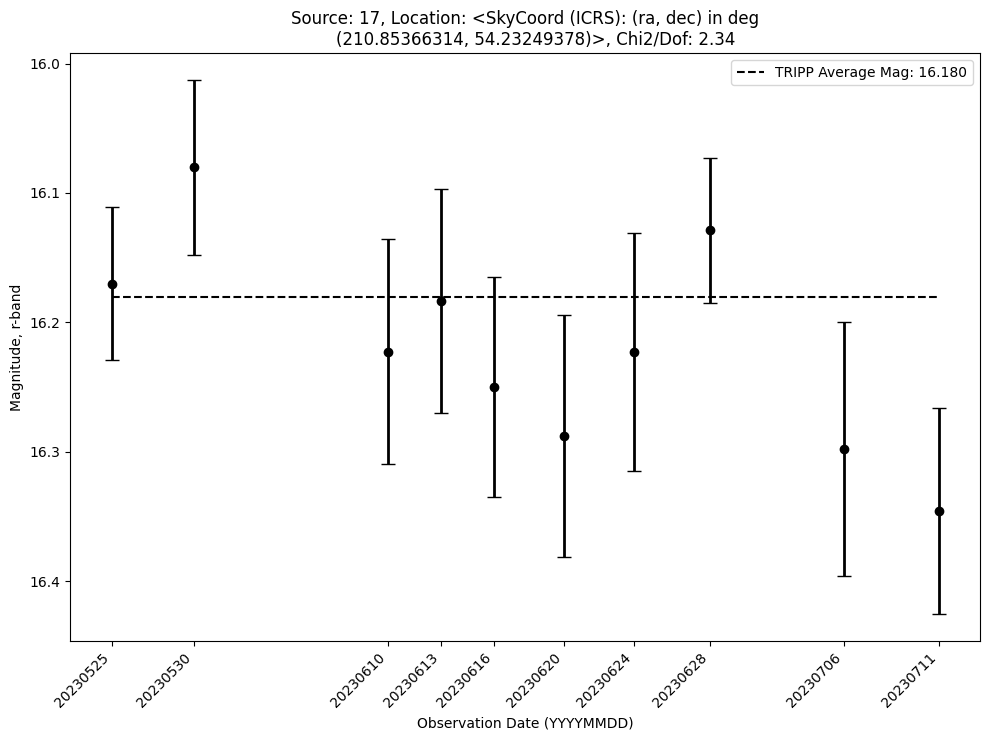

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85030384, 54.12207102)>, Night_0_xy: (array(2216.41643833), array(297.42509595)) rad: 2.5, ref_status: True, ref_mag: psfMag_r
--------
16.39703, inst_mag_avg:-7.377328079241004, cal_mag_avg: 16.682076207064245, flagged: False, ID: 18, Chi2: None
None
[0.065242393135835, 0.07575968384686108, 0.09996558889806019, 0.0970211635946028, 0.09392740878252337, 0.10361062490109618, 0.10630267451819417, 0.061944370420376205, 0.10163583224464805, 0.09603546465901379]


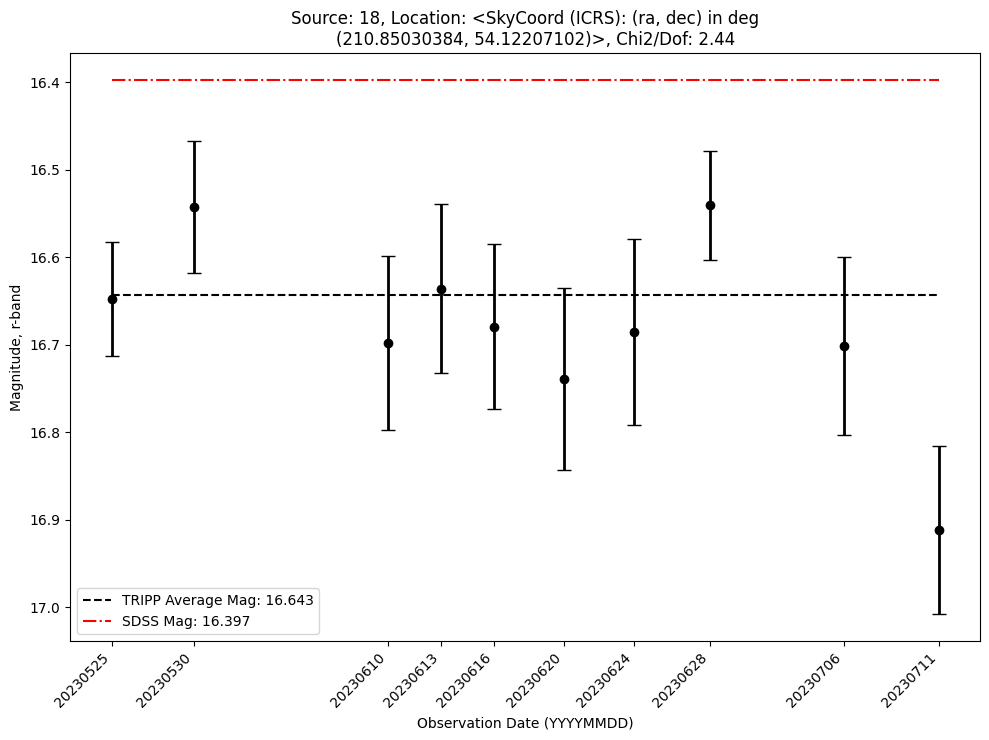

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.85063554, 54.04551099)>, Night_0_xy: (array(2699.13864348), array(308.04509437)) rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
17.44732, inst_mag_avg:-7.503959694709005, cal_mag_avg: 16.559347634086794, flagged: False, ID: 19, Chi2: None
None
[0.08298341341872258, 0.08834422859193068, 0.12569517908489491, 0.1317296601913561, 0.11197586066209941, 0.12335878697459077, 0.1334722164469145, 0.06898529633574475, 0.12589161673556873, 0.10155743769496045]


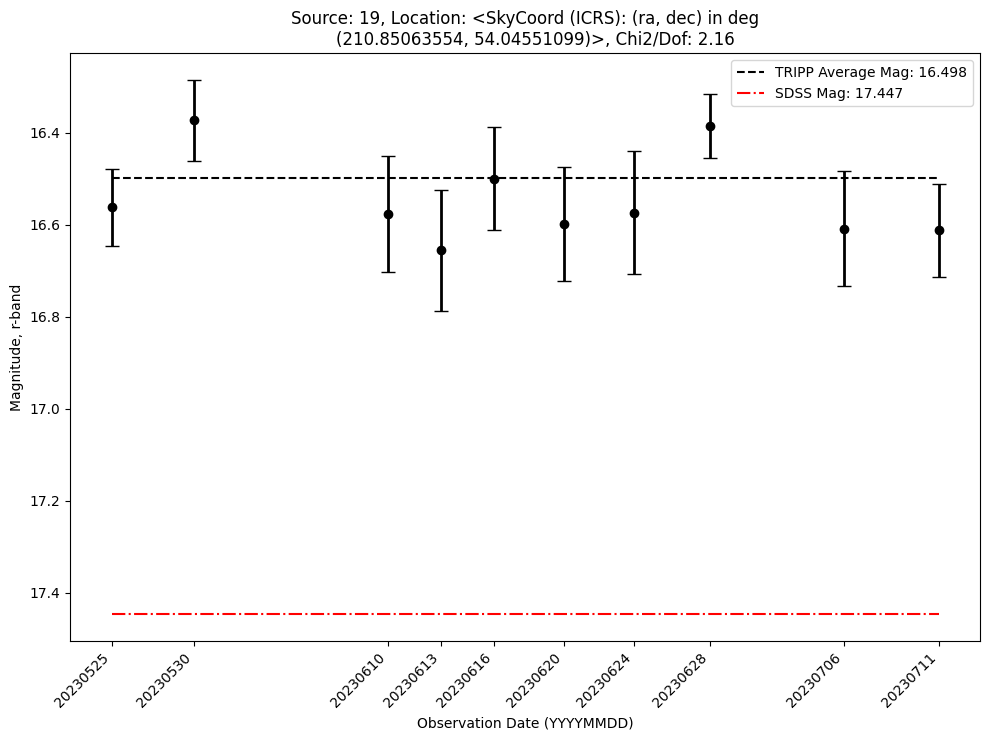

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86518663, 54.31283836)>, Night_0_xy: (array(1012.47678271), array(328.7666499)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.520531592698399, cal_mag_avg: 16.54329738355132, flagged: False, ID: 20, Chi2: None
None
[0.09517565558128689, 0.08952817013941784, 0.1421495124576173, 0.13909106523978287, 0.13915264026122576, 0.1580165758517107, 0.1373013623778386, 0.07403115922249409, 0.15502807678423358, 0.11205088090683421]


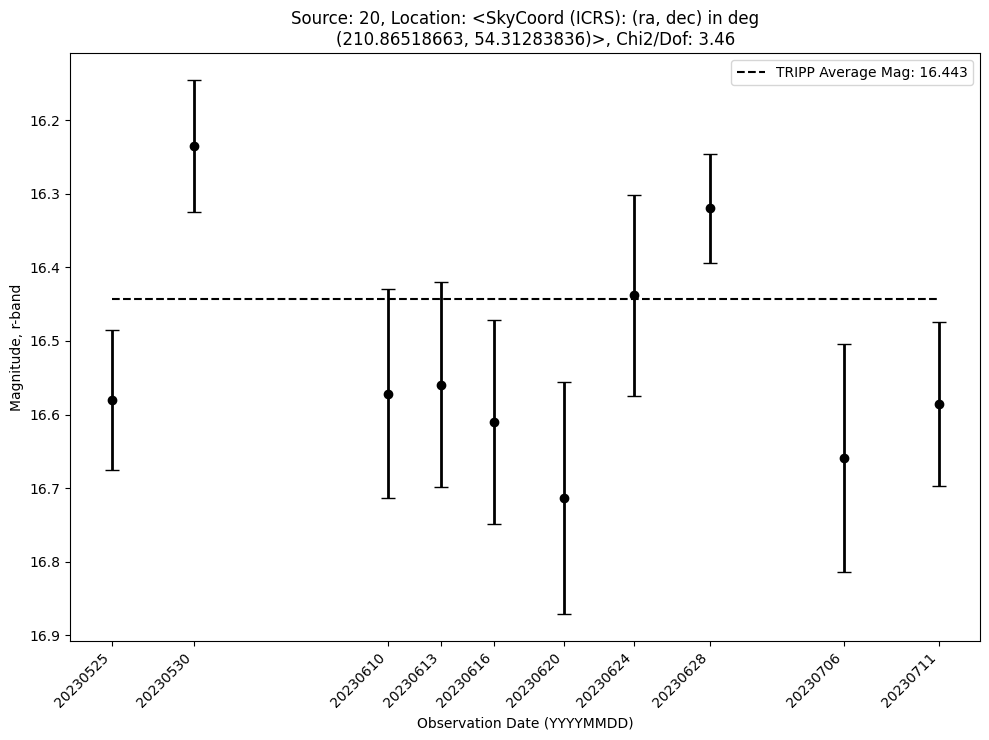

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86800042, 54.35876675)>, Night_0_xy: (array(722.67587987), array(333.4098708)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.09289232303872, cal_mag_avg: 16.956447759530196, flagged: False, ID: 21, Chi2: None
None
[0.10257816679668258, 0.1031213044455262, 0.14464398324769873, 0.15619781329396507, 0.14732643171815366, 0.16599844602134756, 0.1645287723058205, 0.08109397617116879, 0.16933622528428, 0.12907434013817196]


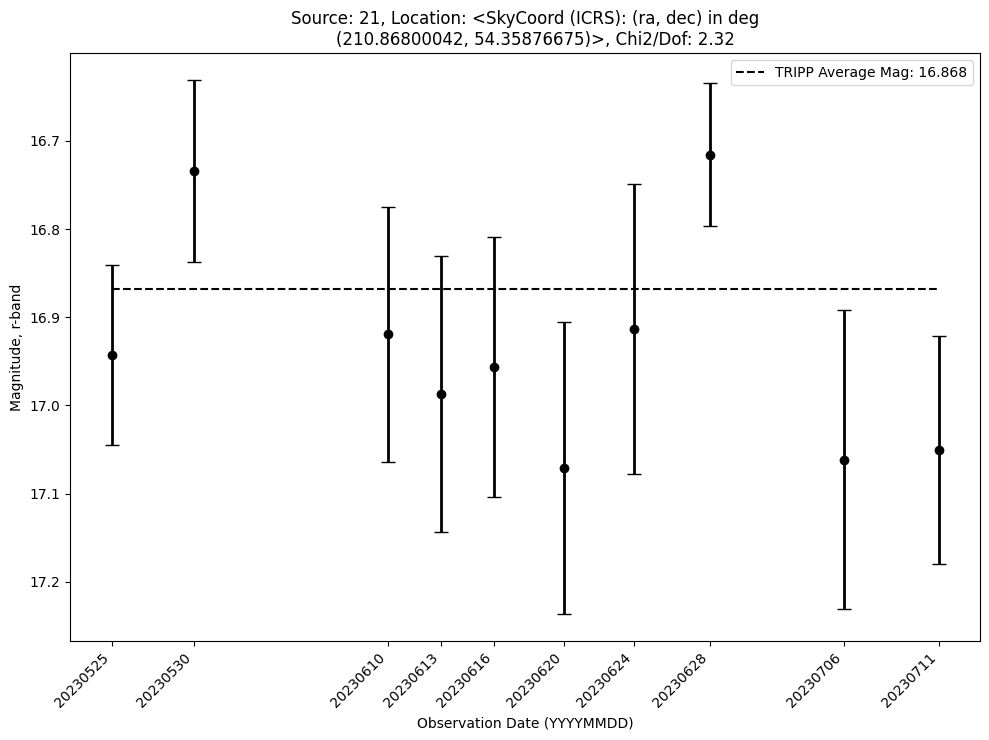

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.86386421, 54.06701257)>, Night_0_xy: (array(2562.60357915), array(354.35648486)) rad: 6.0, ref_status: True, ref_mag: psfMag_r
--------
14.09081, inst_mag_avg:-9.956196801184142, cal_mag_avg: 14.191069085134124, flagged: False, ID: 22, Chi2: None
None
[0.018617132705227638, 0.022009751928661687, 0.02468219944299935, 0.024254585362574646, 0.024073610600506168, 0.024883378636962977, 0.025690615115985513, 0.018421790373761154, 0.02469155071849146, 0.0204423493464241]


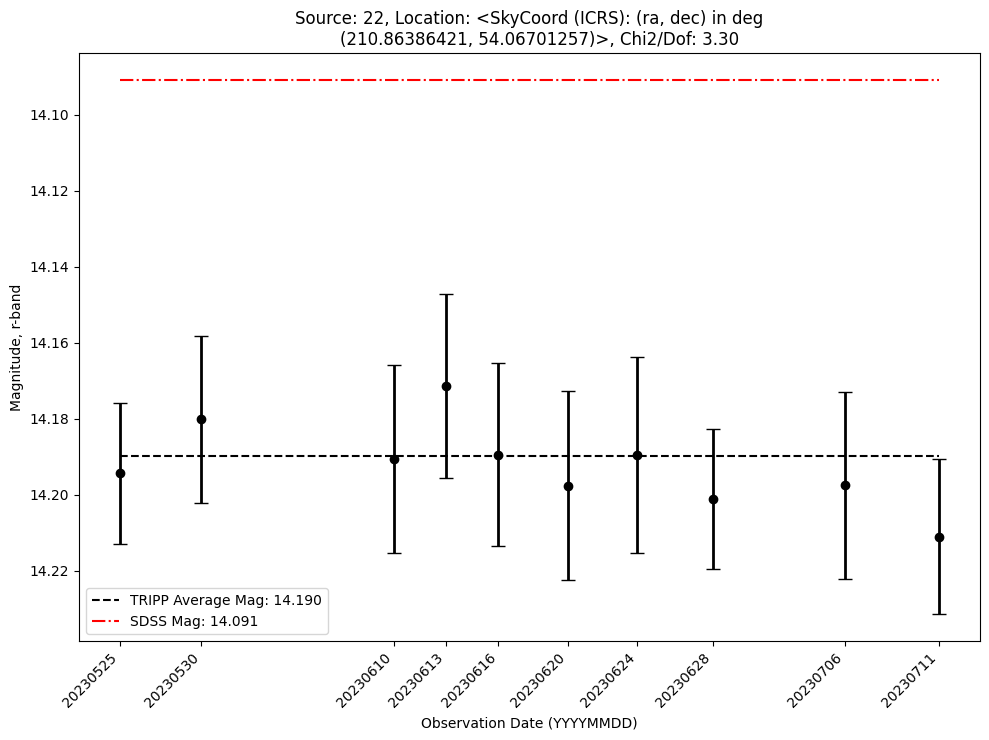

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8615306, 54.00013879)>, Night_0_xy: (array(2984.44379714), array(353.9923013)) rad: 6.5, ref_status: True, ref_mag: psfMag_r
--------
13.74609, inst_mag_avg:-10.457917434462756, cal_mag_avg: 13.70636440397471, flagged: False, ID: 23, Chi2: None
None
[0.013686404776782757, 0.01625269330511623, 0.018081893294188786, 0.017438773027559855, 0.017162490477521507, 0.017569850675819437, 0.018167744829942767, 0.013436967335698973, 0.017253893670094014, 0.014219897619497603]


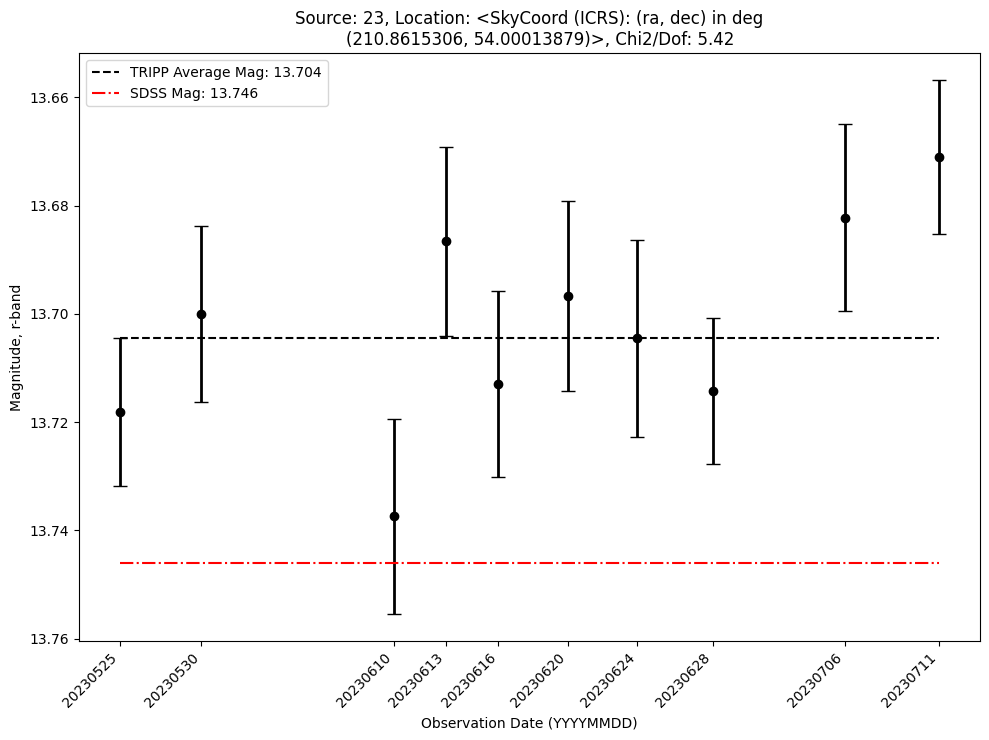

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.87048358, 54.19250825)>, Night_0_xy: (array(1770.82044052), array(363.22871418)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.021154236012935, cal_mag_avg: 16.06029164037022, flagged: False, ID: 24, Chi2: None
None
[0.05502944382041621, 0.05954120987293744, 0.07712961047830277, 0.07365339201381702, 0.07406997613402043, 0.07911672939053319, 0.08081509524710434, 0.04958910304503938, 0.08461563421300491, 0.0694626647009283]


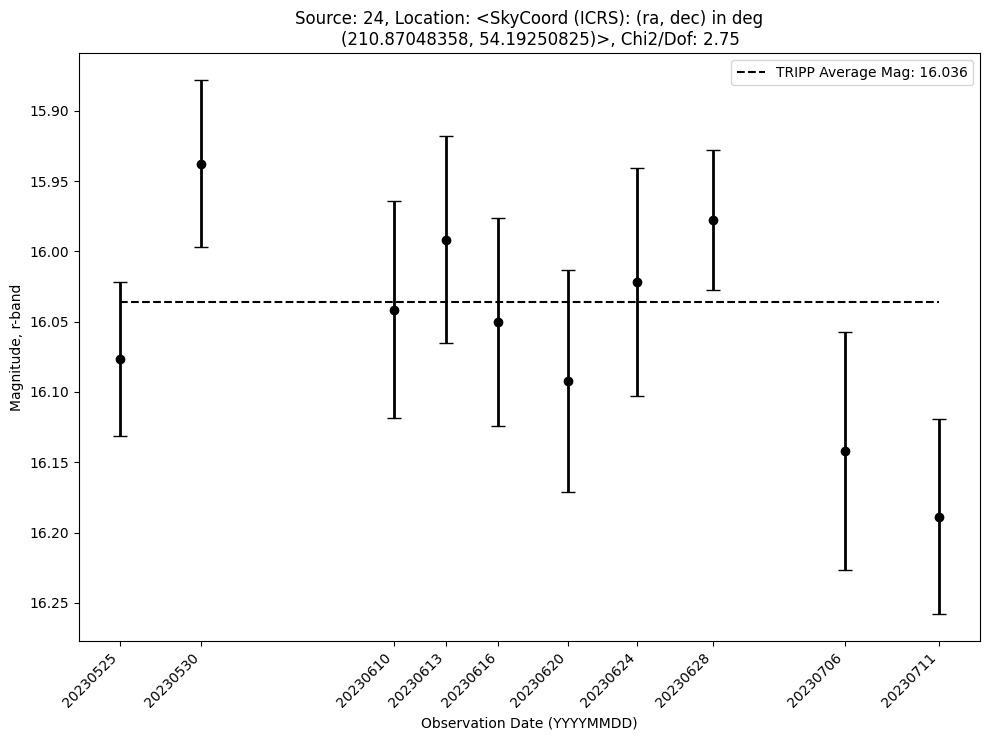

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.8805303, 54.35398963)>, Night_0_xy: (array(751.88636984), array(380.04615809)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.933513190507063, cal_mag_avg: 16.1445383061936, flagged: False, ID: 25, Chi2: None
None
[0.06267823460760986, 0.06866980875291158, 0.10025398709008283, 0.09149128782650708, 0.09240326516378967, 0.1057111729571861, 0.09897217568133965, 0.05663724436901497, 0.10320737775717337, 0.07935477533652997]


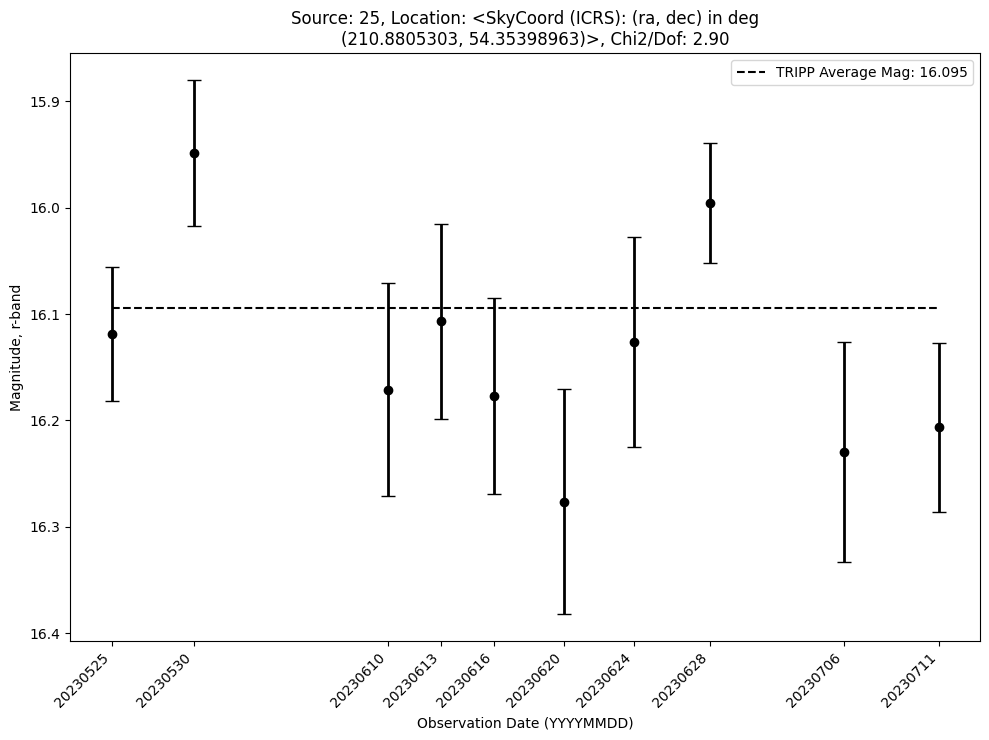

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.87569614, 54.06163606)>, Night_0_xy: (array(2595.64064658), array(398.80948609)) rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
14.91957, inst_mag_avg:-9.039091439618408, cal_mag_avg: 15.076949179160112, flagged: False, ID: 26, Chi2: None
None
[0.027095055983390227, 0.032091078185906646, 0.03630593905092707, 0.03709485480151036, 0.03556780320459684, 0.03627298965218895, 0.03968716281314441, 0.02622299171114763, 0.03693946198781775, 0.030320053877406727]


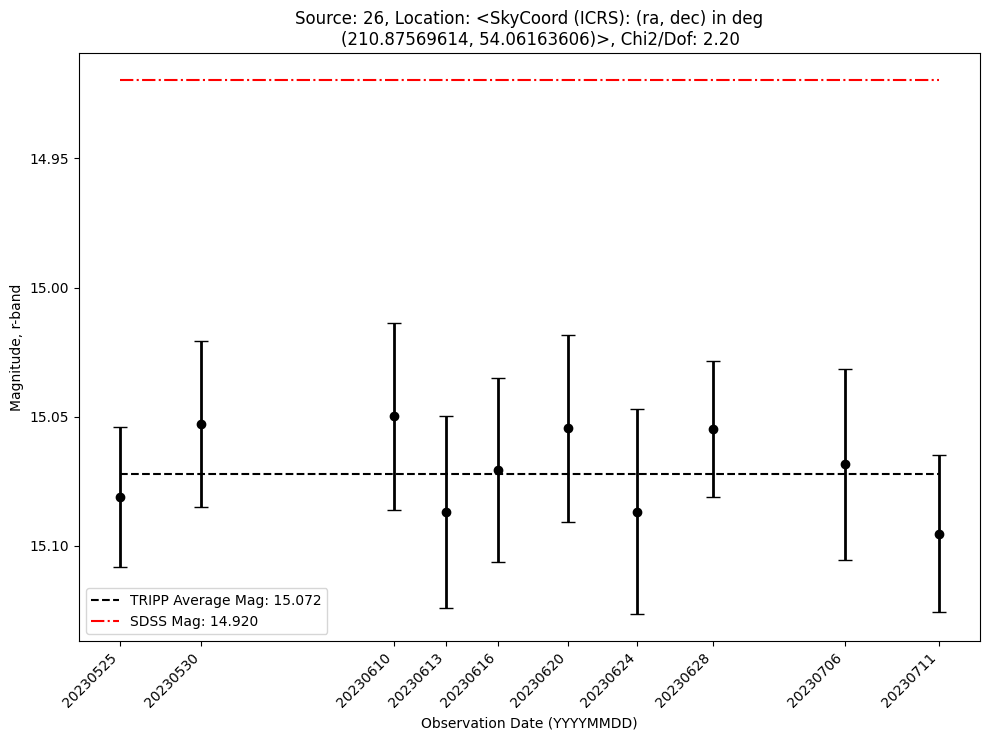

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88734587, 54.38781215)>, Night_0_xy: (array(538.12322527), array(400.82974953)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.4838200443086, cal_mag_avg: 14.647411203802225, flagged: False, ID: 27, Chi2: None
None
[0.024800690022878144, 0.02966075744918283, 0.03400947053793587, 0.032963692552069906, 0.032900997039723046, 0.035269368708048254, 0.035801367938296705, 0.0243062071608236, 0.034986199632883394, 0.026324556773168816]


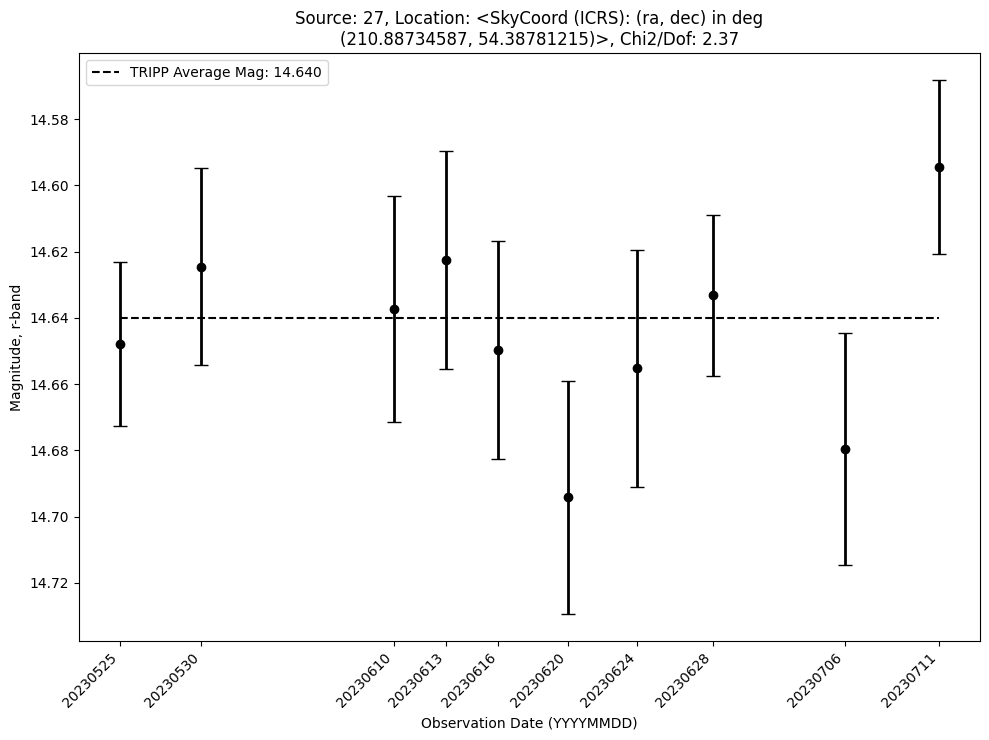

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88665759, 54.33614578)>, Night_0_xy: (array(863.950006), array(404.80853084)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-6.888381723911327, cal_mag_avg: 17.15398884880078, flagged: False, ID: 28, Chi2: None
None
[0.09402637435717663, 0.10134989741063788, 0.15665866831933137, 0.15348624322117388, 0.14503375751143446, 0.16150319403997257, 0.167455146822169, 0.08594002447067364, 0.16402529508830893, 0.14844226169434155]


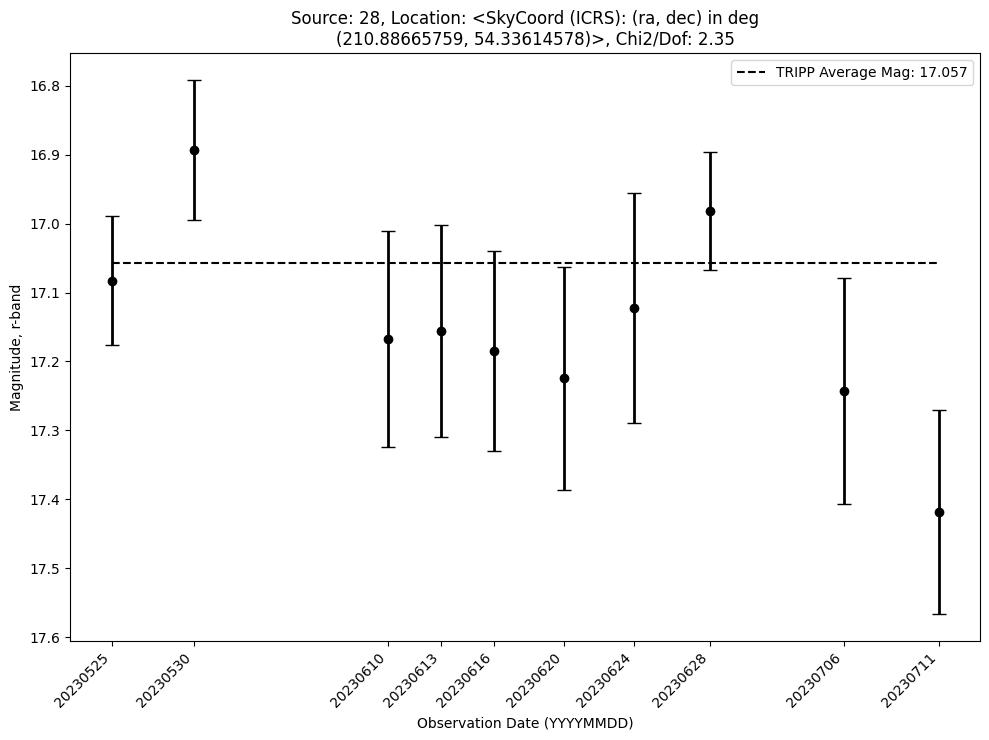

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88500977, 54.28890995)>, Night_0_xy: (array(1161.9100482), array(404.69179637)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.189568857457491, cal_mag_avg: 16.86267720032293, flagged: False, ID: 29, Chi2: None
None
[0.10676839113743372, 0.10141681108845055, 0.16229327362116952, 0.15129460648555518, 0.16603925430345623, 0.17521531184965572, 0.19419340219368003, 0.08476855701085495, 0.17598803005359562, 0.14022808755724886]


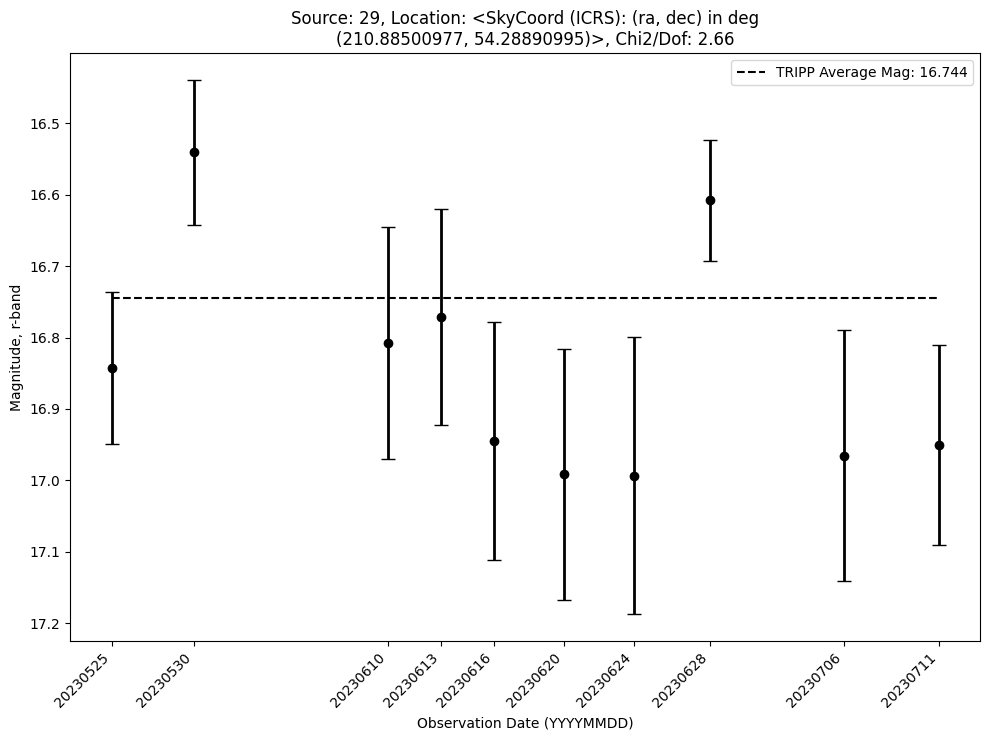

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.88362985, 54.1138174)>, Night_0_xy: (array(2266.03317608), array(421.61340678)) rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
15.02432, inst_mag_avg:-8.905922273859094, cal_mag_avg: 15.205679553158067, flagged: False, ID: 30, Chi2: None
None
[0.029468638292130957, 0.035544784231364854, 0.040553615328624865, 0.03939615878669382, 0.03991994898209451, 0.041773930768283445, 0.044305406823615195, 0.028875233102668544, 0.04042850727037638, 0.035429070847019115]


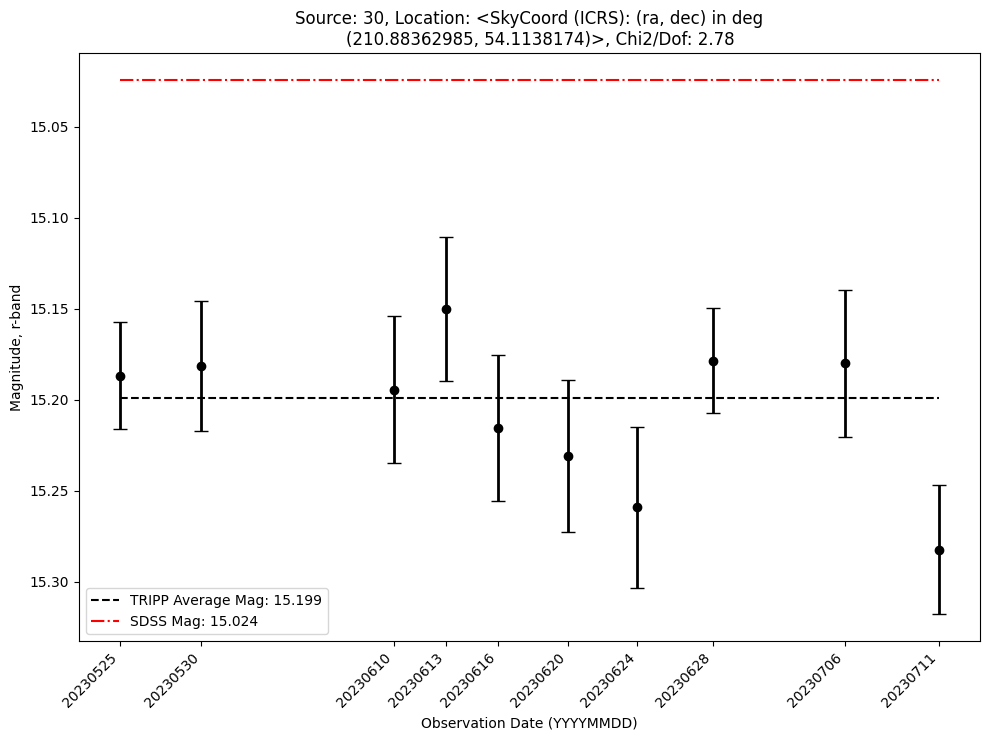

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.89603392, 54.43759338)>, Night_0_xy: (array(223.59366552), array(426.41856892)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.35739695803898, cal_mag_avg: 14.769574932689657, flagged: False, ID: 31, Chi2: None
None
[0.023154509084947053, 0.027826875796130145, 0.030992687603912192, 0.03206620391781689, 0.03010688912951469, 0.031831469842294235, 0.03330660260295346, 0.022910517055280896, 0.03126484934501568, 0.02540682265400953]


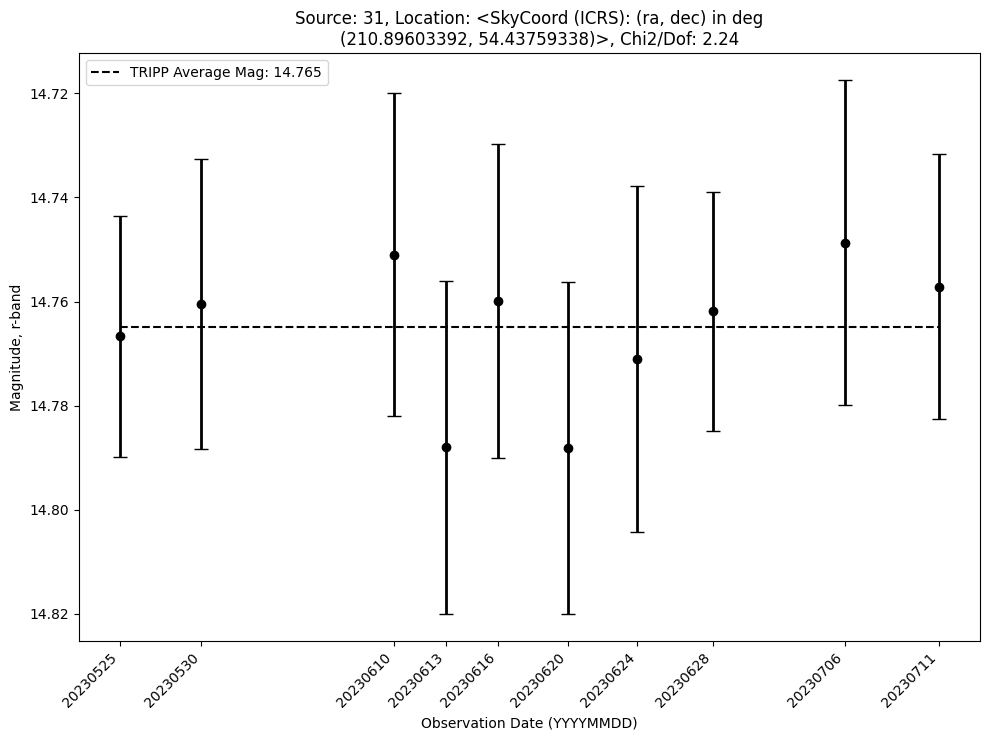

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.89840483, 54.3416589)>, Night_0_xy: (array(828.32192493), array(447.29380653)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.912130246569898, cal_mag_avg: 15.199563157189669, flagged: False, ID: 32, Chi2: None
None
[0.03238783323687613, 0.038731816017554536, 0.04452867765781808, 0.045991192408000287, 0.04380590191414171, 0.046866923160746414, 0.047842749734721045, 0.031132353330973115, 0.04813849883648387, 0.03647409530340057]


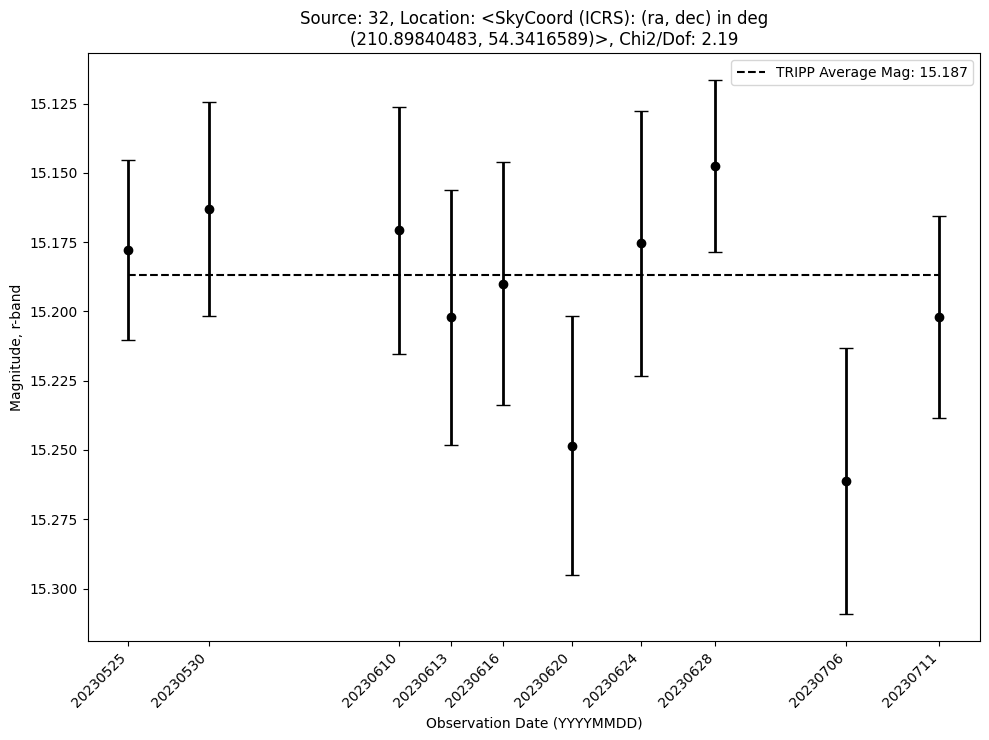

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.90052695, 54.34964825)>, Night_0_xy: (array(777.78914063), array(454.07815577)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.028225924901927, cal_mag_avg: 16.053573624001945, flagged: False, ID: 33, Chi2: None
None
[0.046821537672555466, 0.05441362174164612, 0.06494613452280329, 0.06423600618502727, 0.06332780668180242, 0.06891153985078069, 0.07346730024878685, 0.042890408881561294, 0.06717266875459336, 0.06056361473166752]


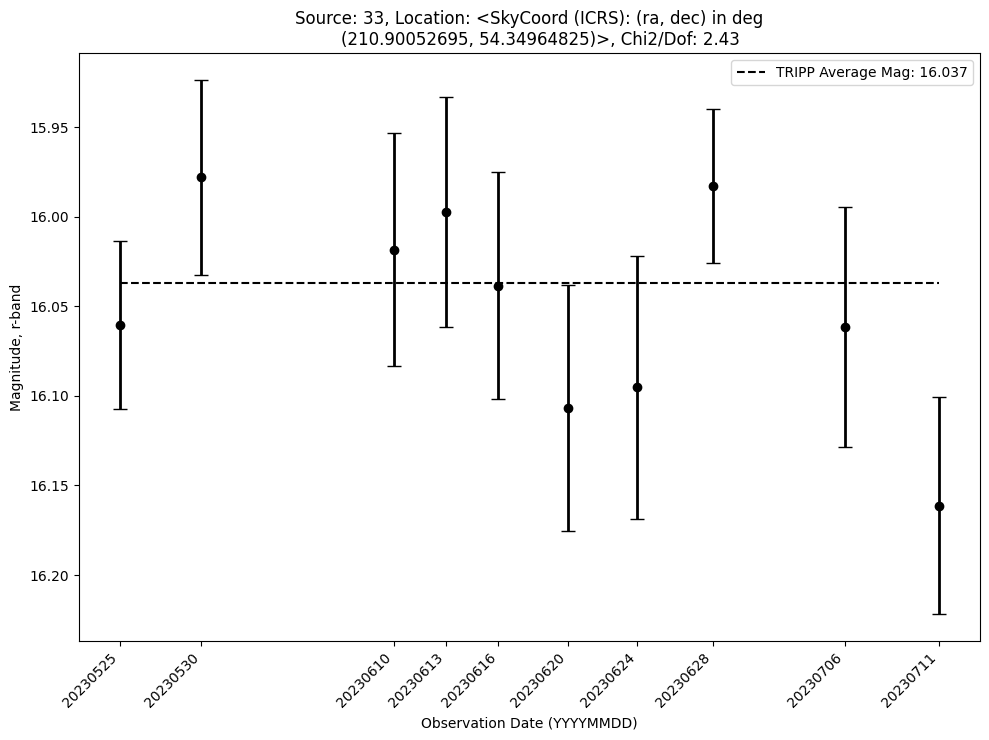

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91055426, 54.31169678)>, Night_0_xy: (array(1016.33978453), array(495.78820628)) rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-12.610343300227651, cal_mag_avg: 11.624622292808557, flagged: False, ID: 34, Chi2: None
None
[0.00397791700717497, 0.004557944940494179, 0.005724364025701336, 0.005861164314524647, 0.00618533943173149, 0.006768236603836052, 0.007019873051024461, 0.00585595783732912, 0.007837609340203047, 0.006704352174573333]


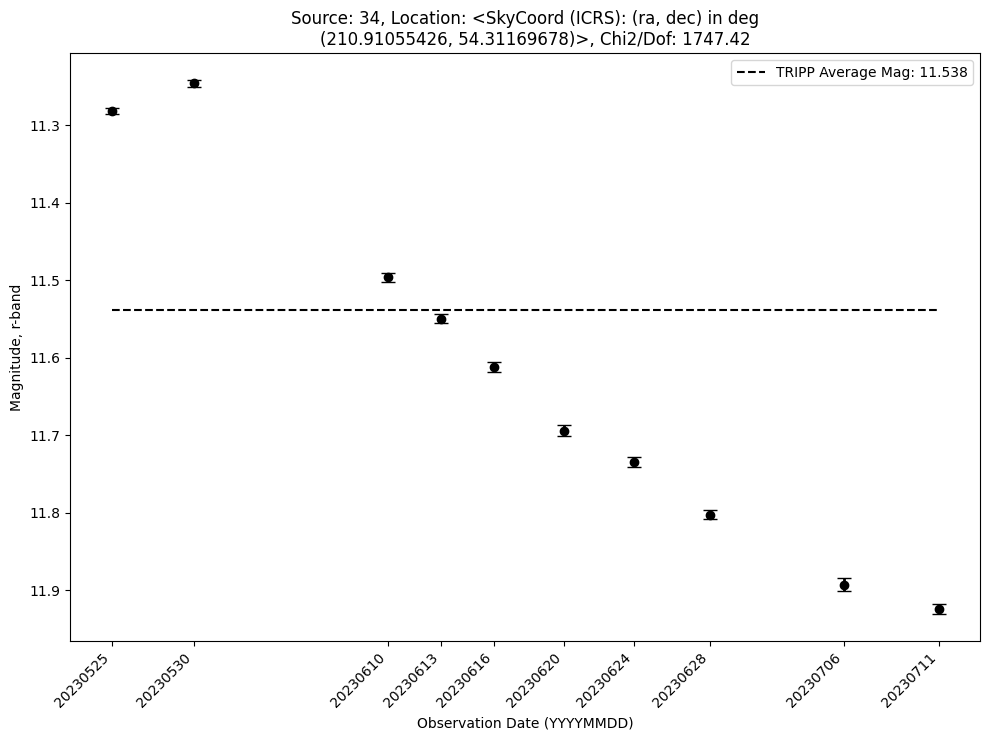

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91689781, 54.39173506)>, Night_0_xy: (array(511.19778968), array(508.82754052)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.492362226952638, cal_mag_avg: 15.605003034783698, flagged: False, ID: 35, Chi2: None
None
[0.04078894349726858, 0.047412732610907234, 0.05974019157383604, 0.05682064430283926, 0.05449748027913777, 0.061265073030297296, 0.06283974003935205, 0.037968001137983674, 0.061706718977750756, 0.048656394284627744]


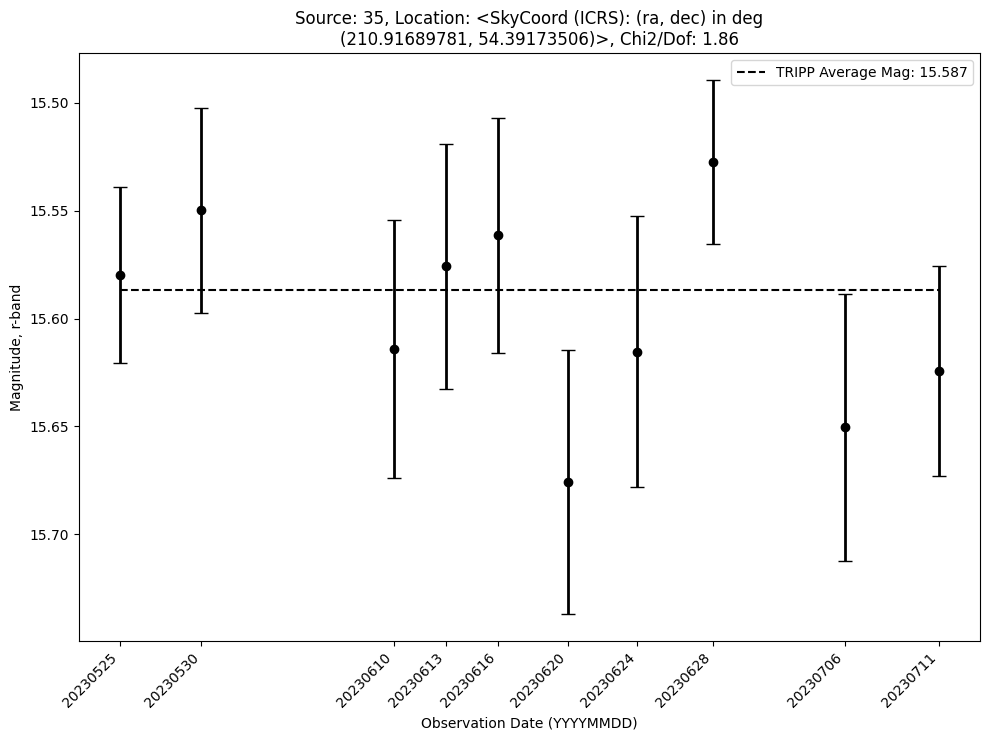

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91605555, 54.31568738)>, Night_0_xy: (array(990.7661171), array(515.51098526)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.2397726915917096, cal_mag_avg: 16.814287868407096, flagged: False, ID: 36, Chi2: None
None
[0.10572583646052428, 0.10135121801037086, 0.1564187752463154, 0.1676859391858239, 0.13680033107602987, 0.15683411339778175, 0.15930989066869397, 0.08288429868743452, 0.16998974798688485, 0.14931185579348683]


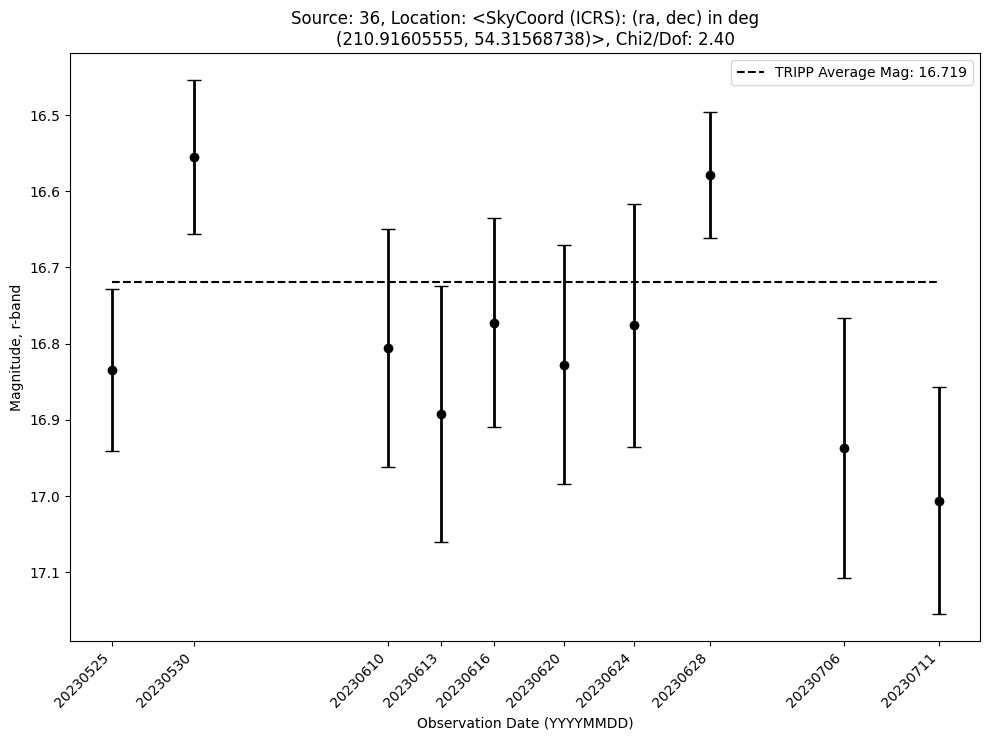

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.92241703, 54.31797144)>, Night_0_xy: (array(975.88643518), array(538.61360774)) rad: 10.0, ref_status: None, ref_mag: None, inst_mag_avg:-9.774764566643364, cal_mag_avg: 14.36550307827737, flagged: False, ID: 37, Chi2: None
None
[0.03524428659455162, 0.04054909550814171, 0.05437715580782974, 0.05152775384089137, 0.04980156155238638, 0.05594719633617364, 0.051091642411980026, 0.030802909353184405, 0.05451158972274651, 0.03669520937423186]


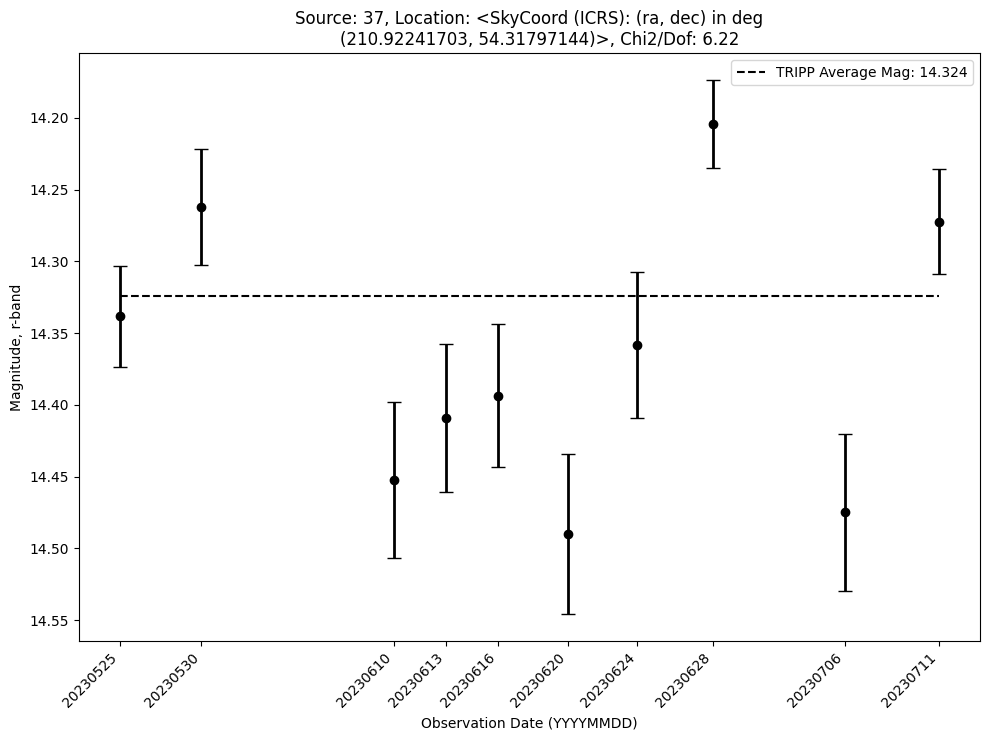

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.9417537, 54.44672344)>, Night_0_xy: (array(162.601634), array(592.88373674)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.413261880040332, cal_mag_avg: 15.68169134374244, flagged: False, ID: 38, Chi2: None
None
[0.04517093546266829, 0.05022250218059294, 0.06184170023228855, 0.06538275837406093, 0.060910908651538156, 0.06502966010133968, 0.0675939817757675, 0.04098516191089137, 0.0627698495917595, 0.050247008322448064]


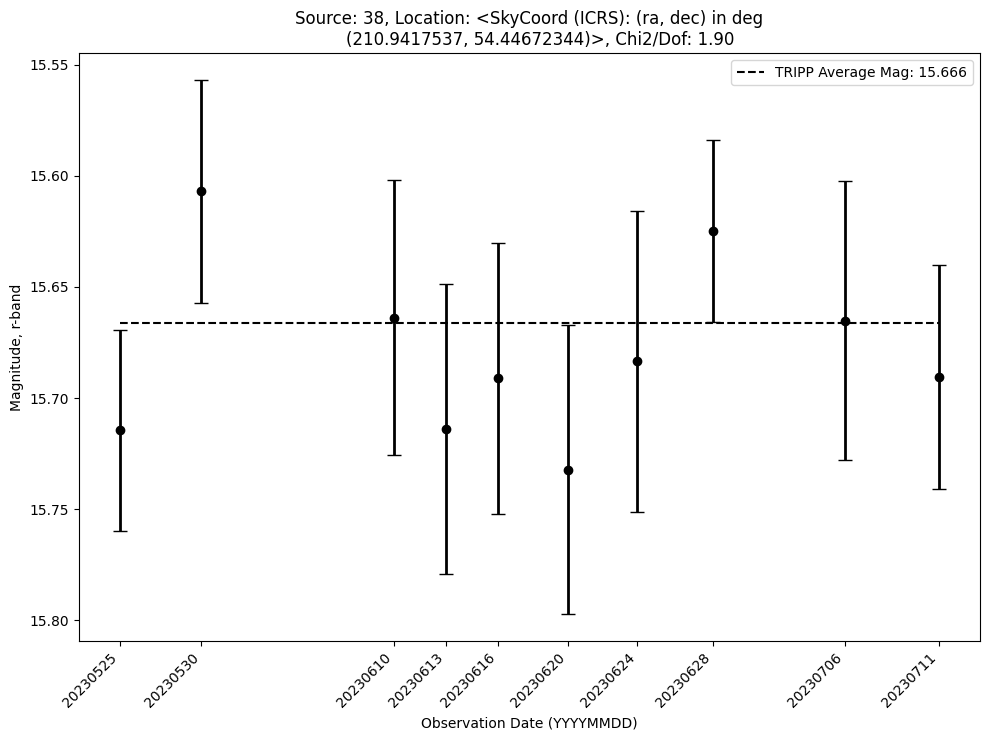

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.93805894, 54.27106037)>, Night_0_xy: (array(1270.48871595), array(602.26354298)) rad: 6.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.222332173080973, cal_mag_avg: 13.93398989445195, flagged: False, ID: 39, Chi2: None
None
[0.015213208913299064, 0.018138116274651072, 0.019428274303135287, 0.019077146227147696, 0.019209638030577642, 0.02029727314062511, 0.020685454695282626, 0.015124418801696113, 0.019986515516341886, 0.016541253915127705]


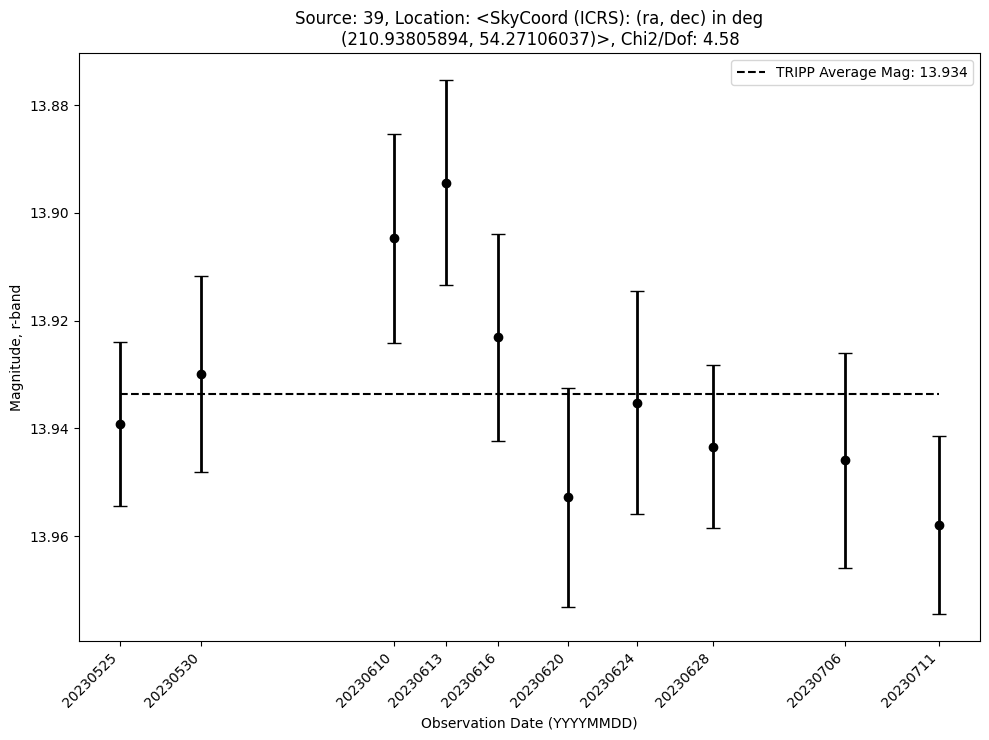

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.94550841, 54.29515842)>, Night_0_xy: (array(1117.97549263), array(626.53110111)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.031710659364174, cal_mag_avg: 16.049808539069385, flagged: False, ID: 40, Chi2: None
None
[0.05413079804732513, 0.05921787194920525, 0.07410319127292356, 0.07198022809439848, 0.07778546793867616, 0.07851588066696956, 0.0838811161435914, 0.04728028931880441, 0.08098084769944615, 0.06758477522169268]


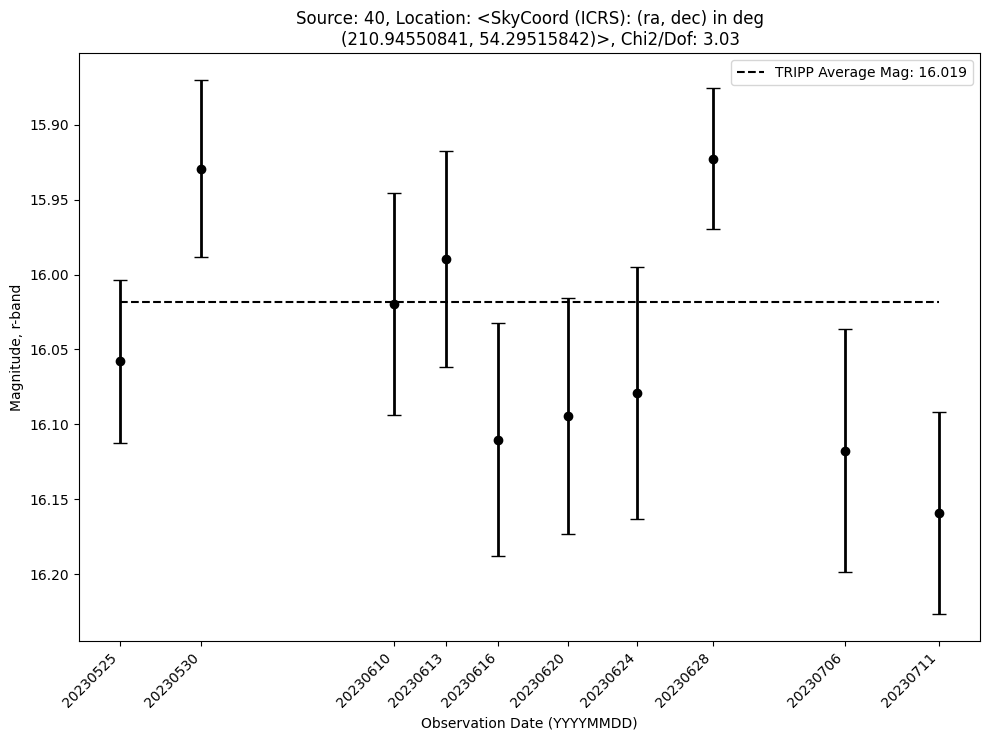

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95617089, 54.46091011)>, Night_0_xy: (array(72.04819289), array(643.86650568)) rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.40927, inst_mag_avg:-7.555134033996491, cal_mag_avg: 16.510839892346183, flagged: False, ID: 41, Chi2: None
None
[0.07497394424837812, 0.07213294236541744, 0.10060319921083861, 0.10000953365480289, 0.09641323982650477, 0.10410735148326734, 0.10465803029269437, 0.06280023320987867, 0.09539184011228438, 0.08325606012516068]


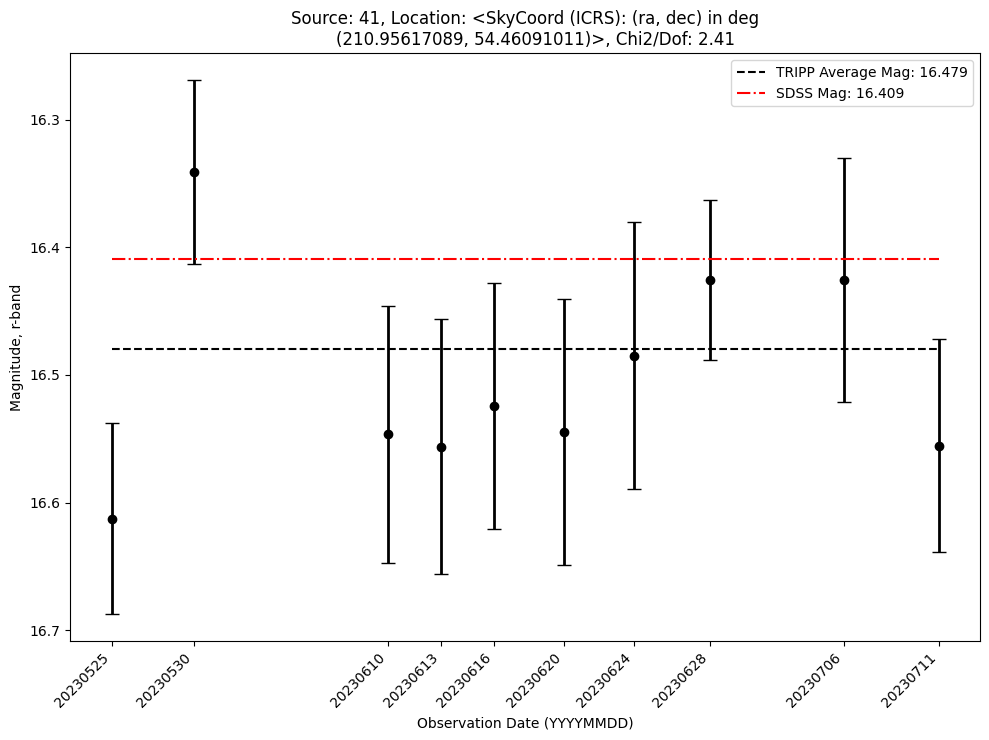

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95549419, 54.41993155)>, Night_0_xy: (array(330.48242865), array(646.79835342)) rad: 2.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.126207290260133, cal_mag_avg: 16.924457092390824, flagged: False, ID: 42, Chi2: None
None
[0.0838185311678018, 0.083260328343286, 0.12055530051818408, 0.12701993981180837, 0.11682399523391043, 0.12328443267584958, 0.137451832115919, 0.07223807132531013, 0.13717749591492862, 0.11563218853093107]


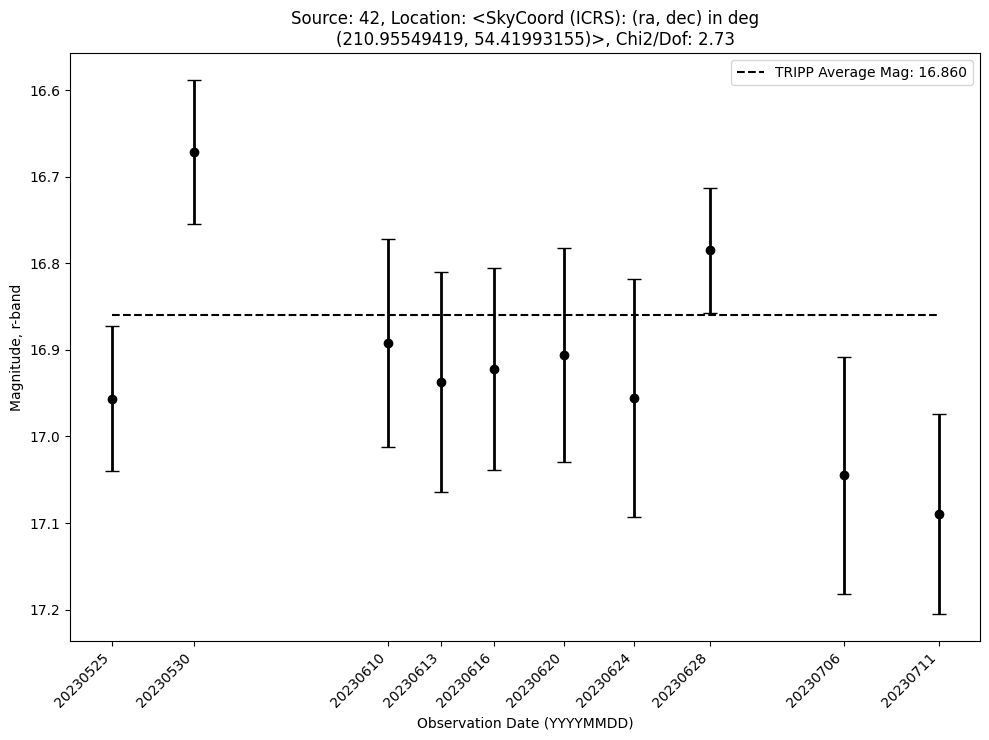

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.95776278, 54.15153029)>, Night_0_xy: (array(2022.63999384), array(690.62221651)) rad: 11.5, ref_status: True, ref_mag: psfMag_r
--------
11.62752, inst_mag_avg:-12.539860047872168, cal_mag_avg: 11.694660139419623, flagged: False, ID: 43, Chi2: None
None
[0.004642528300265297, 0.005452957671414995, 0.0055978984019603275, 0.005464487070584295, 0.0054898573171208226, 0.005719555638768936, 0.005634122866841096, 0.004655225211396346, 0.005585604065627951, 0.004803763624970849]


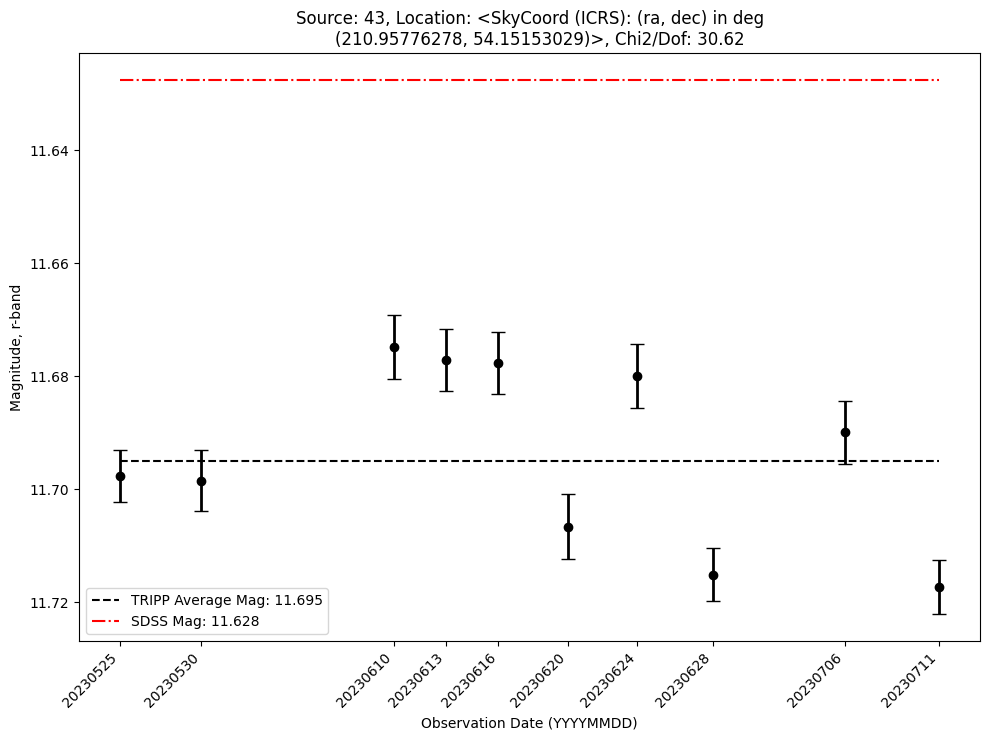

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.97193498, 54.36827617)>, Night_0_xy: (array(654.91172846), array(714.01153167)) rad: 3.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.207463242783, cal_mag_avg: 16.845670596367047, flagged: False, ID: 44, Chi2: None
None
[0.10532535261208587, 0.1072969216374621, 0.16330033711329853, 0.16054566560009959, 0.1589203107607081, 0.16374486736417515, 0.16234075537042267, 0.08528693694960805, 0.18122538018030182, 0.14330879690877796]


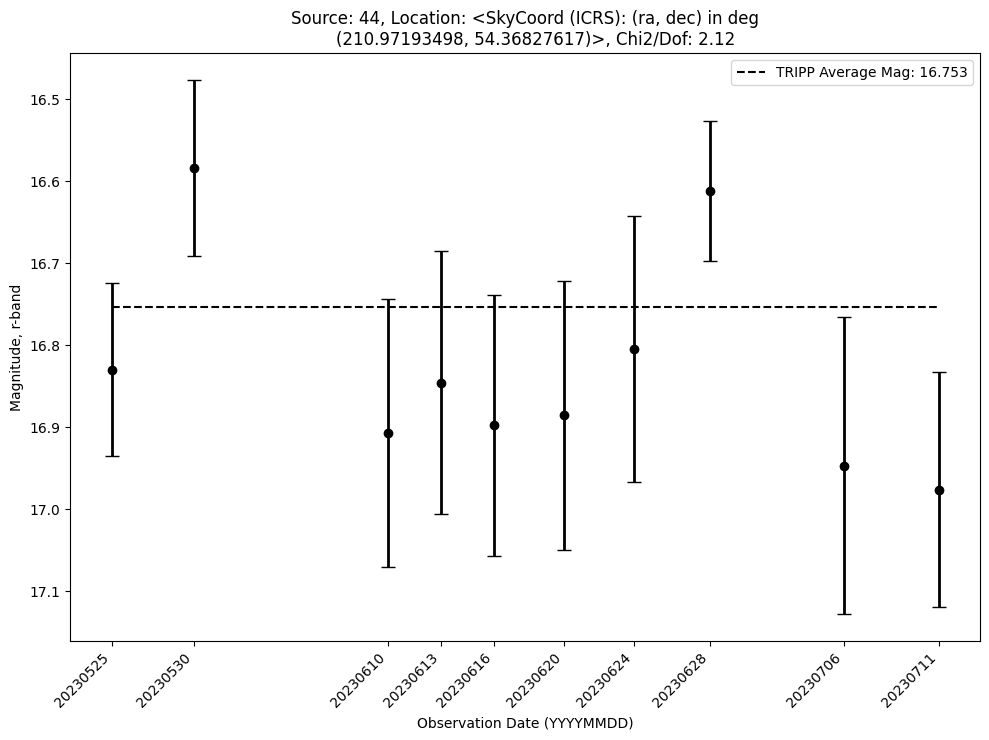

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.97523909, 54.36934526)>, Night_0_xy: (array(647.91358444), array(726.00525475)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.892411796792839, cal_mag_avg: 16.183880563008177, flagged: False, ID: 45, Chi2: None
None
[0.09754469754036645, 0.08555447838172468, 0.14942262251627783, 0.14324028133017297, 0.13277838089068889, 0.1630956349202836, 0.14495551203044388, 0.07356651775330432, 0.15876210872689783, 0.1136648574272497]


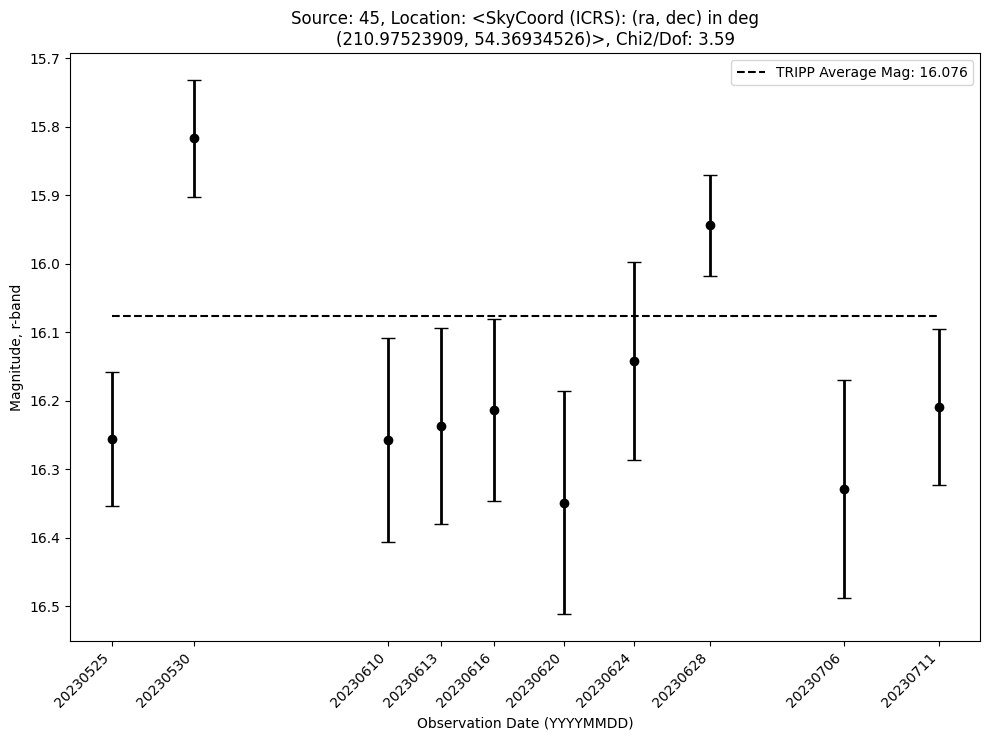

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.98336712, 54.34931789)>, Night_0_xy: (array(773.55471747), array(758.55544589)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.8106342163754, cal_mag_avg: 16.263392863827214, flagged: False, ID: 46, Chi2: None
None
[0.05266843276067807, 0.06465890666078673, 0.07714855356126459, 0.08094076152417426, 0.08007231896726644, 0.0834000298145798, 0.08921841226163758, 0.05047316074603962, 0.08593369271565908, 0.07361666400772968]


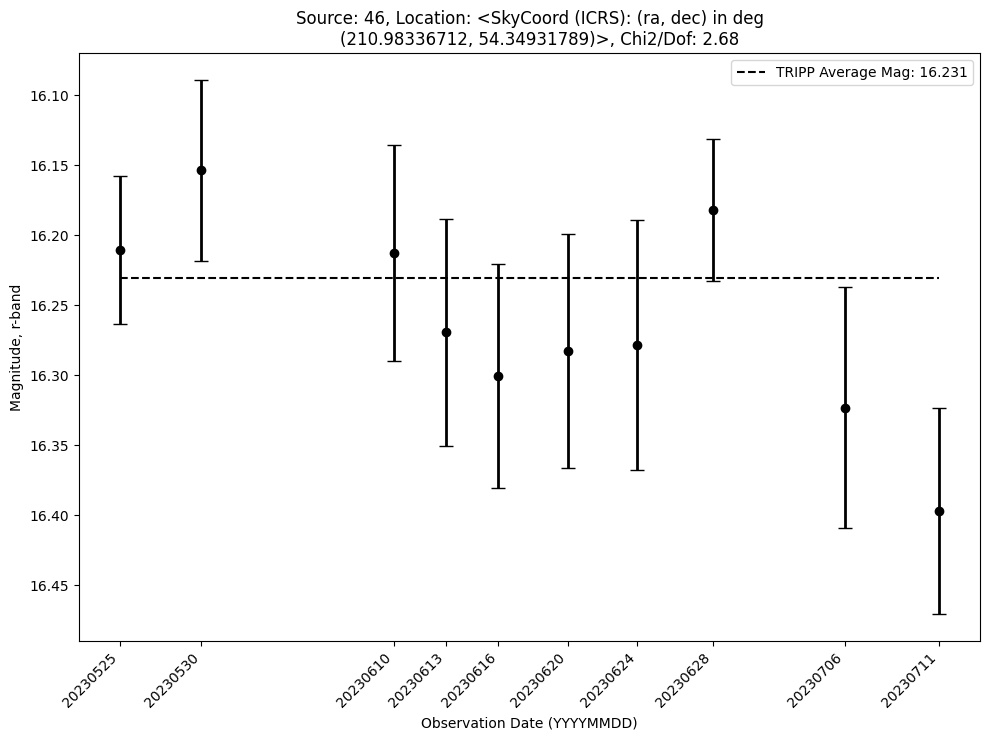

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01134848, 54.30502921)>, Night_0_xy: (array(1050.58582799), array(867.45424938)) rad: 7.0, ref_status: None, ref_mag: None, inst_mag_avg:-10.729743291058416, cal_mag_avg: 13.443679023305974, flagged: False, ID: 47, Chi2: None
None
[0.011739994835148261, 0.01415528684267626, 0.014929789007476326, 0.014709998043702098, 0.014838840504738375, 0.015418177119611083, 0.015561720093552936, 0.011583439405657144, 0.015226209114394495, 0.012427354633796949]


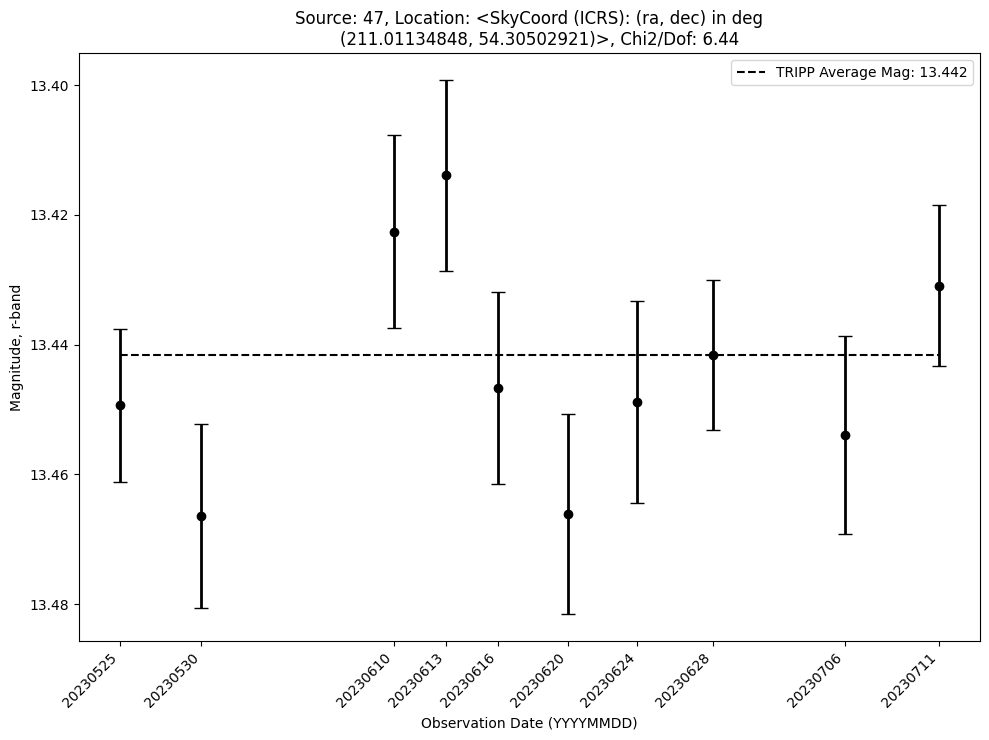

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01156344, 54.16910002)>, Night_0_xy: (array(1907.61742019), array(886.87719551)) rad: 4.0, ref_status: True, ref_mag: psfMag_r
--------
15.32855, inst_mag_avg:-8.607084077752264, cal_mag_avg: 15.494282000412456, flagged: False, ID: 48, Chi2: None
None
[0.037571686584391854, 0.04465399813341158, 0.05104096748787731, 0.051106634623400364, 0.051920067157431186, 0.0545694445932242, 0.057805021007819916, 0.03528636350232534, 0.05512030861469255, 0.046045106511462354]


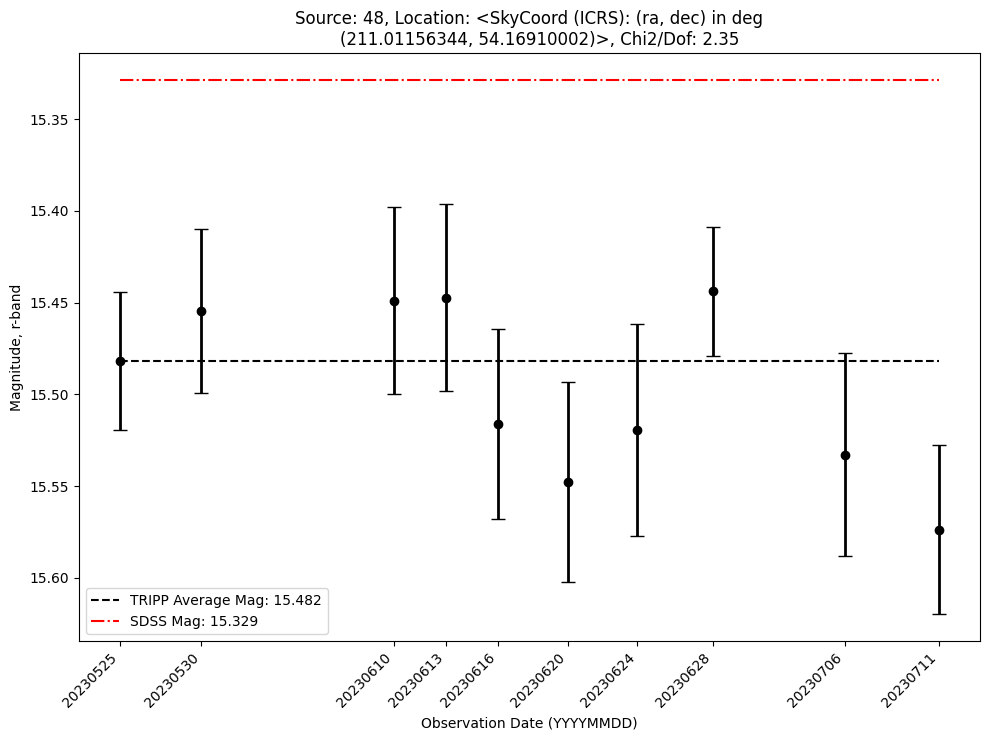

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.00453763, 53.98887093)>, Night_0_xy: (array(3044.55505951), array(885.53658331)) rad: 5.5, ref_status: True, ref_mag: psfMag_r
--------
  14.504, inst_mag_avg:-10.399642045585173, cal_mag_avg: 13.762427090696224, flagged: False, ID: 49, Chi2: None
None
[0.0123444452175677, 0.014976297057721827, 0.016345503777272008, 0.016085050415762678, 0.015964071075360103, 0.016154400408996922, 0.017004186425768574, 0.012178769908839652, 0.01584329449819456, 0.01312592832411189]


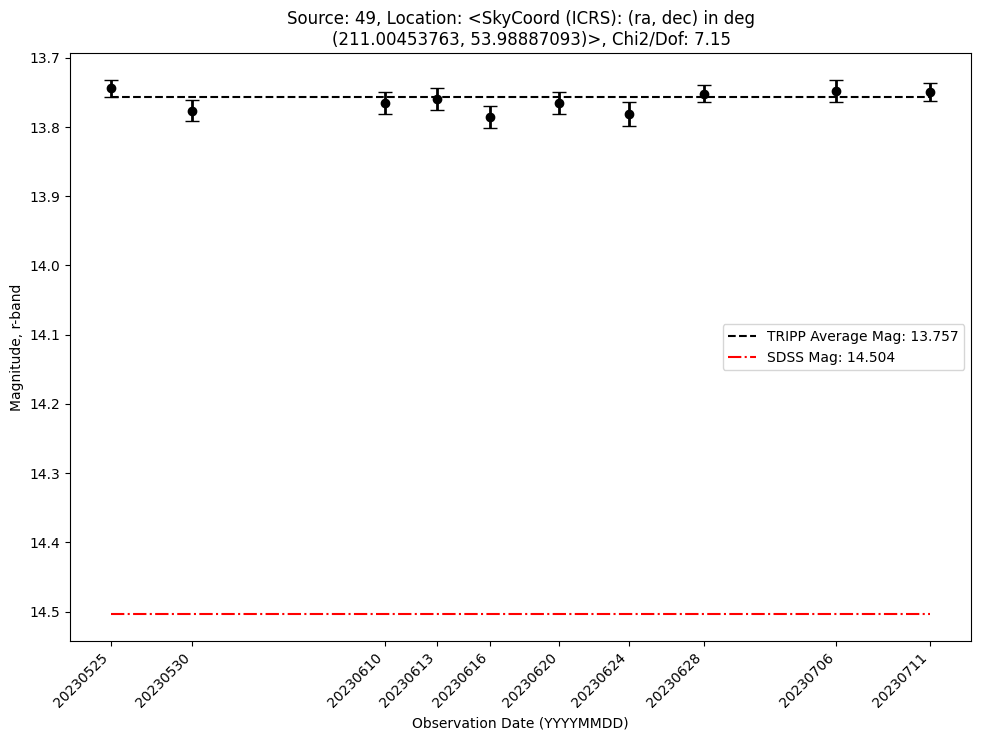

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.01841136, 54.22552572)>, Night_0_xy: (array(1551.29709406), array(904.38379271)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.015357409720975, cal_mag_avg: 13.167806787505, flagged: False, ID: 50, Chi2: None
None
[0.009149765427604224, 0.010805187054584714, 0.011104811436388905, 0.011009595275674843, 0.011130316401396253, 0.011570420695204992, 0.011711377293085159, 0.00912023390655175, 0.011427834163372844, 0.00979569627732902]


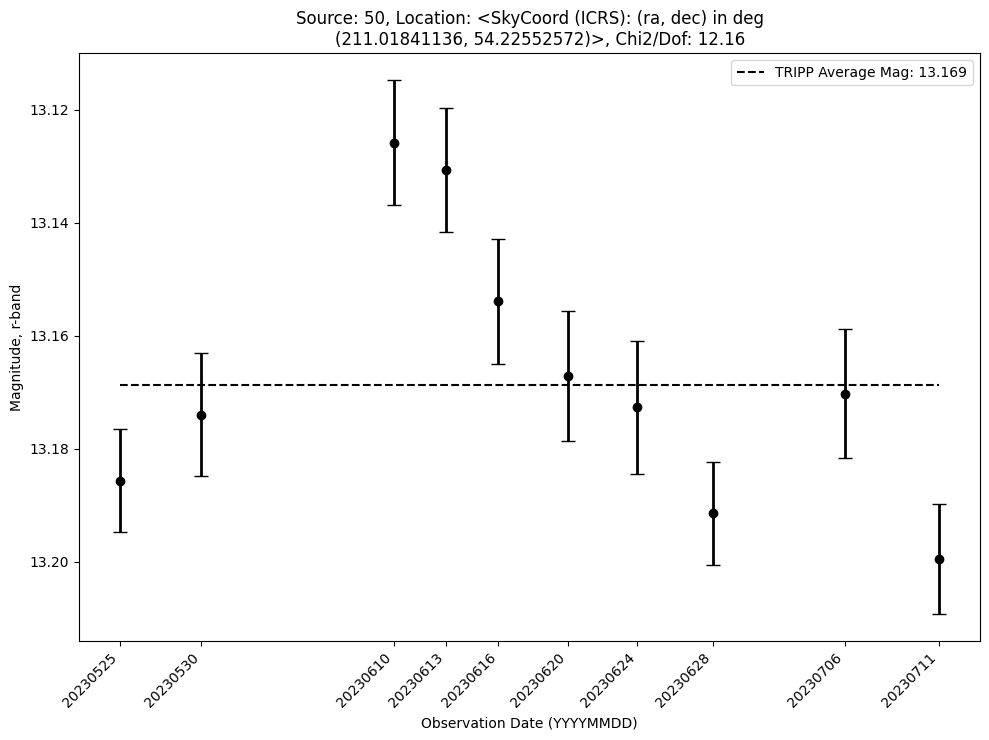

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.03006488, 54.35204566)>, Night_0_xy: (array(752.63706316), array(929.78644028)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.481695804343858, cal_mag_avg: 15.615370251520856, flagged: False, ID: 51, Chi2: None
None
[0.04164070981218628, 0.04750851276126229, 0.05591160489274446, 0.05987434544703151, 0.057961912733628176, 0.060103366484968584, 0.0627763013596473, 0.03826623379604853, 0.0610483560590376, 0.05047379576526115]


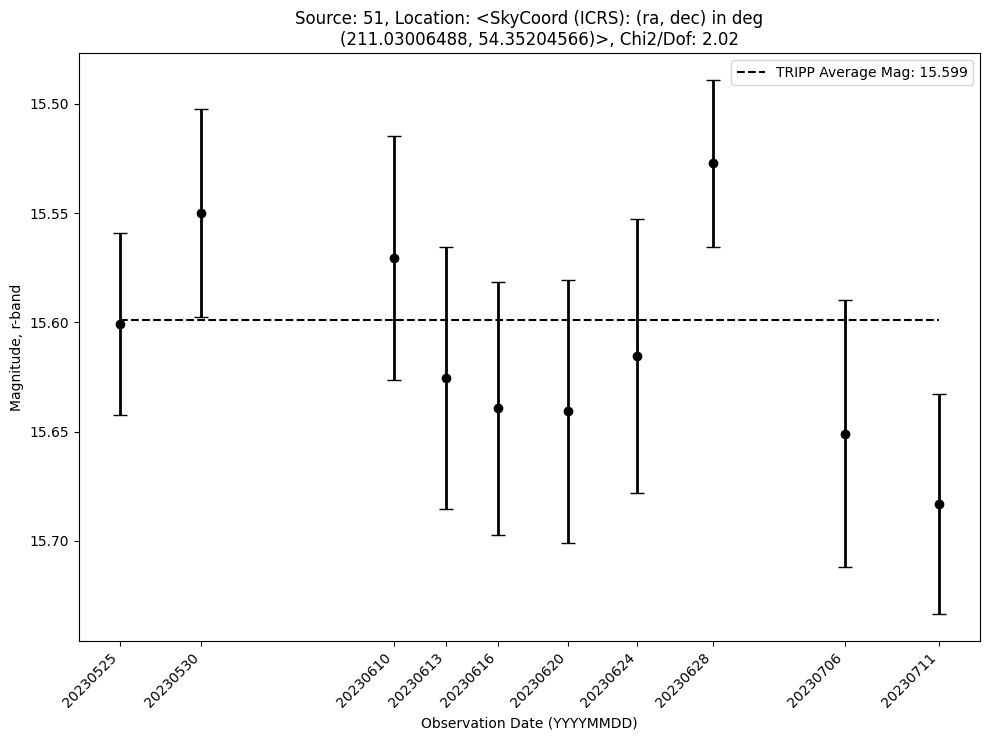

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.04682416, 54.42158107)>, Night_0_xy: (array(312.8479724), array(981.61997602)) rad: 4.5, ref_status: None, ref_mag: None, inst_mag_avg:-7.67956916236439, cal_mag_avg: 16.389730485354402, flagged: False, ID: 52, Chi2: None
None
[0.09620764131889534, 0.08930669205241468, 0.1427911749401572, 0.13917830757573796, 0.13510436993117245, 0.14090364334680636, 0.14503606921804552, 0.07348295461834058, 0.15849742604453593, 0.11126329822258968]


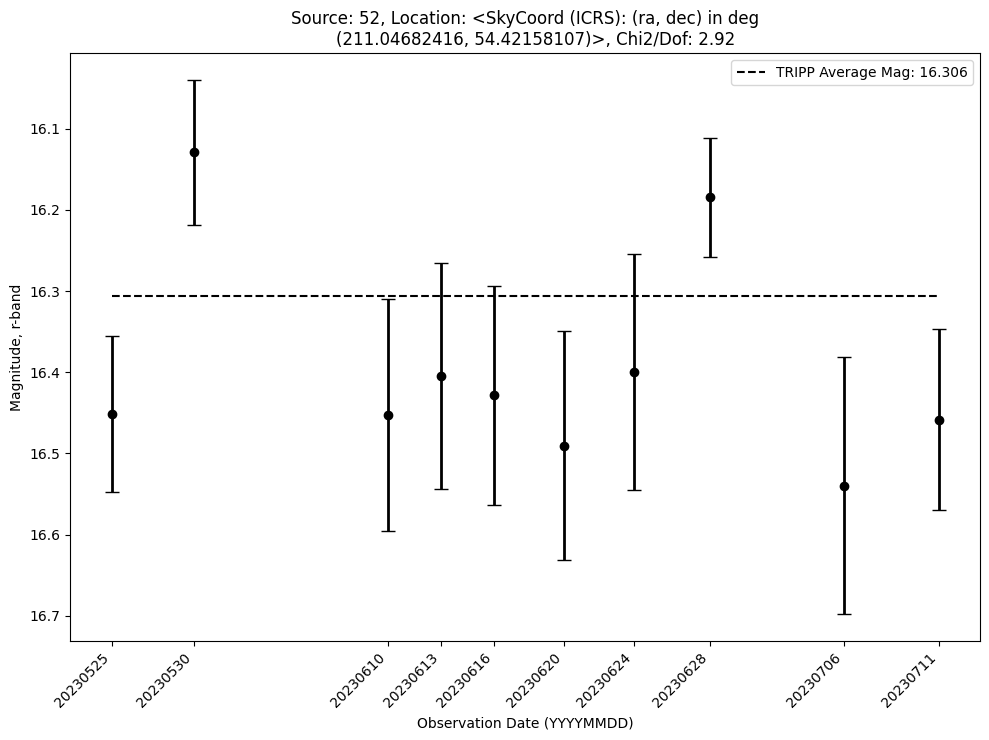

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.03188549, 54.00407838)>, Night_0_xy: (array(2946.45581117), array(984.80473159)) rad: 4.5, ref_status: True, ref_mag: psfMag_r
--------
14.47984, inst_mag_avg:-9.49834656530069, cal_mag_avg: 14.633269642120887, flagged: False, ID: 53, Chi2: None
None
[0.02076544373677492, 0.02522762178994681, 0.02819455014023673, 0.028166721202833988, 0.027752929658768476, 0.027971625655385385, 0.029330541190931567, 0.020193136682953125, 0.027982840889126163, 0.022657989908683875]


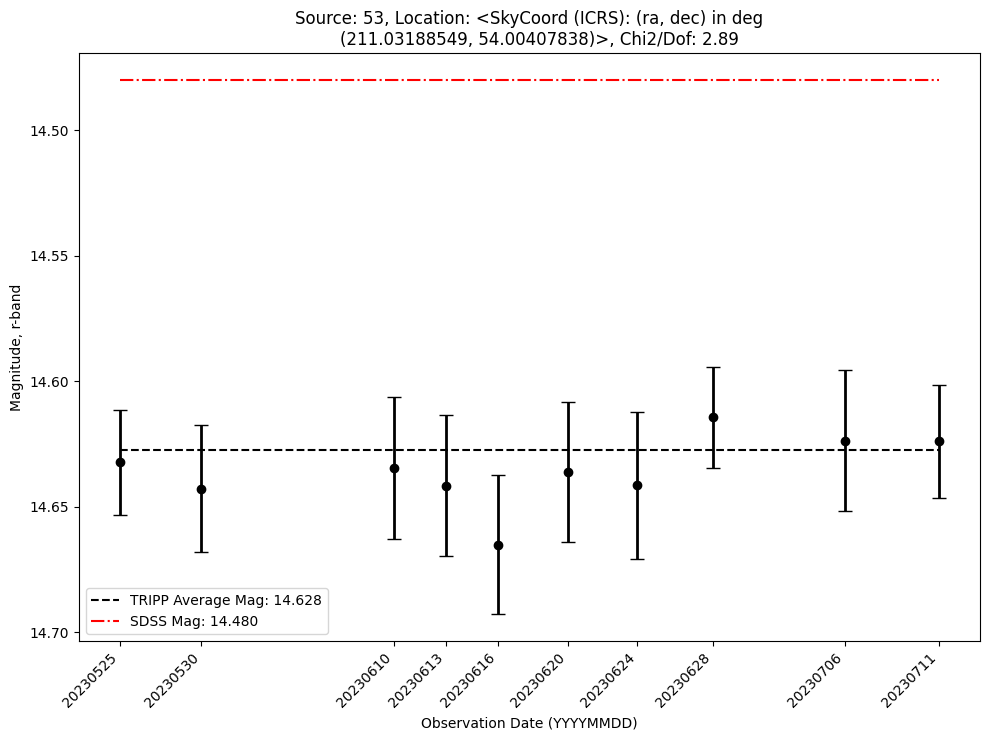

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.05144253, 54.23152052)>, Night_0_xy: (array(1510.81258582), array(1025.29087007)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.402881386806246, cal_mag_avg: 16.65683101801506, flagged: False, ID: 54, Chi2: None
None
[0.07525826130876866, 0.08062778029335942, 0.10653564067032309, 0.10951354702201198, 0.10919927390639622, 0.13355052854199548, 0.12698183738265506, 0.06342214072028933, 0.12229020658942323, 0.11968167943474835]


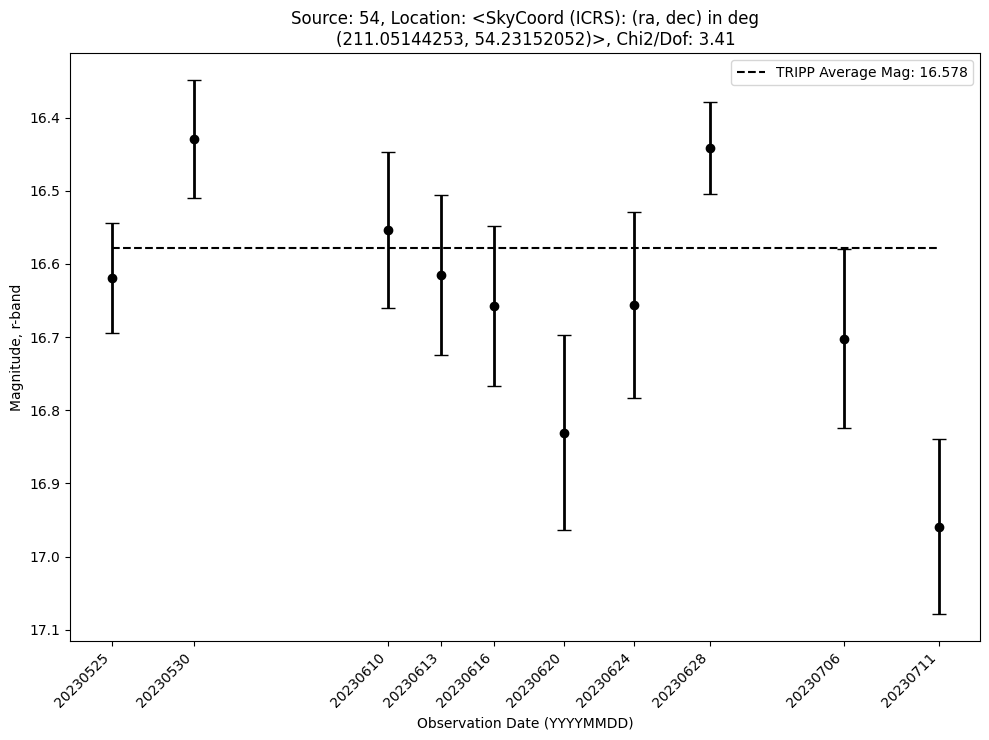

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.04809302, 53.9938326)>, Night_0_xy: (array(3009.72695159), array(1046.3025651)) rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
15.95399, inst_mag_avg:-7.9063332475266055, cal_mag_avg: 16.17065527711841, flagged: False, ID: 55, Chi2: None
None
[0.04789285489007868, 0.060128842409745316, 0.07606874819644326, 0.07882793174677619, 0.07421908618973402, 0.07614575827087411, 0.08234893590315041, 0.0448131555611103, 0.07601216352159466, 0.06061045255782186]


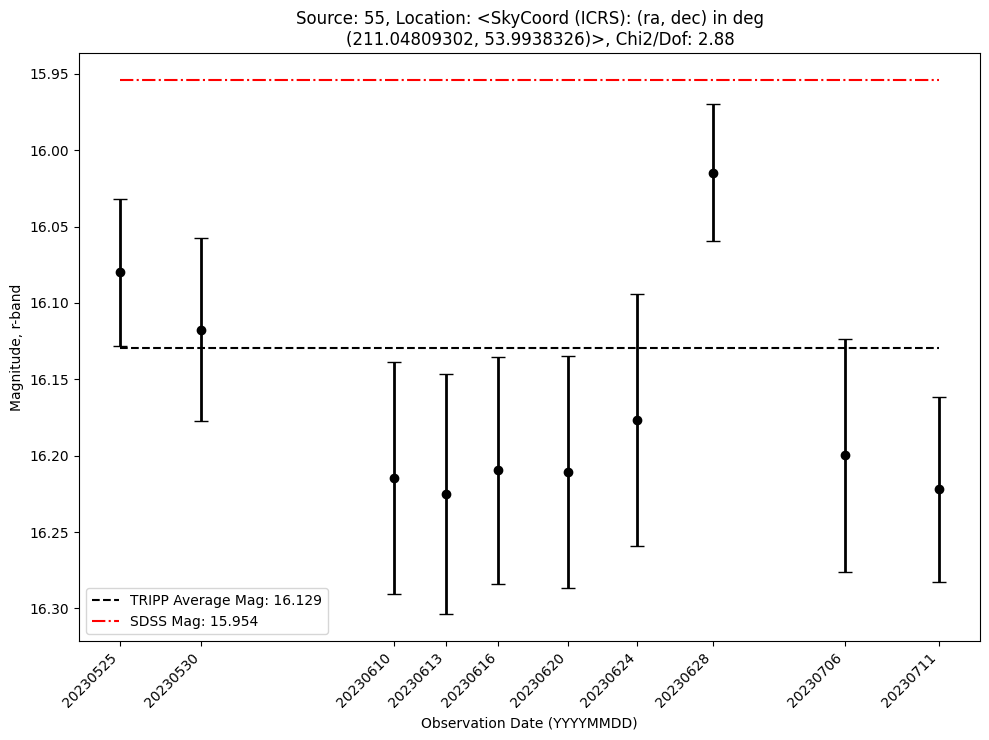

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.0674882, 54.42881879)>, Night_0_xy: (array(265.51666725), array(1056.39543121)) rad: 5.5, ref_status: True, ref_mag: psfMag_r
--------
 23.4499, inst_mag_avg:-9.983060278108915, cal_mag_avg: 14.165219270237689, flagged: False, ID: 56, Chi2: None
None
[0.017209006777605083, 0.020264639694066843, 0.02202810633950534, 0.022001844948687975, 0.021728945018152986, 0.02252534923185858, 0.023331911021100146, 0.016733506801511717, 0.022485897750114205, 0.018590943358572625]


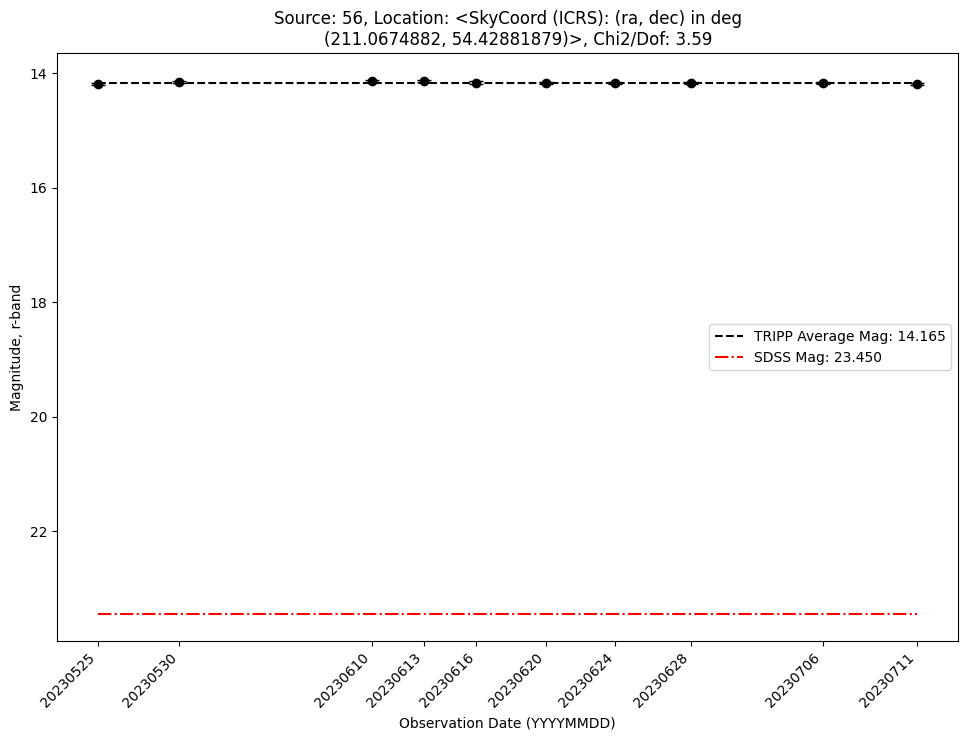

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.06828153, 54.39069706)>, Night_0_xy: (array(505.81082275), array(1064.72367881)) rad: 4.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.140980225338044, cal_mag_avg: 15.94445130114149, flagged: False, ID: 57, Chi2: None
None
[0.05437058687472681, 0.06112556902009703, 0.07960656597901083, 0.08082757074733589, 0.07784156551904041, 0.08095566499036214, 0.08463251243059733, 0.05038775249514624, 0.08402163246470143, 0.06429363958926348]


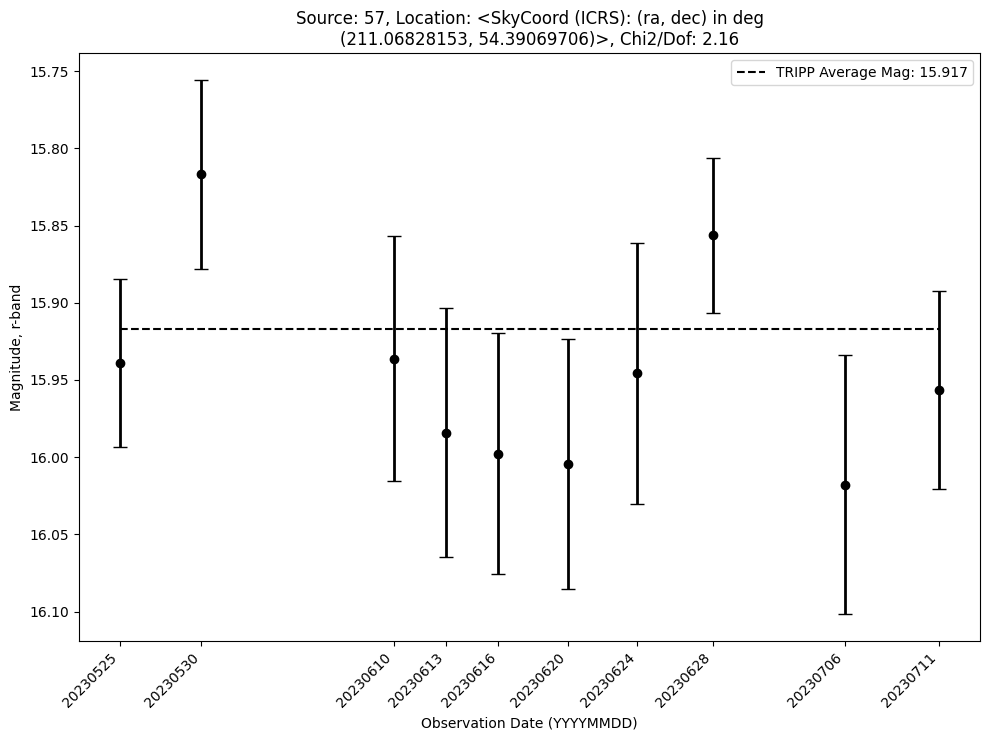

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.06442548, 54.00816578)>, Night_0_xy: (array(2918.0003744), array(1104.8077158)) rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
 13.2153, inst_mag_avg:-10.892161162074272, cal_mag_avg: 13.286763372417052, flagged: False, ID: 58, Chi2: None
None
[0.01042929151885368, 0.012527026307657918, 0.013384322133660123, 0.01311597291885712, 0.013056734796252516, 0.013296826351597204, 0.013743560683481721, 0.010344543870755885, 0.01314336017292296, 0.01098440279224836]


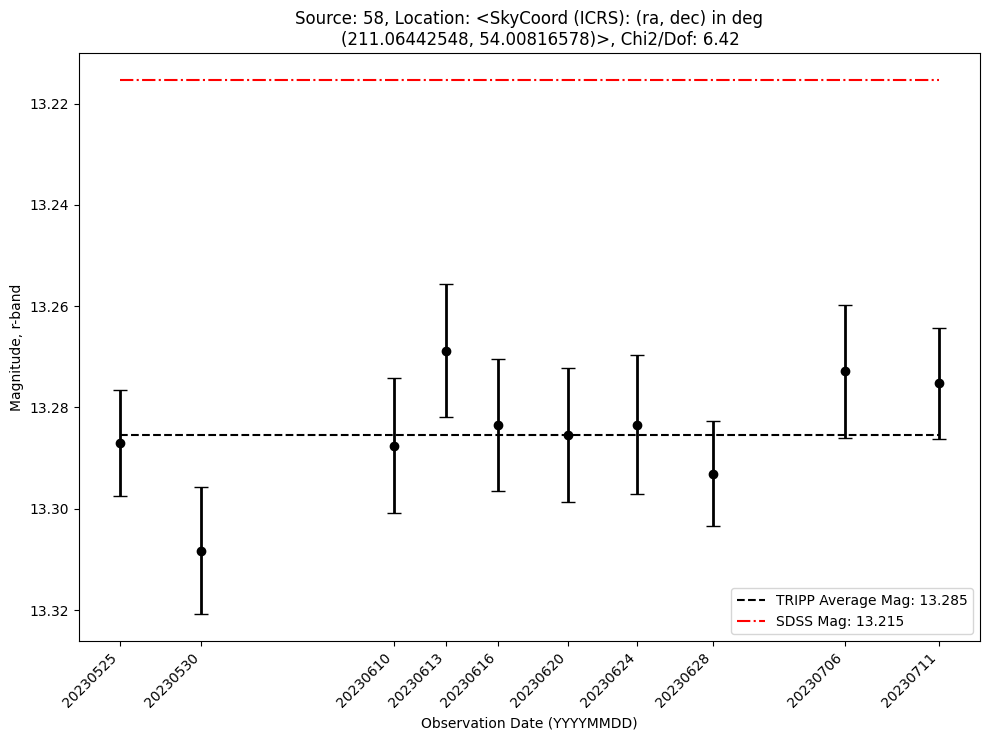

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.08497635, 54.39021174)>, Night_0_xy: (array(507.48182709), array(1126.08205042)) rad: 6.5, ref_status: None, ref_mag: None, inst_mag_avg:-10.419584529491523, cal_mag_avg: 13.743560595059426, flagged: False, ID: 59, Chi2: None
None
[0.014255375463051619, 0.016641665988352004, 0.017779487794889536, 0.017618937965465174, 0.017493484697012267, 0.01840800674027439, 0.018636383963025995, 0.014052420150249142, 0.01821842387236066, 0.01504579969329433]


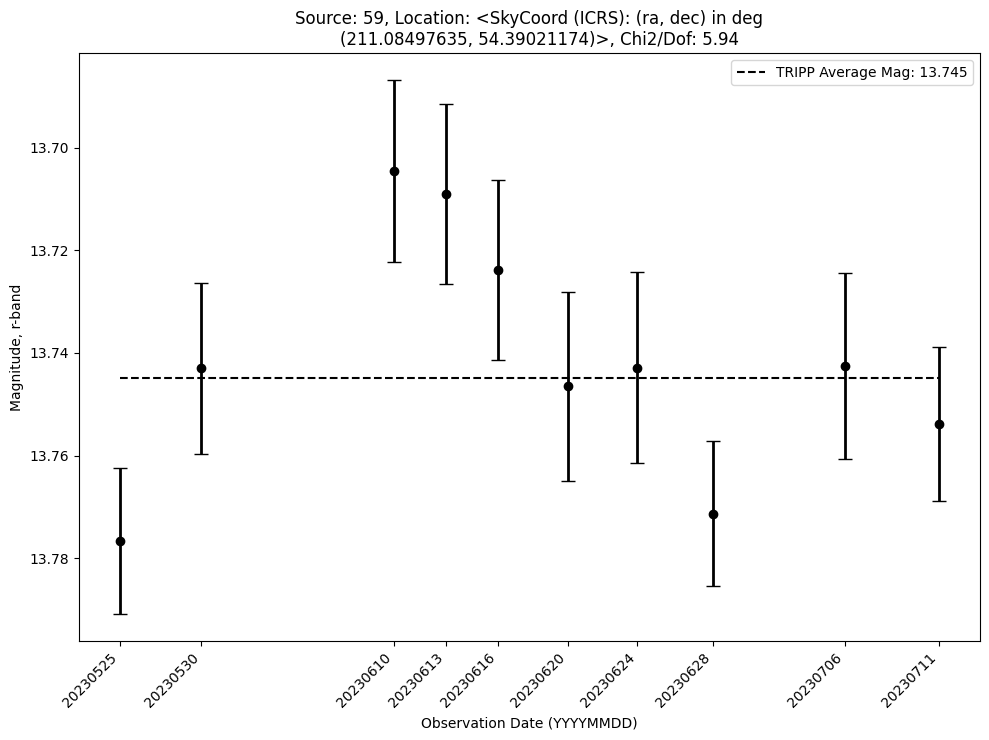

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.09030766, 54.32292807)>, Night_0_xy: (array(931.2577035), array(1155.34993979)) rad: 10.5, ref_status: None, ref_mag: None, inst_mag_avg:-12.338076983685161, cal_mag_avg: 11.889664578755387, flagged: False, ID: 60, Chi2: None
None
[0.005021824904657308, 0.005887696882876624, 0.006075824726215959, 0.00591558201485986, 0.005980057594501768, 0.0061364375180157586, 0.006141978070242883, 0.005067767425017778, 0.006067557458500039, 0.005135148056424956]


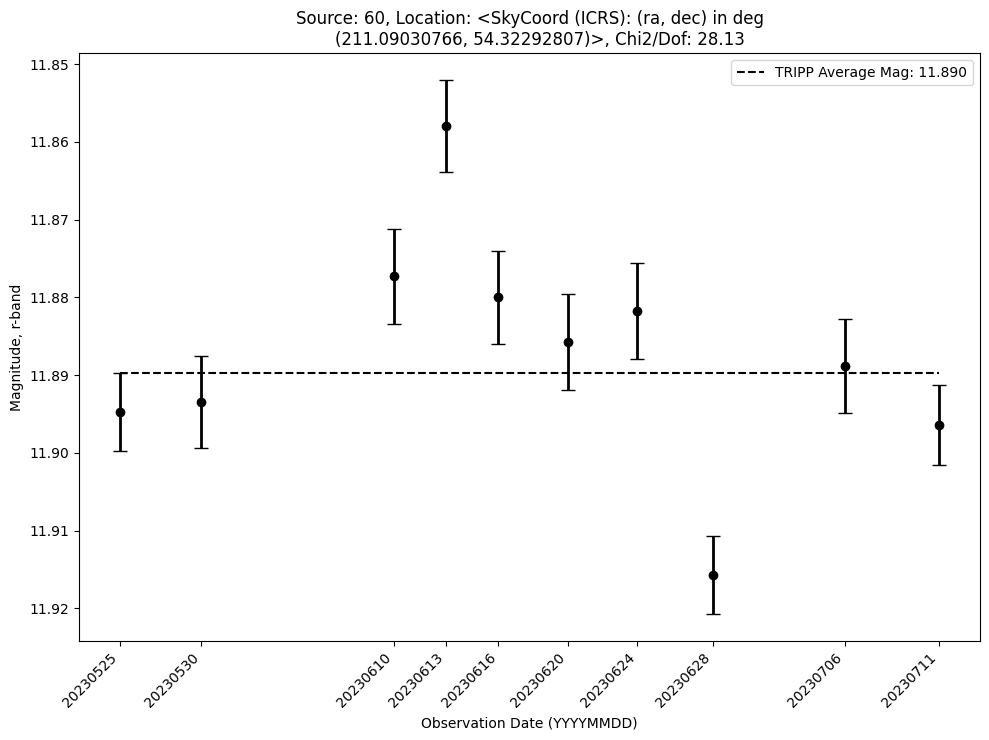

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12029174, 54.39706644)>, Night_0_xy: (array(461.27735582), array(1254.72342568)) rad: 7.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.154807221825497, cal_mag_avg: 14.964116330048006, flagged: False, ID: 61, Chi2: None
None
[0.0420831968954044, 0.046967369247061845, 0.06598990539363137, 0.06440796499534183, 0.0631517953062238, 0.07056556879245765, 0.06597484574180529, 0.037395996919499824, 0.0722172722232948, 0.04657967253017718]


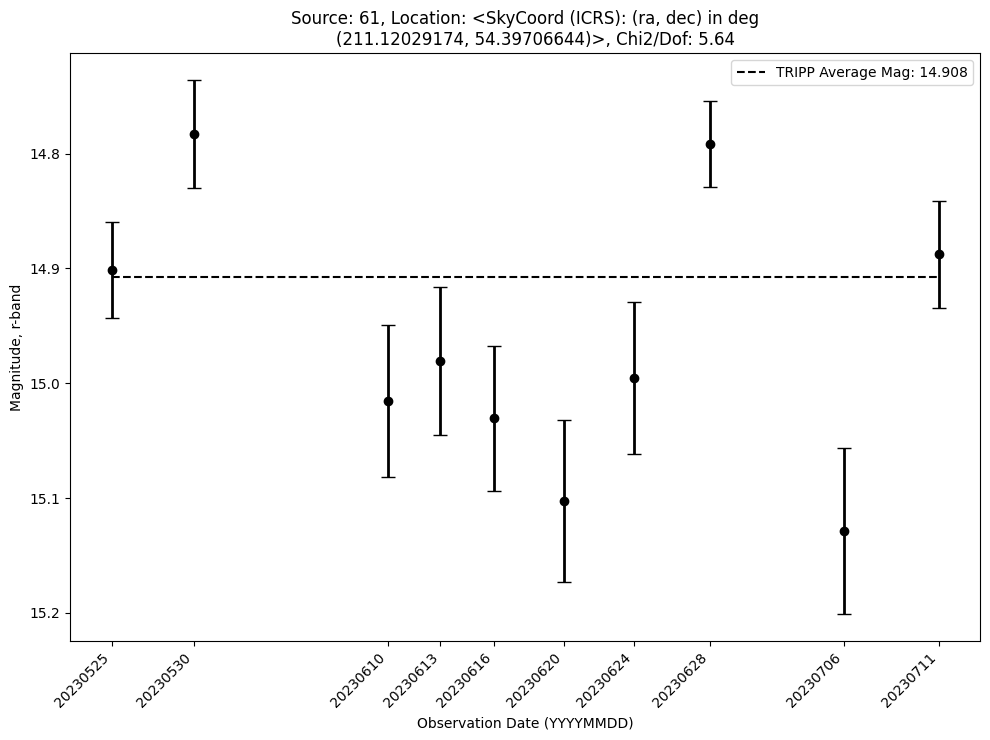

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12236698, 54.396411)>, Night_0_xy: (array(465.23239558), array(1262.43695154)) rad: 8.5, ref_status: None, ref_mag: None, inst_mag_avg:-9.31150599385082, cal_mag_avg: 14.812928741063118, flagged: False, ID: 62, Chi2: None
None
[0.04367978492232648, 0.04927404528940085, 0.06905226941660797, 0.06361346250719888, 0.06287361110313829, 0.07016813415021854, 0.06514434792538078, 0.03656009327732997, 0.06904053274643451, 0.04614416143277897]


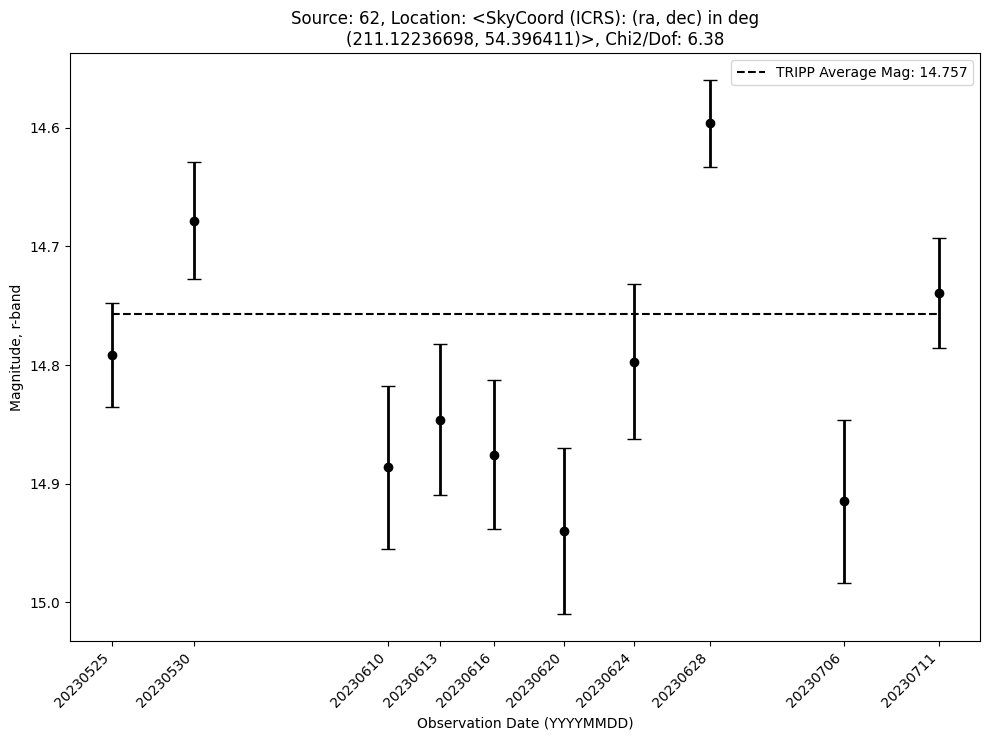

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12181666, 54.39800484)>, Night_0_xy: (array(455.23040772), array(1260.18279112)) rad: 5.5, ref_status: None, ref_mag: None, inst_mag_avg:-8.065135996792778, cal_mag_avg: 16.01670584617504, flagged: False, ID: 63, Chi2: None
None
[0.07778453400156916, 0.07580791348368428, 0.1286542487444508, 0.11946459078999733, 0.11465260841714629, 0.14050295464634016, 0.12388892292183401, 0.06463595805748085, 0.14783218466727163, 0.08612353497963761]


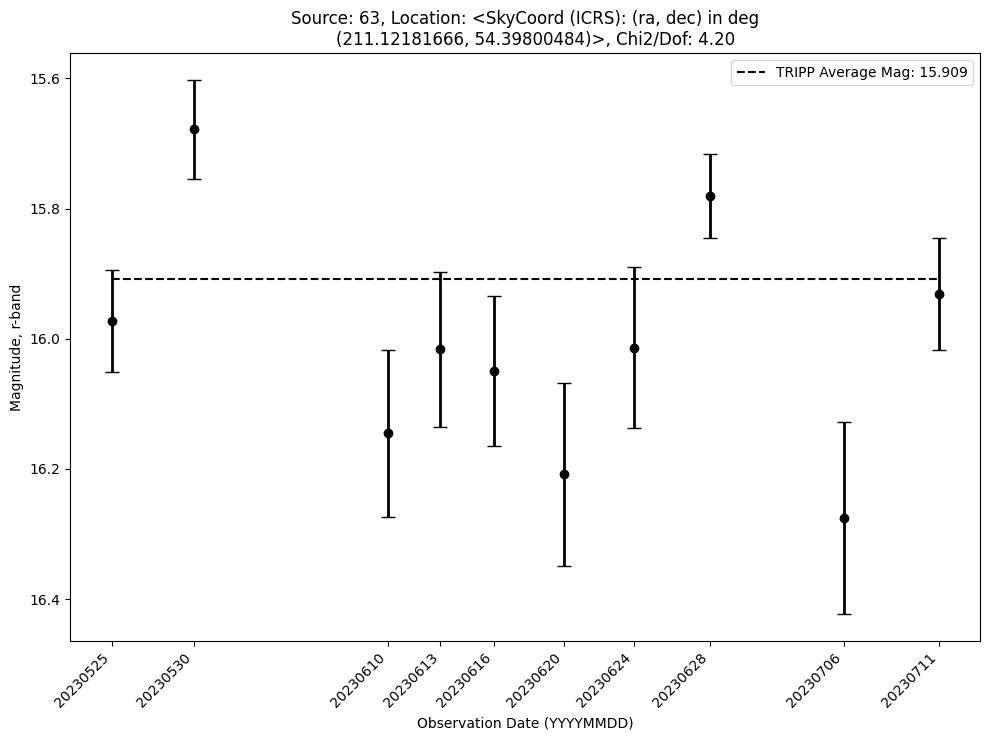

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12521481, 54.25972344)>, Night_0_xy: (array(1326.79033093), array(1293.01320903)) rad: 3.0, ref_status: None, ref_mag: None, inst_mag_avg:-7.7987343438905885, cal_mag_avg: 16.274796691559867, flagged: False, ID: 64, Chi2: None
None
[0.05266506892304908, 0.062279220461779326, 0.07440267598477165, 0.07836532091681975, 0.08263730848578053, 0.08223817736059436, 0.08821656670092853, 0.050258457297191625, 0.08436093788757049, 0.07819740770521783]


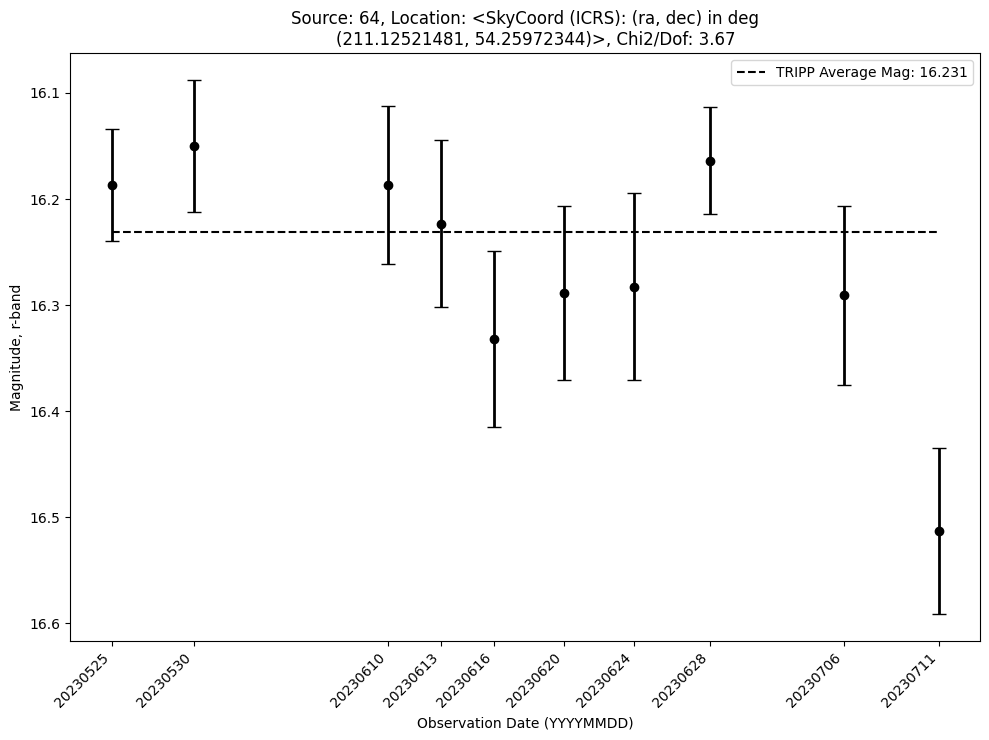

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.12054456, 54.08428834)>, Night_0_xy: (array(2433.29242035), array(1301.56819367)) rad: 5.0, ref_status: True, ref_mag: psfMag_r
--------
14.16824, inst_mag_avg:-9.856562711281379, cal_mag_avg: 14.287300141082127, flagged: False, ID: 65, Chi2: None
None
[0.01715622877058243, 0.0208198056025147, 0.022565166844448124, 0.022558851525378877, 0.022243077617784376, 0.022844406121566383, 0.02407875332631547, 0.017221945738229816, 0.02294489844304745, 0.018833034910230997]


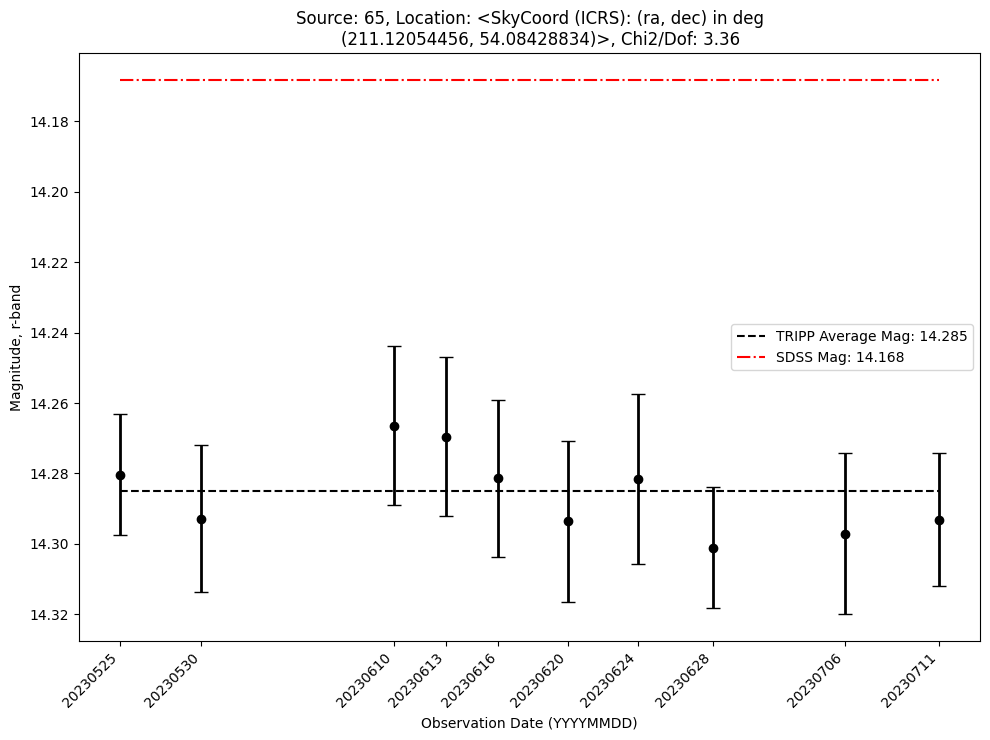

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.17529361, 54.35187118)>, Night_0_xy: (array(741.44612819), array(1463.46187157)) rad: 9.5, ref_status: None, ref_mag: None, inst_mag_avg:-11.992600512493294, cal_mag_avg: 12.223625672555569, flagged: False, ID: 66, Chi2: None
None
[0.006037867330696644, 0.006995736852283373, 0.007257211759235905, 0.007062778300701326, 0.007057279796984264, 0.007368097605442658, 0.0072990825328668315, 0.006040402869179408, 0.0072017452866708475, 0.006181417287699962]


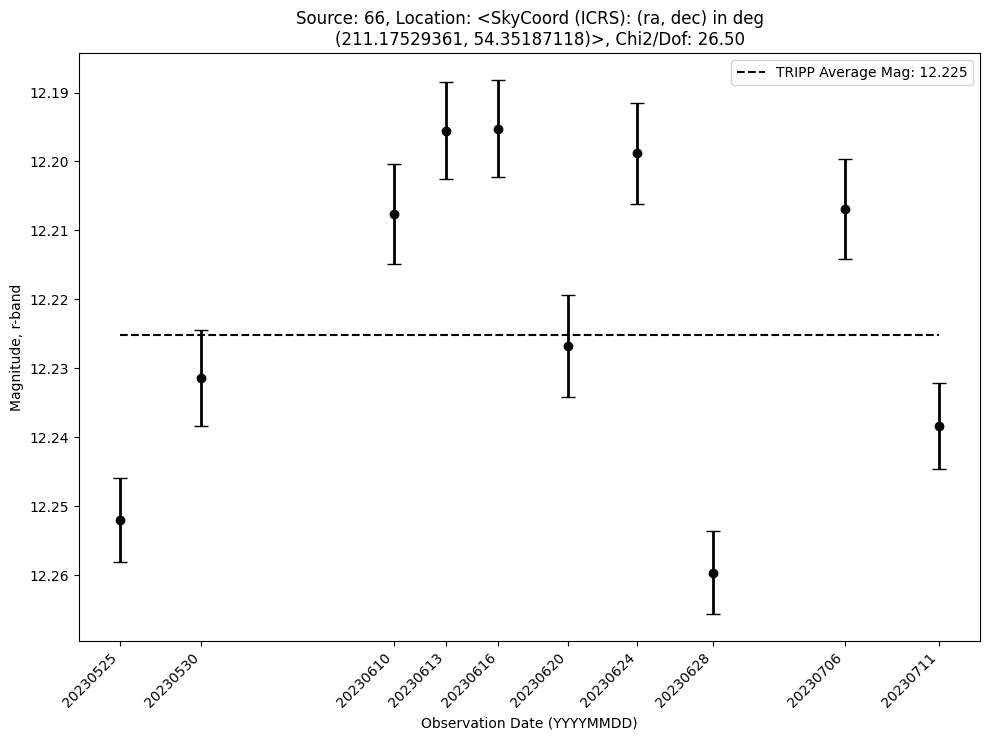

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.21211591, 54.19464639)>, Night_0_xy: (array(1729.41176812), array(1623.13008889)) rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
 15.9441, inst_mag_avg:-7.995681454077352, cal_mag_avg: 16.08474812103579, flagged: False, ID: 67, Chi2: None
None
[0.05408218800511094, 0.060820236149905484, 0.07779304575392096, 0.07561581268011411, 0.07667605965963208, 0.08047199242443356, 0.08296330868790049, 0.04881542972539732, 0.08376599480769736, 0.07075640450025412]


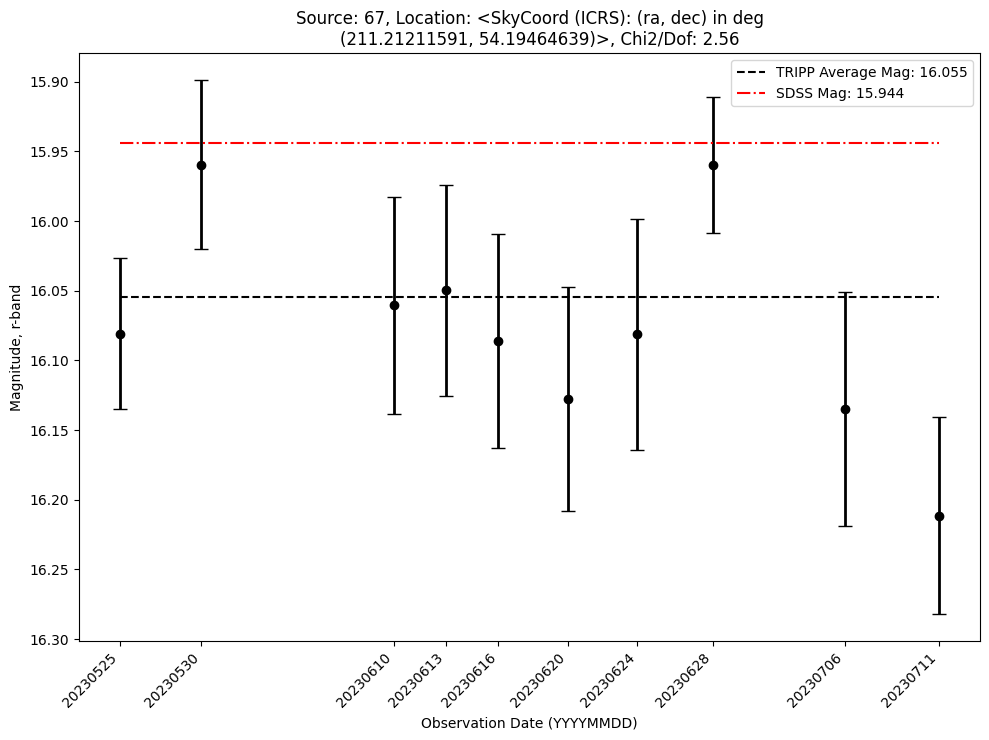

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.231828, 54.40298931)>, Night_0_xy: (array(414.07962572), array(1663.18185372)) rad: 5.0, ref_status: None, ref_mag: None, inst_mag_avg:-8.050315613462969, cal_mag_avg: 16.031554602173507, flagged: False, ID: 68, Chi2: None
None
[0.07375322548304432, 0.0760198856933384, 0.11246866603634528, 0.11380679836363217, 0.10763526171311043, 0.12469748767955668, 0.11198246912116222, 0.060263907630505764, 0.1185216779843886, 0.08549648322803793]


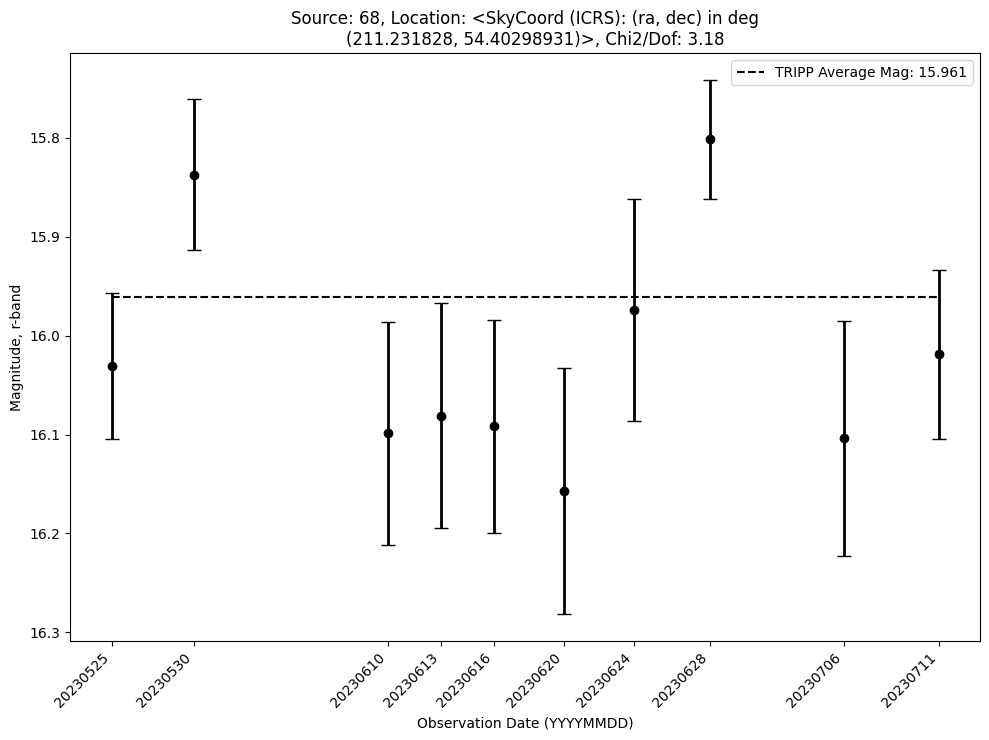

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.23332181, 54.22956903)>, Night_0_xy: (array(1507.30210982), array(1695.86873797)) rad: 2.5, ref_status: True, ref_mag: psfMag_r
--------
16.59565, inst_mag_avg:-7.200465083117506, cal_mag_avg: 16.85273988160569, flagged: False, ID: 69, Chi2: None
None
[0.07267370675243869, 0.08039981756253851, 0.10761383513644765, 0.11399190999710279, 0.1092290440688218, 0.11751187653732158, 0.121150063446263, 0.0686862684997199, 0.11710646954083129, 0.12679996157059378]


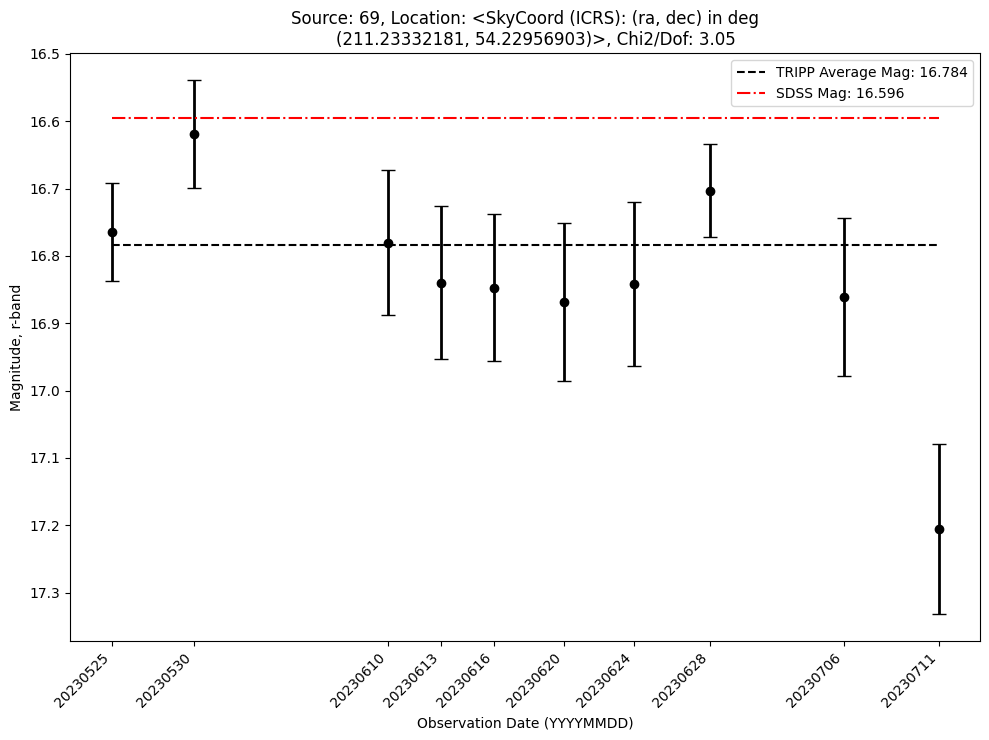

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.25972667, 54.33924396)>, Night_0_xy: (array(813.40500506), array(1775.71531984)) rad: 7.0, ref_status: True, ref_mag: psfMag_r
--------
13.37774, inst_mag_avg:-10.715555925670847, cal_mag_avg: 13.457510389516004, flagged: False, ID: 70, Chi2: None
None
[0.012178517851130314, 0.014145948782143503, 0.015076218400858838, 0.015048721468227621, 0.014783699009169152, 0.01524085087084631, 0.015655615670026168, 0.011770270138893011, 0.01512291241440895, 0.01277097899731025]


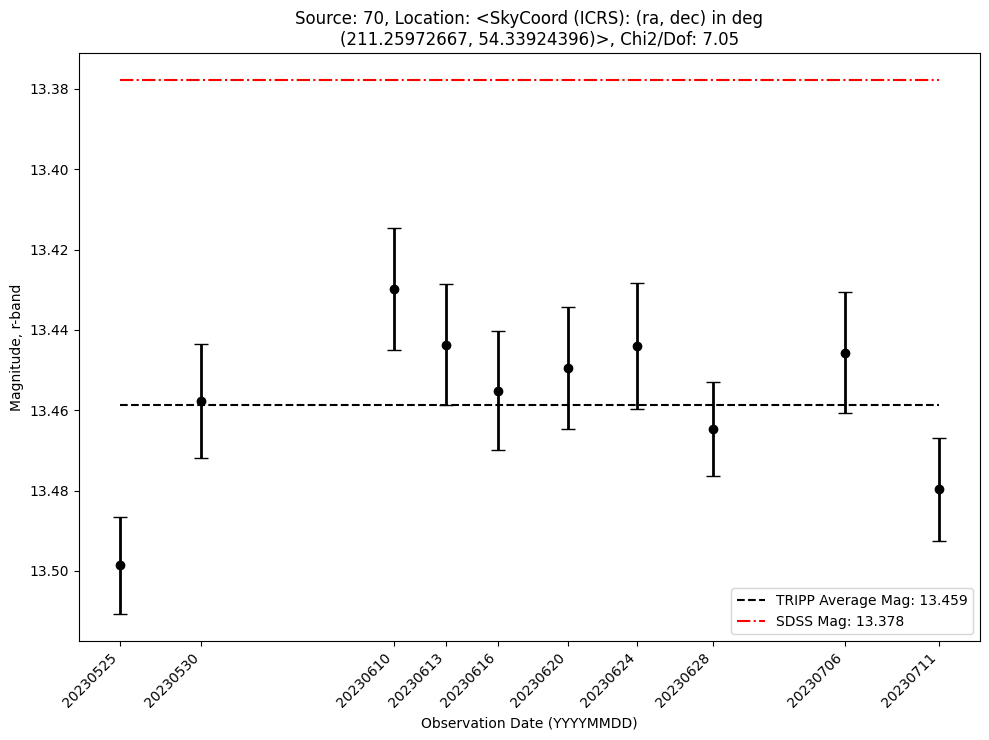

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.27877934, 54.05855765)>, Night_0_xy: (array(2581.23473141), array(1890.91430982)) rad: 21.0, ref_status: True, ref_mag: psfMag_r
--------
9.829223, inst_mag_avg:-14.468434962115971, cal_mag_avg: 9.830744213177555, flagged: False, ID: 71, Chi2: None
None
[0.0018857296639571697, 0.0021666138288441027, 0.0022069451420368294, 0.0021681773043463093, 0.002190088700236849, 0.0022149064164011015, 0.002185648902438793, 0.001853539980008426, 0.0021629057418174444, 0.001849850149921928]


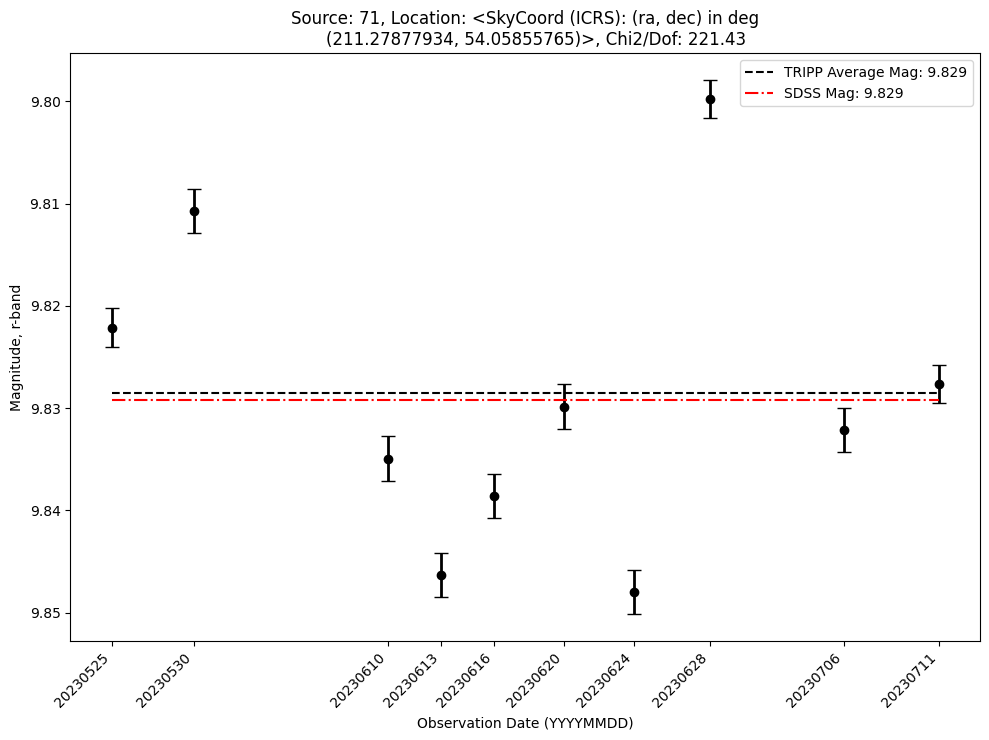

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30345384, 54.41397668)>, Night_0_xy: (array(338.13912272), array(1924.2420311)) rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.35447, inst_mag_avg:-7.562738575000405, cal_mag_avg: 16.502847840347755, flagged: False, ID: 72, Chi2: None
None
[0.06799989280751063, 0.0720488228608456, 0.10283821108092286, 0.10207701481267767, 0.09539185534958962, 0.10888328104533472, 0.10899122334554626, 0.0598109432932877, 0.10441320219489174, 0.08471755189347617]


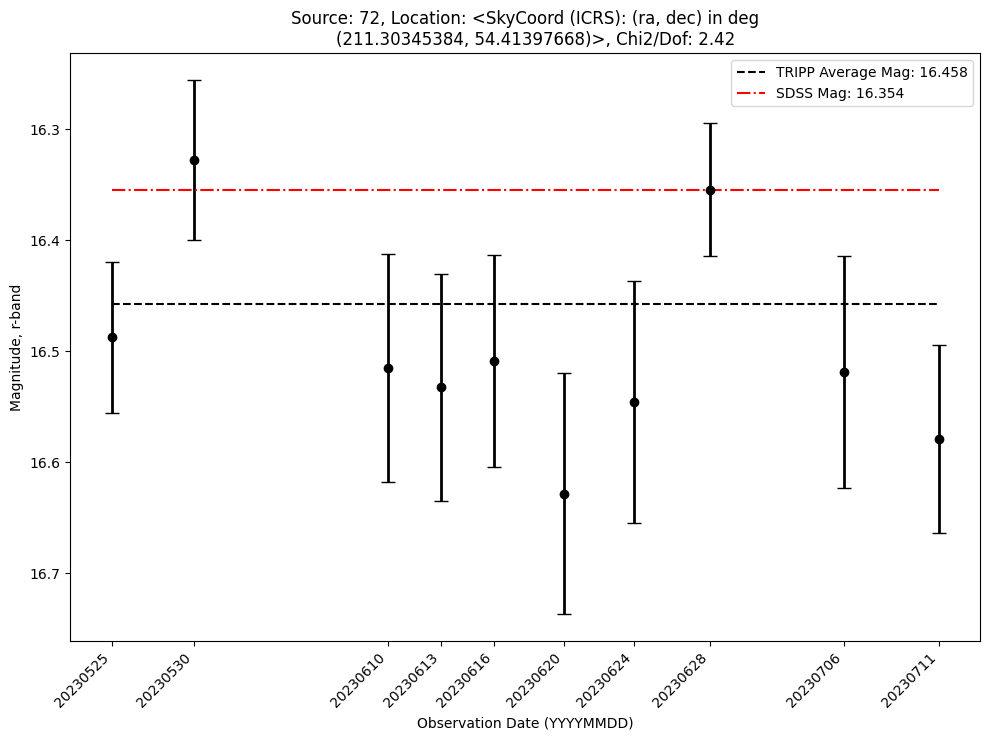

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.29844756, 54.26495767)>, Night_0_xy: (array(1278.11113347), array(1930.11858065)) rad: 3.0, ref_status: True, ref_mag: psfMag_r
--------
16.35837, inst_mag_avg:-7.56361191583238, cal_mag_avg: 16.501814836028572, flagged: False, ID: 73, Chi2: None
None
[0.06661754921466012, 0.0723913653905243, 0.09769227532550213, 0.09982826365863548, 0.09139915205215257, 0.10824811493183566, 0.10582243603859892, 0.05745887937502853, 0.10647682648461189, 0.09377624661593716]


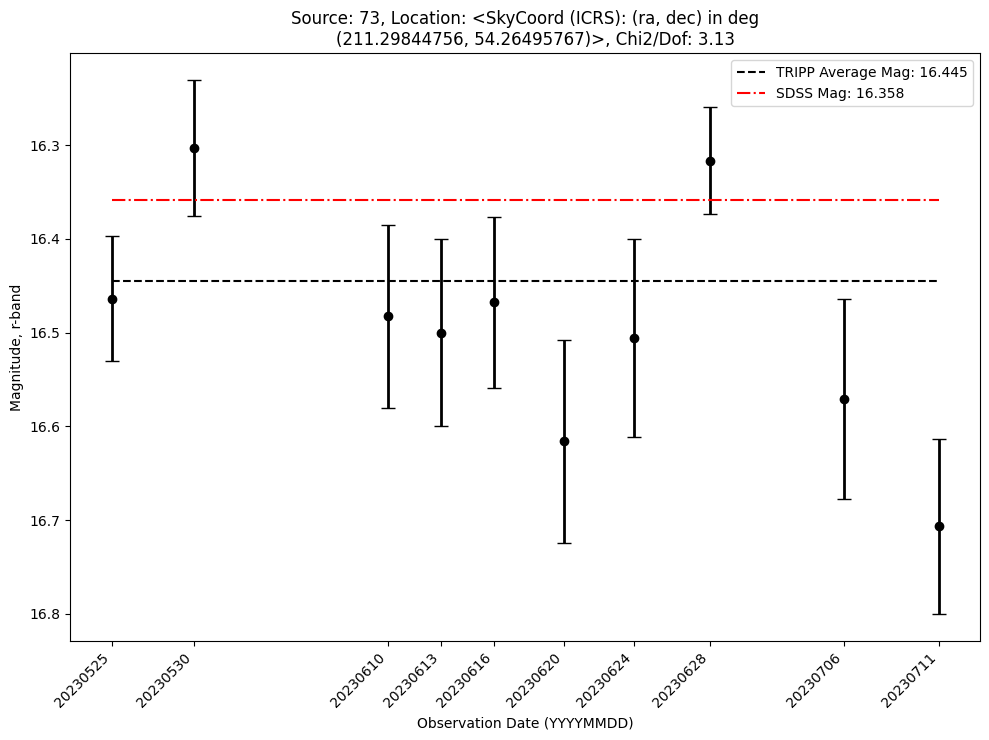

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30476211, 54.37648842)>, Night_0_xy: (array(574.36176662), array(1935.16180117)) rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
16.30494, inst_mag_avg:-7.676089873892185, cal_mag_avg: 16.393332172019488, flagged: False, ID: 74, Chi2: None
None
[0.07240731896668635, 0.07594197596879065, 0.10084248729265062, 0.10633135328164246, 0.1028754851638434, 0.11150870026383015, 0.10831462482900941, 0.06364549046357154, 0.11548562755789867, 0.0874951567407942]


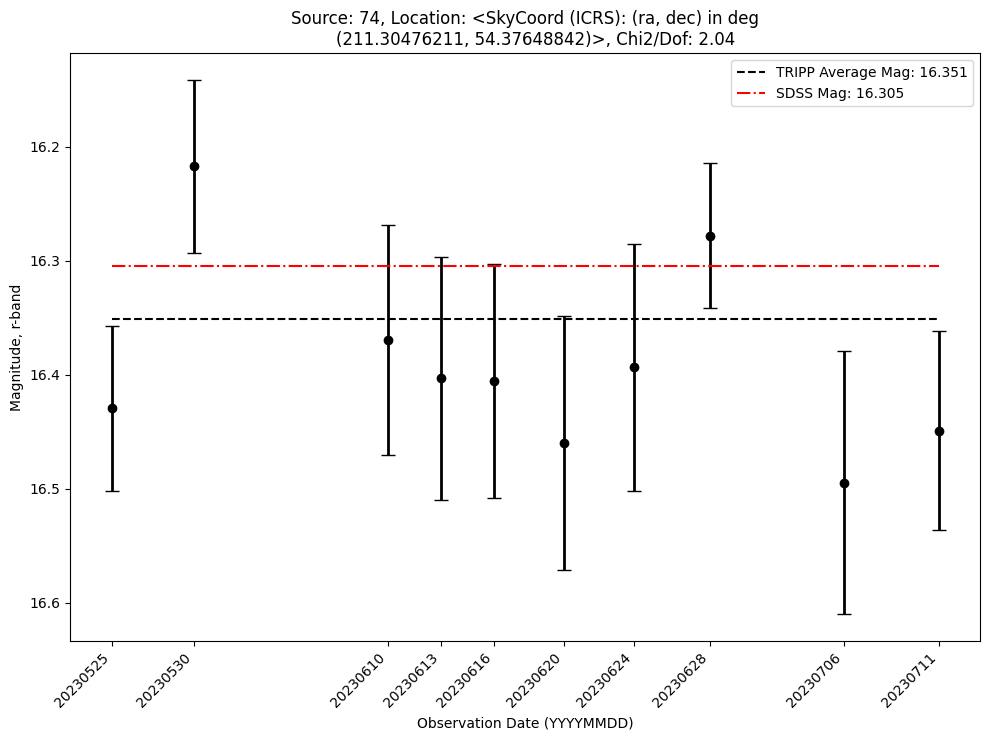

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.30066365, 54.21154036)>, Night_0_xy: (array(1614.67063692), array(1946.97923083)) rad: 5.0, ref_status: True, ref_mag: psfMag_r
--------
14.42296, inst_mag_avg:-9.588574583098133, cal_mag_avg: 14.546197971368096, flagged: False, ID: 75, Chi2: None
None
[0.02130691835335941, 0.024977570642725044, 0.028084814053683616, 0.02770338832196587, 0.027788271069145946, 0.02861869477491093, 0.030285643990358064, 0.020785209901171834, 0.02878066402390338, 0.023680875964754725]


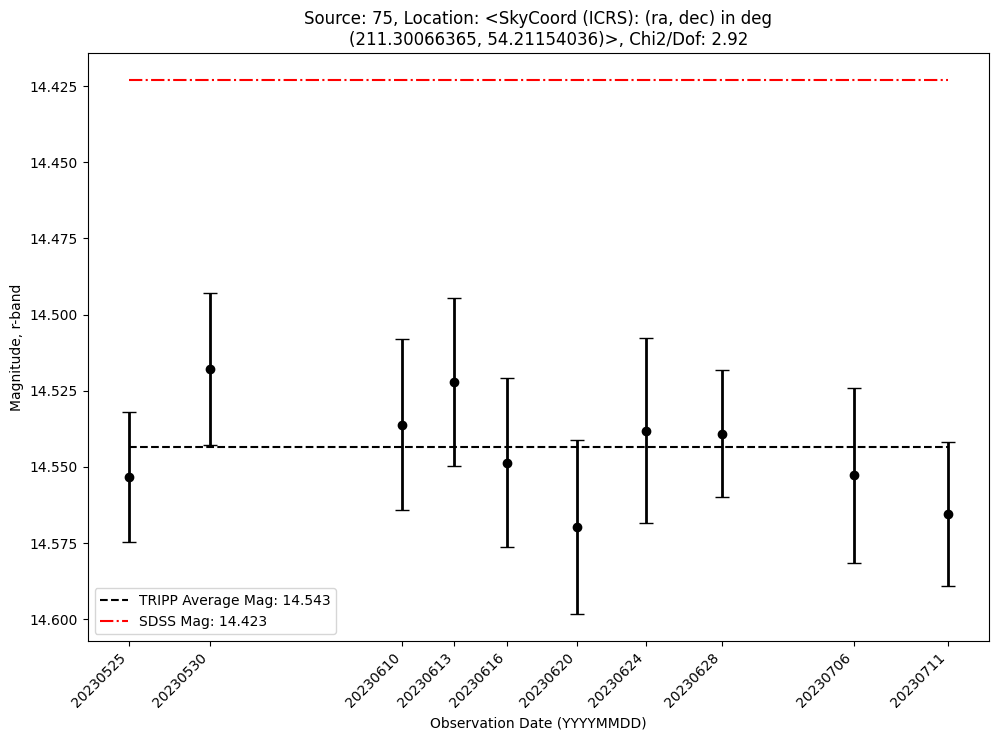

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (211.29289799, 53.99842441)>, Night_0_xy: (array(2959.01285808), array(1952.91401717)) rad: 3.5, ref_status: True, ref_mag: psfMag_r
--------
15.40109, inst_mag_avg:-8.486017539174089, cal_mag_avg: 15.610803518986845, flagged: False, ID: 76, Chi2: None
None
[0.03512275447198035, 0.04377986443865595, 0.05513771093942002, 0.05411833660605147, 0.05200083387748822, 0.05188530393788506, 0.05772673655000222, 0.033911275543574496, 0.054215089360333785, 0.03941508490278297]


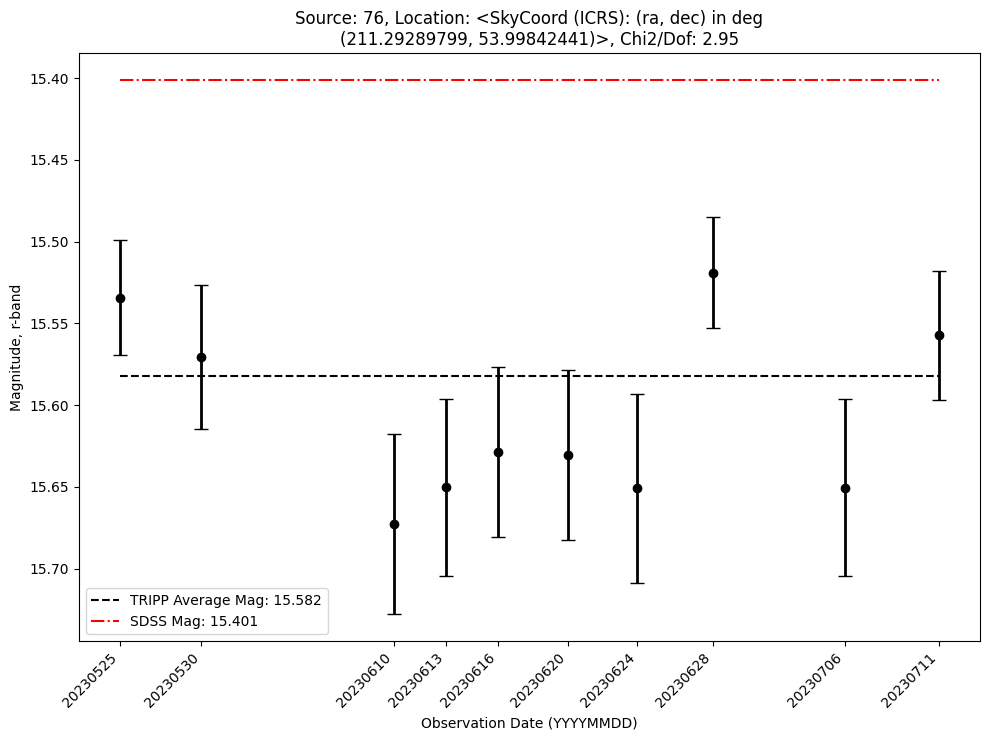

In [22]:
for source in Sources:
    if source.flagged != True:
        if len(Nights) > 1:
            print(source.get_info())
            night_array = np.array(night_array)
            source_mags = np.array(source.calibrated_mags/med_curve)
            source_errs = np.array(source.errors)
            median_mags = []
            median_errs = []
            mjd_times = []
            utc_times = []
            for night in range(np.max(night_array) + 1): # +1 avoids fencepost error in the night because range is exclusive.
                #Magnitudes
                index_array = np.where(night_array == night)[0]
                night_mags = source_mags[index_array]
                night_errs = source_errs[index_array]
                median_mags.append(np.median(night_mags))
                median_errs.append(np.median(night_errs))
                #Times
                mjd_array = np.array(Nights[night].mjd_times)
                utc_array = np.array(Nights[night].date)
                mjd_times.append(np.median(mjd_array))
                utc_times.append(utc_array[int(len(utc_array)/2)])
            print(median_errs)
            avg_mag = np.average(source.calibrated_mags/med_curve, weights= source.weights)
            Chis = []
            for i, m in enumerate(source.calibrated_mags):
                chi_i = (((m/med_curve[i]) - avg_mag)**2)/(source.errors[i]**2)
                Chis.append(chi_i)
            dof = len(source.calibrated_mags) - 1
            chi_dof = np.sum(Chis)/dof
            source.add_chi(chi_dof)
            dof_string =  "%.2f" % chi_dof
            plt.figure(figsize=(10,7.5))
            plt.title(f"Source: {source.source_id}, Location: {source.position}, Chi2/Dof: {dof_string}")
            plt.errorbar(mjd_times, median_mags, yerr=median_errs, elinewidth=2, capsize=5, linestyle="", marker="o", color="black")
            plt.xticks(mjd_times, utc_times, rotation=45, ha='right')
            plt.xlabel("Observation Date (YYYYMMDD)")
            plt.ylabel(f"Magnitude, {Nights[0].obs_filter}-band")
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.plot(mjd_times, np.ones(len(mjd_times))*avg_mag, linestyle = '--', color = 'black', label = "TRIPP Average Mag: {}".format("%.3f" % avg_mag))
            if source.is_reference:
                plt.plot(mjd_times, np.ones(len(mjd_times))*source.ref_mag, linestyle = 'dashdot', color = f"{Nights[0].obs_filter}", label = "SDSS Mag: {}".format("%.3f" % source.ref_mag))
            plt.legend()
            #plt.savefig(f"/Users/lucaangeleri/Desktop/test/source{source.source_id}.png", dpi = 1000)
            plt.show()

        else: #single night
            print(source.get_info())
            r = np.arange(0, len(source.calibrated_mags))
            avg_mag = np.average(source.calibrated_mags/med_curve, weights=source.weights)
            #avg_mag = np.mean(source.calibrated_mags/med_curve)
            Chis = []
            for i, m in enumerate(source.calibrated_mags):
                chi_i = (((m / med_curve[i]) - avg_mag) ** 2) / (source.errors[i] ** 2)
                Chis.append(chi_i)
            dof = len(source.calibrated_mags) - 1
            chi_dof = np.sum(Chis) / dof
            dof_string = "%.2f" % chi_dof
            plt.figure(figsize=(12, 9))
            plt.errorbar(r, source.calibrated_mags/med_curve, yerr=source.errors, elinewidth=1, capsize=2, markersize = 3, linestyle = 'none', marker = 'o', c = 'black')
            plt.plot(r, np.ones(len(r))*avg_mag, linestyle = '--', color = 'black', label = f"TRIPP Avg Mag:{avg_mag}")
            if source.is_reference:
                plt.plot(r, np.ones(len(r))*source.ref_mag, linestyle = 'dashdot', color = f"{Nights[0].obs_filter}", label = "SDSS Mag: {}".format("%.3f" % source.ref_mag))
            x_locs= []
            times = []
            for i in range(len(Nights[0].image_data))[::10]:
                x_locs.append(i)
                times.append(Nights[0].start_times[i])
            plt.xlabel("Observation Start Time, UTC (HH:MM:SS)")
            plt.ylabel(f"Magnitude {Nights[0].obs_filter}-band")
            plt.title(f"Source: {source.source_id}, Location: {source.position}, Chi2/Dof: {chi_dof}")
            plt.gca().invert_yaxis()
            plt.xticks(x_locs, times, rotation = 45)
            plt.legend()
            #plt.savefig("/Users/lucaangeleri/Desktop/test/sec32source{}.png".format(source.source_id), format = 'png', dpi = 500,  bbox_inches="tight")
            plt.show()



In [ ]:
transient_candidates = []
for source in Sources:
    if source.flagged != True:
        if source.chi2 > 25:
            transient_candidates.append(source.get_info())

print(len(transient_candidates))

ra_dec: <SkyCoord (ICRS): (ra, dec) in deg
    (210.91055426, 54.31169678)>, Night_0_xy: (array(1016.33978453), array(495.78820628)) rad: 14.0, ref_status: None, ref_mag: None, inst_mag_avg:-12.610324312664964, cal_mag_avg: 11.624743758609046, flagged: False, ID: 34, Chi2: 520.5764922523921
1


In [ ]:
header_row = ["Source_Position", "Reference_Source", "Reference_Magnitude", "Chi2/DoF", "Flagged", "Source_ID", "TRIPP_Calibrated_Mags" ]
with open('/Users/lucaangeleri/Desktop/output.csv', 'w') as stream:
    writer = csv.writer(stream)
    writer.writerow(header_row)
    writer.writerows([source for source in Sources if source.flagged != True and source.chi2>25])


In [ ]:
for night in Nights:
    print(night.headers[0]['SITE'], night.headers[0]['TELID'])


LCOGT node at Haleakala Observatory 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Haleakala Observatory 0m4b
LCOGT node at Tenerife 0m4b
LCOGT node at Haleakala Observatory 0m4b


In [ ]:
chis = []
for source in Sources:
    if not source.flagged:
        chis.append(source.chi2)
print(np.mean(chis), np.std(chis))

10.446794590087446 58.580870572315945


inst_mags = [source.inst_mags[counter] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        #inst_errs = [source.inst_mag_errs[counter] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        ref_mags = [source.ref_mag[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        #ref_mag_errs = [source.ref_mag_err[0] for source in Sources if source.is_reference == True and source.ref_mag < mag_thresh and source.flagged == False]
        p0, cov0 = np.polyfit(inst_mags, ref_mags, deg = 1, cov = True)
        diffs = [s.ref_mag[0] - (s.inst_mags[counter]*p0[0] + p0[1]) for s in Sources if s.is_reference == True and s.ref_mag < mag_thresh and source.flagged == False]
        stdv = np.std(diffs)
        inst_mags_final = []
        sky_mags_final = []
        outlier_inst =[]
        outlier_sky =[]
        for diff in diffs: #rudementary sigma clipping to remove outliers from calibration model.
            if diff < stdv:
                i = diffs.index(diff)
                inst_mags_final.append(inst_mags[i])
                sky_mags_final.append(ref_mags[i])
            else:
                i = diffs.index(diff)
                outlier_inst.append(inst_mags[i])
                outlier_sky.append(ref_mags[i])
        if len(sky_mags_final) > 0:
            p1, cov1 = np.polyfit(inst_mags_final, sky_mags_final, deg = 1, cov = True)
            if abs(p1[0]-1) < abs(p0[1]-1):
                print("using second")
                slopes.append(p1[0])
                zeros.append(p1[1])
                slope_errs.append(np.sqrt(np.diag(cov1))[0])
                zero_errs.append(np.sqrt(np.diag(cov1))[1])
        else:
            slopes.append(p0[0])
            zeros.append(p0[1])
            slope_errs.append(np.sqrt(np.diag(cov0))[0])
            zero_errs.append(np.sqrt(np.diag(cov0))[1])
        counter += 1